In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon Dec 13 17:21:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    38W / 250W |  14533MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install SimpleITK

In [16]:
import os

import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy.io

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
from torchsummary import summary
from tqdm import tqdm

# Data check

## view_input_dcm_data

Width:  2588
Heigh:  3232
Depth:  1
Dimension:  3
Pixel ID: 3
Pixel ID Type:  16-bit unsigned integer
check
[[[0.06028708 0.06028708 0.06028708]
  [0.06124402 0.06124402 0.06124402]
  [0.05845295 0.05845295 0.05845295]
  ...
  [0.11331739 0.11331739 0.11331739]
  [0.12025518 0.12025518 0.12025518]
  [0.12185008 0.12185008 0.12185008]]

 [[0.06371611 0.06371611 0.06371611]
  [0.06204147 0.06204147 0.06204147]
  [0.05813397 0.05813397 0.05813397]
  ...
  [0.11307815 0.11307815 0.11307815]
  [0.12001595 0.12001595 0.12001595]
  [0.12623605 0.12623605 0.12623605]]

 [[0.06371611 0.06371611 0.06371611]
  [0.06052632 0.06052632 0.06052632]
  [0.0585327  0.0585327  0.0585327 ]
  ...
  [0.11347687 0.11347687 0.11347687]
  [0.11738437 0.11738437 0.11738437]
  [0.12519936 0.12519936 0.12519936]]

 ...

 [[0.14824562 0.14824562 0.14824562]
  [0.14338118 0.14338118 0.14338118]
  [0.13883573 0.13883573 0.13883573]
  ...
  [0.13269538 0.13269538 0.13269538]
  [0.1299043  0.1299043  0.1299043 ]
  [0.

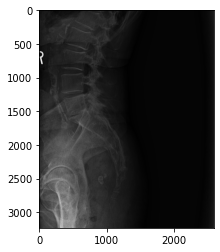

In [ ]:
filename = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train/img/002.dcm'
images = sitk.ReadImage(filename)

print("Width: ",images.GetWidth())
print("Heigh: ",images.GetHeight())
print("Depth: ",images.GetDepth())
print("Dimension: ",images.GetDimension())
print("Pixel ID:",images.GetPixelIDValue())
print("Pixel ID Type: ",images.GetPixelIDTypeAsString())

images_array=sitk.GetArrayFromImage(images).astype('float32')
img=np.squeeze(images_array)
copy_img=img.copy()
min=np.min(copy_img)
max=np.max(copy_img)


#0~1(실수)로 normalize하고 0~255(정수)로 바꿔줌
copy_img1=copy_img-np.min(copy_img)
copy_img=copy_img1/np.max(copy_img1)
# copy_img*=2**8-1
# copy_img=copy_img.astype(np.uint8)

copy_img=np.expand_dims(copy_img,axis=-1)
copy_img=cv2.cvtColor(copy_img,cv2.COLOR_GRAY2RGB)
print("check")

# plt.imshow(copy_img, cmap=plt.cm.bone)
#cv2_imshow(copy_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


plt.imshow(copy_img.squeeze(), cmap='gray')

print(copy_img)
print(copy_img.shape)
#datatype = np.ndarray
print("==================")
print("images_array")
print(type(images_array[0][0][0]))
print(images_array.shape)
print(images_array)
print(np.amin(copy_img))
print(np.amax(copy_img))


## view_label_mat_data

<class 'dict'>
__header__
__version__
__globals__
label_separated
size : (3232, 2588, 7)
datatype: <class 'numpy.uint8'>
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
mat_file_value
0


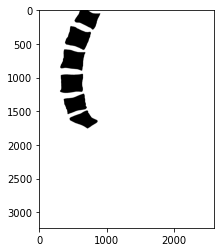

In [ ]:
mat_file_name =  "/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train/label/002.mat"
mat_file = scipy.io.loadmat(mat_file_name)

print(type(mat_file))

for i in mat_file:
    print(i)

mat_file_value = mat_file['label_separated']
print("size :",mat_file_value.shape)
print("datatype:", type(mat_file_value[0][0][0]))

print(mat_file_value[:,:,6])
plt.imshow(mat_file_value[:,:,6],cmap='gray')#plt.cm.bone
mat_file_value[:,:,6] = mat_file_value[:,:,6]*(-1)
#datatype = np.ndarray
print("==================")
print(mat_file_value[:,:,6])
print("mat_file_value")
print(np.amin(mat_file_value[:,:,6]))

# UNet Network

In [17]:
data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/datasets'
ckpt_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/checkpoint'
log_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/log'
result_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result'
board_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/leaderboard'
test_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test'

In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

## U-Net 구조 설계
class UNET(nn.Module):

    # U-Net에서 활용할 기본 block 들을 정의합니다. 
    def __init__(
            self, in_channels=1, out_channels=6, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contractive Path에 필요한 모듈을 self.downs 리스트에 보관합니다. DoubleConv blocks.
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Expansive Path에 필요한 모듈을 self.ups 리스트에 보관합니다. Transpose2d Convolution 및 DoubleConv blocks.
        for feature in reversed(features): #[512, 256, 128, 64]
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        #self.up : [(ConvTransposed2d, DoubleConv) *4]


        # U-Net의 가장 아래 부분.
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # 가장 마지막 Convolution layer. 1x1 Conv. 로 Output channel 을 맞추는 역할. 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # __init__ 에서 정의한 요소들로 실제 U-Net을 설계.
    def forward(self, x):

        # skip-connection 시킬 feature map 들을 보관하고 있을 리스트.
        skip_connections = []

        for down in self.downs: #self.downs: (DoubleConv *4)
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  #순서 뒤집어줌

        ## self.ups: [(ConvTranspose2D, DoubleConv) x 4]
        for idx in range(0, len(self.ups), 2): ## idx: 0, 2, 4, 6

            # ConvTransposed2d
            x = self.ups[idx](x) 
            skip_connection = skip_connections[idx//2] ## idx//2: 0, 1, 2, 3

            # Resize the upsampled feature map to the size of the skip-connected feature map.
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            
            # DoubleConv
            x = self.ups[idx+1](concat_skip) ## idx+1: 1, 3, 5, 7

        return self.final_conv(x)

In [ ]:
#@title 기본 제목 텍스트
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        #Convolution, Batch norm, ReLU set
        def CBR2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = True):
            #convolution layer
            layers = []
            layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding, bias = bias)]
            #batch norm layer
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            #ReLU layer
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)
            
            return cbr
        
        #contracting path
        self.enc1_1 = CBR2d(in_channels = 1, out_channels = c_a[0] )
        self.enc1_2 = CBR2d(in_channels = c_a[0], out_channels = c_a[0])

        self.pool1 = nn.MaxPool2d(kernel_size = 2)

        self.enc2_1 = CBR2d(in_channels = c_a[0], out_channels = c_a[1])
        self.enc2_2 = CBR2d(in_channels = c_a[1], out_channels = c_a[1])

        self.pool2 = nn.MaxPool2d(kernel_size = 2)

        self.enc3_1 = CBR2d(in_channels = c_a[1] , out_channels = c_a[2])
        self.enc3_2 = CBR2d(in_channels = c_a[2], out_channels = c_a[2])

        self.pool3 = nn.MaxPool2d(kernel_size = 2)

        self.enc4_1 = CBR2d(in_channels = c_a[2], out_channels = c_a[3])
        self.enc4_2 = CBR2d(in_channels = c_a[3], out_channels = c_a[3])

        self.pool4 = nn.MaxPool2d(kernel_size = 2)

        self.enc5_1 = CBR2d(in_channels = c_a[3], out_channels = c_a[4])

        #expansive path
        self.dec5_1 = CBR2d(in_channels= c_a[4] , out_channels = c_a[3])

        self.unpool4 = nn.ConvTranspose2d(in_channels= c_a[3], out_channels = c_a[3] , kernel_size=2 , stride= 2, padding =0 , bias = True)

        self.dec4_2 = CBR2d(in_channels= c_a[3]*2 , out_channels = c_a[3])
        self.dec4_1 = CBR2d(in_channels= c_a[3] , out_channels = c_a[2])

        self.unpool3 = nn.ConvTranspose2d(in_channels = c_a[2] , out_channels = c_a[2] , kernel_size=2 , stride=2 , padding =0 , bias = True)

        self.dec3_2 = CBR2d(in_channels= c_a[2]*2 , out_channels = c_a[2])
        self.dec3_1 = CBR2d(in_channels= c_a[2], out_channels = c_a[1])

        self.unpool2 = nn.ConvTranspose2d(in_channels= c_a[1], out_channels=c_a[1] , kernel_size=2 , stride=2 , padding =0 , bias = True)

        self.dec2_2 = CBR2d(in_channels=2*c_a[1] , out_channels = c_a[1])
        self.dec2_1 = CBR2d(in_channels= c_a[1], out_channels=c_a[0])

        self.unpool1 = nn.ConvTranspose2d(in_channels= c_a[0], out_channels=c_a[0] , kernel_size=2 , stride=2 , padding = 0, bias = True)

        self.dec1_2 = CBR2d(in_channels= 2*c_a[0], out_channels = c_a[0])
        self.dec1_1 = CBR2d(in_channels= c_a[0], out_channels= c_a[0])

        self.fc = nn.Conv2d(in_channels= c_a[0], out_channels= 6, kernel_size=1 , stride=1 , padding =0 , bias = True)
    
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.fc(dec1_1)

        return x

# Dataset

In [19]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform

        if self.data_dir == '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test':
            lst_input = os.listdir(os.path.join(self.data_dir,'img'))
            lst_label = os.listdir(os.path.join(self.data_dir, 'img'))

            lst_input.sort()
            lst_label.sort()

            self.lst_input = lst_input
            self.lst_label = lst_label
        else:
            lst_input = os.listdir(os.path.join(self.data_dir,'img'))
            lst_label = os.listdir(os.path.join(self.data_dir, 'label'))

            lst_input.sort()
            lst_label.sort()

            self.lst_input = lst_input
            self.lst_label = lst_label

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        
        #testset 일 경우
        if self.data_dir == '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test':
            #label은 없어야하지만 dataset을 구성해주기 위해 input을 복사해주어 structure만 만들어줌.
            
            #absolute path of img and label
            input_abs_path = os.path.join(*[self.data_dir, 'img', self.lst_input[index]])
            label_abs_path = os.path.join(*[self.data_dir, 'img', self.lst_input[index]])
            
           #np.ndarray of img
            images = sitk.ReadImage(input_abs_path)
            input_np =sitk.GetArrayFromImage(images).astype('float32')
            input_np_copy = input_np.copy()

            #input array를 0~1 float 로 바꿔줌
            input_np_copy1 = input_np_copy - np.min(input_np_copy)
            input_np_copy = input_np_copy1 / np.max(input_np_copy1)

            #false np.darray of label            
            label_np =sitk.GetArrayFromImage(images).astype('float32')

            
            data = {'input' : input_np_copy, 'label' : label_np}

            if self.transform:
                data = self.transform(data)

            return data 

        #train, validation set 일 경우
        else:
        
            #absolute path of img and label
            input_abs_path = os.path.join(*[self.data_dir, 'img', self.lst_input[index]])
            label_abs_path = os.path.join(*[self.data_dir, 'label', self.lst_label[index]])
            
            #np.ndarray of img and label
            images = sitk.ReadImage(input_abs_path)
            input_np =sitk.GetArrayFromImage(images).astype('float32')
            input_np_copy = input_np.copy()

            #input array를 0~1 float 로 바꿔줌
            input_np_copy1 = input_np_copy - np.min(input_np_copy)
            input_np_copy = input_np_copy1 / np.max(input_np_copy1)

            #label numpy array
            label_mat_file = scipy.io.loadmat(label_abs_path)
            label_np = label_mat_file['label_separated']

            label = label_np.transpose(2,0,1)[:6,:,:].copy()
            # label[6] = -label[6]+1

            #data['input'] = 0~1 float32 , data['label'] = 0~1 float32
            data = {'input' : input_np_copy, 'label' : label.astype('float32')}

            if self.transform:
                data = self.transform(data)

            return data        

## Dataset example

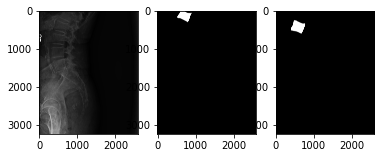

In [20]:
example = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train')

# print(example.lst_input)
# for name in example.lst_input:
#     print(name[:-3])
#     break
# print(example.lst_input.pop(0)[:-3])

data = example.__getitem__(1)

input = data['input']
label = data['label']

# input = cv2.resize(input.transpose(1,2,0), (2048,2048)) 
# label = cv2.resize(label.transpose(1,2,0), (2048,2048)) 

# print(input.shape)
# print(input[0])
# print(label.shape)
# print(label[6])
# print(type(np.amax(label[6])))
# print(type(np.amax(input[0])))




# print(input.transpose(2,0,1).shape)
# print(input.transpose(1,2,0).shape)
# plt.imshow(input.transpose(2,0,1), cmap='gray')


plt.subplot(131)
plt.imshow(input.squeeze(), cmap='gray')

plt.subplot(132)
plt.imshow(label[0], cmap='gray')
plt.subplot(133)
plt.imshow(label[1], cmap='gray')


# Data transformer

In [7]:
class ToTensor(object):
    def __call__(self,data):
        label, input = data['label'], data['input']

        input = input.astype(np.float32)
        label = label.astype(np.float32)
        
        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean = 0.5, std = 0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std
        data = {'label': label, 'input' : input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label':label, 'input':input}

        return data

class Rescale(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # h, w = label.shape[1], label.shape[2]
        
        # small_val = h if h <= w else w
        
        # exp = 0

        # while small_val>=1:
        #     small_val = small_val / 2
        #     exp += 1
        
        # resize = 2**(exp-1)

        input = cv2.resize(input.transpose(1,2,0), (1024,1024)) 
        label = cv2.resize(label.transpose(1,2,0), (1024,1024))
  
        data = {'label':label.transpose(2,0,1), 'input':input}

        return data

class Rescale_testset(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # h, w = label.shape[1], label.shape[2]
        
        # small_val = h if h <= w else w
        
        # exp = 0

        # while small_val>=1:
        #     small_val = small_val / 2
        #     exp += 1
        
        # resize = 2**(exp-1)

        input = cv2.resize(input.transpose(1,2,0), (1024,1024)) 
        label = cv2.resize(label.transpose(1,2,0), (1024,1024))
  
        data = {'label':label, 'input':input}

        return data        

## Data transform example

In [ ]:
#compose transform
transform_example_trainset = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation((-72,72)),
    # transforms.RandomAffine(0,translate=(0.1,0.1)),
    Normalization(mean=0.5, std=0.5),
    RandomFlip(),
    # Rescale(),
    ToTensor()
])

transform_exmaple_testset = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation((-72,72)),
    # transforms.RandomAffine(0,translate=(0.1,0.1)),
    Normalization(),
    # RandomFlip(),
    ToTensor()
])

=========input==========
torch.Size([2048, 2048])
<class 'torch.Tensor'>
tensor([[23.1549, 23.0506, 22.4809,  ..., 28.1161, 28.6763, 29.1965],
        [23.3534, 23.0108, 22.4393,  ..., 28.3407, 28.5373, 29.3542],
        [24.0697, 23.0865, 22.4852,  ..., 28.4495, 28.5158, 29.1485],
        ...,
        [32.5115, 31.9423, 31.3404,  ..., 29.5181, 29.3880, 29.4674],
        [31.5061, 30.9562, 30.3015,  ..., 30.1901, 30.0526, 29.9397],
        [29.9773, 29.9616, 29.4195,  ..., 30.3305, 30.5096, 30.3370]])
=========label==========
torch.Size([6, 2048, 2048])
<class 'torch.Tensor'>
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 

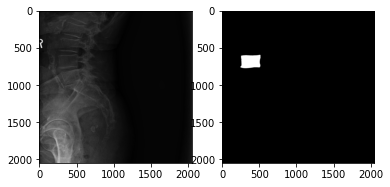

In [ ]:
dataset_db = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train', transform=transform_example_trainset)
data = dataset_db.__getitem__(1)

input = data['input']
label = data['label']

print("=========input==========")
print(input.shape)
print(type(input))
print(input)
print("=========label==========")
print(label.shape)
print(type(label))
print(label)
print("===================")
plt.subplot(121)
plt.imshow(input.squeeze(), cmap='gray')

plt.subplot(122)
plt.imshow(label[2], cmap='gray')

# Trainer

In [8]:
lr = 1e-3
batch_size = 2
num_epoch = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
import warnings
warnings.filterwarnings(action='ignore')

class trainer:

    def __init__(self, model, train_loader, opt, epoch_size = num_epoch, learning_rate = lr, use_cuda =True):
        
        self.use_cuda = use_cuda

        #Use GPU, model to GPU
        if self.use_cuda:
            self.net = model.cuda()

        else:
            self.net = model
    
        self.train_loader = train_loader
        self.optimizer = opt
        self.epoch_size = epoch_size
        self.learning_rate = learning_rate
        self.criterion = nn.BCEWithLogitsLoss().to(device)
        # self.criterion = nn.CrossEntropyLoss().to(device)

        self.history = {'train_acc':[],'val_acc':[],'test_acc':[],'train_loss':[],'val_loss':[],'test_loss':[]}

    def train(self, validation_loader = None):

        #Choose optimizer
        if self.optimizer == "SGD":
          optimizer = torch.optim.SGD(self.net.parameters(), lr = self.learning_rate)
        elif self.optimizer == "Adam":
          optimizer = torch.optim.Adam(self.net.parameters(), lr = self.learning_rate)
        elif self.optimizer == "Adagrad":
          optimizer = torch.optim.Adagrad(self.net.parameters(), lr = self.learning_rate)
        elif self.optimizer == "RMSprop":
          optimizer = torch.optim.RMSprop(self.net.parameters(), lr = self.learning_rate)

        for epoch in tqdm(range(self.epoch_size)):
            
            self.net.train()
            loss_arr = []

            for batch, data in enumerate(self.train_loader):
                
                #forward pass
                if self.use_cuda:
                    input = data['input'].to(device)
                    label = data['label'].to(device)

                #unsqueeze depends on batch size to match shape
                if batch_size ==1:
                    output = self.net(input)
                else:
                    output = self.net(input.unsqueeze(1))

                #backward pass & loss
                optimizer.zero_grad() #gradient initialization
                loss = self.criterion(output, label) #output:prediction, label: answer tensor
                loss.backward() #backpropagation
                optimizer.step()
                
                #history
                loss_arr += [loss.item()]
                
                print("Train: epoch %04d / %04d | batch %04d / %04d | loss %.4f" % (epoch+1, self.epoch_size, batch, num_batch_train, np.mean(loss_arr)))
                
                #tensor board
            #     print(label.shape)
            #     label = fn_tonumpy(label)
            #     input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            #     output = fn_tonumpy(fn_class(output))

            #     writer_train.add_image('label', label, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
            #     writer_train.add_image('input', input, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
            #     writer_train.add_image('output', output, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
            

            # writer_train.add_scalar('loss', np.mean(loss_arr), epoch)
            self.history['train_loss'].append(np.mean(loss_arr))

            if validation_loader != None:
                self.validate(validation_loader)

            save(ckpt_dir = ckpt_dir, net = self.net, optim = optimizer, epoch = epoch)
                ############################


    @torch.no_grad()
    def validate(self, data_loader):
        
        self.net.eval() #no weight update
        val_loss_arr = []
        
        num_correct = 0
        num_pixels = 0
        

        for batch, data in enumerate(data_loader):
            #forward pass
            if self.use_cuda:
                input = data['input'].to(device)
                label = data['label'].to(device)
            
            #unsqueeze depends on batch size to match shape
            if batch_size ==1:
                output = self.net(input)
            else:
                output = self.net(input.unsqueeze(1))
            
            #loss function
            val_loss = self.criterion(output, label)
            val_loss_arr += [val_loss.item()]

            print("Val loss %.4f" % (np.mean(val_loss_arr)))
            
            #dice loss
            for j in range(output.shape[0]):
                preds = torch.clone(output[j]) #(N, 6, 1024,1024)

                for i in range(preds.shape[0]):
                    preds[i] = (preds[i]-torch.mean(preds[i]))/torch.std(preds[i])
                    preds[i] = torch.sigmoid(preds[i])
                    preds[i] = fn_classifier(preds[i])
            
            num_correct += (preds == label).sum()
            num_pixels += torch.numel(preds)
            
            dice_score = (2*(preds*label).sum()) / ((preds+label).sum() + 1e-8)

            print(f"Dice score : {dice_score}")

        #     #tensor board
        #     label = fn_tonumpy(label)
        #     input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        #     output = fn_tonumpy(fn_class(output))

        #     writer_val.add_image('label', label, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
        #     writer_val.add_image('input', input, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
        #     writer_val.add_image('output', output, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')

        # writer_val.add_scalar('loss', np.mean(val_loss_arr), epoch)

        if  data_loader != self.train_loader: 
            self.history['val_loss'].append(np.mean(val_loss_arr))


    @torch.no_grad()
    def test(self, data_loader):
        
        test_img_arr = os.listdir(os.path.join(test_dir,'img'))
        test_img_arr.sort()
            
        self.net.eval() #no weight update
        test_loss_arr = []

        for batch, data in enumerate(data_loader):
            #forward pass
            if self.use_cuda:
                input = data['input'].to(device)
                # label = data['label'].to(device)

            #unsqueeze depends on batch size to match shape
            if batch_size ==1:
                output = self.net(input)
            else:
                output = self.net(input.unsqueeze(1))
            
            #######################################
            ###there is no backward pass in test###
            #######################################

            #loss function
            # test_loss = self.criterion(output, label)

            # test_loss_arr += [test_loss.item()]

            #print test loss
            # print("Test:  batch %04d / %04d | loss %.4f" % (batch, num_batch_test, np.mean(test_loss_arr)))

            #tensor board
            # label = fn_tonumpy(label)


            #save output image and numpy 
            
            input = fn_denorm(input, mean=0.5, std=0.5)
            input = fn_tonumpy(input)

            # print(type(input)) #<class 'torch.Tensor'>
            # print(type(output)) #<class 'torch.Tensor'>

            # output = fn_tonumpy(fn_classifier(output))
            # output = fn_tonumpy(output)

            # print(f"input: {type(input)} : {input.shape}") #(4, 1024, 1024)
            # print(f"output: {type(output)} : {output.shape}") #(4, 6, 1024, 1024)
            print(1)
            for j in range(output.shape[0]):
                
                id = num_batch_test * (batch -1)+j
                print(2)
                # plt.imsave(os.path.join(result_dir, 'png' ,'label_%04d.png' %id), label[j].squeeze(), cmap='gray')
                plt.imsave(os.path.join(result_dir, 'png' ,'input_%04d.png' %id), input[j].squeeze(), cmap='gray')


                print(3)
                preds = output[j].clone()  # (6,1024,1024)
                for i in range(preds.shape[0]):
                    preds[i] = (preds[i]-torch.mean(preds[i]))/torch.std(preds[i])
                    preds[i] = torch.sigmoid(preds[i])
                    preds[i] = fn_classifier(preds[i])
                
                preds = fn_tonumpy(preds)
                np.save(os.path.join(result_dir, 'numpy','output_%04d.npy' %id), preds.squeeze())
                print(4)

                # output_ = fn_tonumpy(fn_classifier(output))
                preds_torch = torch.Tensor(preds)
                print(5)
                for k in range(6):
                    plt.imsave(os.path.join(result_dir, 'png' ,'output_%04d_%04d.png' %(id, k)), preds[k].squeeze(), cmap='gray')

                # print(f"input shape {input[j].squeeze().shape}") #(1024, 1024)
                # print(f"output shape {output[j].squeeze().shape}") #(6, 1024, 1024)
                
                # np.save(os.path.join(result_dir, 'numpy','label_%04d.npy' %id), label[j].squeeze())
                
                # np.save(os.path.join(result_dir, 'numpy','input_%04d.npy' %id), input[j].squeeze())
                # np.save(os.path.join(result_dir, 'numpy','output_%04d.npy' %id), output[j].squeeze())
                



                if test_img_arr:
                    print(test_img_arr)
                    test_input_abs_path = os.path.join(test_dir, 'img', test_img_arr[0])
                    images = sitk.ReadImage(test_input_abs_path)
                    test_input_shape =sitk.GetArrayFromImage(images).shape #(1,3232,2588)

                    print(test_input_shape)
                    print(output.shape) #(2,6,1024,1024)
                    print(output[j].shape) #(6,1024,1024)
                    # 7 채널로..
                    preds_tensor = torch.cat((preds_torch, preds_torch[5].unsqueeze(0)))
                    preds_np = cv2.resize(fn_tonumpy(preds_tensor).transpose(1,2,0), (test_input_shape[2],test_input_shape[1])) 
                    
                    print(np.amax(preds_np))
                    #7채널
                    # output_np = cv2.resize(fn_tonumpy(output[j]).transpose(1,2,0), (test_input_shape[2],test_input_shape[1])) 
                    
                    print(preds_np.shape)

                    
                    #preds save
                    np.save(os.path.join(board_dir, test_img_arr.pop(0)[:-4]), np.uint8(preds_np))

                    #output save
                    # np.save(os.path.join(board_dir, test_img_arr.pop(0)[:-4]), np.uint8(output_np))
                
                
        self.history['test_loss'].append(np.mean(test_loss_arr))

        # print("Average test: loss %.4f" % (np.mean(test_loss_arr)))


# Data transform

In [10]:
#compose transform
transform_wholeset = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation((-72,72)),
    # transforms.RandomAffine(0,translate=(0.1,0.1)),
    Normalization(),
    RandomFlip(),
    Rescale(),
    ToTensor()
])

transform_testset = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation((-72,72)),
    # transforms.RandomAffine(0,translate=(0.1,0.1)),
    Normalization(),
    # RandomFlip(),
    Rescale_testset(),
    ToTensor()
])

#train, val dataset, dataloader
whole_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train', transform = transform_wholeset)
train_dataset, val_dataset = torch.utils.data.random_split(whole_dataset, [100, 20])
test_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test' , transform = transform_testset)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

In [ ]:
# print(len(test_dataset))
# print(test_dataset.lst_input[0])
# print(test_dataset.lst_label)
# # aaa = test_dataset.__getitem__(1)
# # aaa['input']
# print(len(test_loader.dataset))


# for batch, data in enumerate(test_loader):
#     print(data['input'].shape)

#     print(data['input'])
    
#     print(data['input'].unsqueeze(1).shape)
    
#     print(data['input'].unsqueeze(1))

#     break
#     # #forward pass
    # if self.use_cuda:
    #     input = data['input'].to(device)
    #     label = data['label'].to(device)

    # output = self.net(input.unsqueeze(1))

# Before Train

In [11]:
#other variables
num_data_train = len(train_dataset)
num_data_val = len(val_dataset)
num_data_test = len(test_dataset)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)
num_batch_test = np.ceil(num_data_test / batch_size)


# 기타 function 설정
# fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_tonumpy = lambda x : x.to('cpu').detach().numpy() # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.65)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

# tensorboard, SummaryWriter
writer_train = SummaryWriter(log_dir = os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir, 'val'))

#save network
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

#load network
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch


## example model summary

In [ ]:
example_model = UNET()
example_model.cuda()

summary(example_model, input_size=(1,1024,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]             576
       BatchNorm2d-2       [-1, 64, 1024, 1024]             128
              ReLU-3       [-1, 64, 1024, 1024]               0
            Conv2d-4       [-1, 64, 1024, 1024]          36,864
       BatchNorm2d-5       [-1, 64, 1024, 1024]             128
              ReLU-6       [-1, 64, 1024, 1024]               0
        DoubleConv-7       [-1, 64, 1024, 1024]               0
         MaxPool2d-8         [-1, 64, 512, 512]               0
            Conv2d-9        [-1, 128, 512, 512]          73,728
      BatchNorm2d-10        [-1, 128, 512, 512]             256
             ReLU-11        [-1, 128, 512, 512]               0
           Conv2d-12        [-1, 128, 512, 512]         147,456
      BatchNorm2d-13        [-1, 128, 512, 512]             256
             ReLU-14        [-1, 128, 5

In [ ]:
example_model_64 = UNet()
example_model_64.cuda()

summary(example_model_64, input_size=(1,1024,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]             640
       BatchNorm2d-2       [-1, 64, 1024, 1024]             128
              ReLU-3       [-1, 64, 1024, 1024]               0
            Conv2d-4       [-1, 64, 1024, 1024]          36,928
       BatchNorm2d-5       [-1, 64, 1024, 1024]             128
              ReLU-6       [-1, 64, 1024, 1024]               0
         MaxPool2d-7         [-1, 64, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]          73,856
       BatchNorm2d-9        [-1, 128, 512, 512]             256
             ReLU-10        [-1, 128, 512, 512]               0
           Conv2d-11        [-1, 128, 512, 512]         147,584
      BatchNorm2d-12        [-1, 128, 512, 512]             256
             ReLU-13        [-1, 128, 512, 512]               0
        MaxPool2d-14        [-1, 128, 2

In [ ]:
example_model_32 = UNet()
example_model_32.cuda()

summary(example_model_32, input_size=(1,1024,1024))

torch.Size([2, 256, 128, 128]) torch.Size([2, 256, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             320
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
              ReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
              ReLU-6       [-1, 32, 1024, 1024]               0
         MaxPool2d-7         [-1, 32, 512, 512]               0
            Conv2d-8         [-1, 64, 512, 512]          18,496
       BatchNorm2d-9         [-1, 64, 512, 512]             128
             ReLU-10         [-1, 64, 512, 512]               0
           Conv2d-11         [-1, 64, 512, 512]          36,928
      BatchNorm2d-12         [-1, 64, 512, 512]             128
             ReLU-13         [-1, 64, 512

# Train

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
Spine_segment = UNET()
Spine_segment.cuda()
trainer_Spine_segment = trainer(Spine_segment, train_loader,"Adam", epoch_size=100, learning_rate=0.001)
trainer_Spine_segment.train(val_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

Train: epoch 0001 / 0100 | batch 0000 / 0050 | loss 0.7060
Train: epoch 0001 / 0100 | batch 0001 / 0050 | loss 0.6882
Train: epoch 0001 / 0100 | batch 0002 / 0050 | loss 0.6752
Train: epoch 0001 / 0100 | batch 0003 / 0050 | loss 0.6557
Train: epoch 0001 / 0100 | batch 0004 / 0050 | loss 0.6356
Train: epoch 0001 / 0100 | batch 0005 / 0050 | loss 0.6222
Train: epoch 0001 / 0100 | batch 0006 / 0050 | loss 0.6065
Train: epoch 0001 / 0100 | batch 0007 / 0050 | loss 0.5957
Train: epoch 0001 / 0100 | batch 0008 / 0050 | loss 0.5834
Train: epoch 0001 / 0100 | batch 0009 / 0050 | loss 0.5722
Train: epoch 0001 / 0100 | batch 0010 / 0050 | loss 0.5633
Train: epoch 0001 / 0100 | batch 0011 / 0050 | loss 0.5543
Train: epoch 0001 / 0100 | batch 0012 / 0050 | loss 0.5462
Train: epoch 0001 / 0100 | batch 0013 / 0050 | loss 0.5388
Train: epoch 0001 / 0100 | batch 0014 / 0050 | loss 0.5316
Train: epoch 0001 / 0100 | batch 0015 / 0050 | loss 0.5255
Train: epoch 0001 / 0100 | batch 0016 / 0050 | loss 0.51

  1%|          | 1/100 [01:23<2:18:22, 83.86s/it]

Train: epoch 0002 / 0100 | batch 0000 / 0050 | loss 0.2310
Train: epoch 0002 / 0100 | batch 0001 / 0050 | loss 0.2264
Train: epoch 0002 / 0100 | batch 0002 / 0050 | loss 0.2249
Train: epoch 0002 / 0100 | batch 0003 / 0050 | loss 0.2244
Train: epoch 0002 / 0100 | batch 0004 / 0050 | loss 0.2239
Train: epoch 0002 / 0100 | batch 0005 / 0050 | loss 0.2215
Train: epoch 0002 / 0100 | batch 0006 / 0050 | loss 0.2205
Train: epoch 0002 / 0100 | batch 0007 / 0050 | loss 0.2185
Train: epoch 0002 / 0100 | batch 0008 / 0050 | loss 0.2160
Train: epoch 0002 / 0100 | batch 0009 / 0050 | loss 0.2138
Train: epoch 0002 / 0100 | batch 0010 / 0050 | loss 0.2116
Train: epoch 0002 / 0100 | batch 0011 / 0050 | loss 0.2114
Train: epoch 0002 / 0100 | batch 0012 / 0050 | loss 0.2092
Train: epoch 0002 / 0100 | batch 0013 / 0050 | loss 0.2075
Train: epoch 0002 / 0100 | batch 0014 / 0050 | loss 0.2062
Train: epoch 0002 / 0100 | batch 0015 / 0050 | loss 0.2043
Train: epoch 0002 / 0100 | batch 0016 / 0050 | loss 0.20

  2%|▏         | 2/100 [02:44<2:13:40, 81.84s/it]

Train: epoch 0003 / 0100 | batch 0000 / 0050 | loss 0.1035
Train: epoch 0003 / 0100 | batch 0001 / 0050 | loss 0.1104
Train: epoch 0003 / 0100 | batch 0002 / 0050 | loss 0.1103
Train: epoch 0003 / 0100 | batch 0003 / 0050 | loss 0.1073
Train: epoch 0003 / 0100 | batch 0004 / 0050 | loss 0.1077
Train: epoch 0003 / 0100 | batch 0005 / 0050 | loss 0.1059
Train: epoch 0003 / 0100 | batch 0006 / 0050 | loss 0.1046
Train: epoch 0003 / 0100 | batch 0007 / 0050 | loss 0.1036
Train: epoch 0003 / 0100 | batch 0008 / 0050 | loss 0.1026
Train: epoch 0003 / 0100 | batch 0009 / 0050 | loss 0.1016
Train: epoch 0003 / 0100 | batch 0010 / 0050 | loss 0.1018
Train: epoch 0003 / 0100 | batch 0011 / 0050 | loss 0.1020
Train: epoch 0003 / 0100 | batch 0012 / 0050 | loss 0.1015
Train: epoch 0003 / 0100 | batch 0013 / 0050 | loss 0.1032
Train: epoch 0003 / 0100 | batch 0014 / 0050 | loss 0.1027
Train: epoch 0003 / 0100 | batch 0015 / 0050 | loss 0.1025
Train: epoch 0003 / 0100 | batch 0016 / 0050 | loss 0.10

  3%|▎         | 3/100 [04:05<2:11:47, 81.52s/it]

Train: epoch 0004 / 0100 | batch 0000 / 0050 | loss 0.0740
Train: epoch 0004 / 0100 | batch 0001 / 0050 | loss 0.0744
Train: epoch 0004 / 0100 | batch 0002 / 0050 | loss 0.0709
Train: epoch 0004 / 0100 | batch 0003 / 0050 | loss 0.0696
Train: epoch 0004 / 0100 | batch 0004 / 0050 | loss 0.0694
Train: epoch 0004 / 0100 | batch 0005 / 0050 | loss 0.0703
Train: epoch 0004 / 0100 | batch 0006 / 0050 | loss 0.0719
Train: epoch 0004 / 0100 | batch 0007 / 0050 | loss 0.0713
Train: epoch 0004 / 0100 | batch 0008 / 0050 | loss 0.0728
Train: epoch 0004 / 0100 | batch 0009 / 0050 | loss 0.0730
Train: epoch 0004 / 0100 | batch 0010 / 0050 | loss 0.0725
Train: epoch 0004 / 0100 | batch 0011 / 0050 | loss 0.0728
Train: epoch 0004 / 0100 | batch 0012 / 0050 | loss 0.0722
Train: epoch 0004 / 0100 | batch 0013 / 0050 | loss 0.0725
Train: epoch 0004 / 0100 | batch 0014 / 0050 | loss 0.0719
Train: epoch 0004 / 0100 | batch 0015 / 0050 | loss 0.0718
Train: epoch 0004 / 0100 | batch 0016 / 0050 | loss 0.07

  4%|▍         | 4/100 [05:26<2:10:09, 81.35s/it]

Train: epoch 0005 / 0100 | batch 0000 / 0050 | loss 0.0613
Train: epoch 0005 / 0100 | batch 0001 / 0050 | loss 0.0821
Train: epoch 0005 / 0100 | batch 0002 / 0050 | loss 0.0758
Train: epoch 0005 / 0100 | batch 0003 / 0050 | loss 0.0711
Train: epoch 0005 / 0100 | batch 0004 / 0050 | loss 0.0705
Train: epoch 0005 / 0100 | batch 0005 / 0050 | loss 0.0680
Train: epoch 0005 / 0100 | batch 0006 / 0050 | loss 0.0681
Train: epoch 0005 / 0100 | batch 0007 / 0050 | loss 0.0665
Train: epoch 0005 / 0100 | batch 0008 / 0050 | loss 0.0667
Train: epoch 0005 / 0100 | batch 0009 / 0050 | loss 0.0668
Train: epoch 0005 / 0100 | batch 0010 / 0050 | loss 0.0674
Train: epoch 0005 / 0100 | batch 0011 / 0050 | loss 0.0669
Train: epoch 0005 / 0100 | batch 0012 / 0050 | loss 0.0663
Train: epoch 0005 / 0100 | batch 0013 / 0050 | loss 0.0653
Train: epoch 0005 / 0100 | batch 0014 / 0050 | loss 0.0646
Train: epoch 0005 / 0100 | batch 0015 / 0050 | loss 0.0646
Train: epoch 0005 / 0100 | batch 0016 / 0050 | loss 0.06

  5%|▌         | 5/100 [06:45<2:07:21, 80.44s/it]

Train: epoch 0006 / 0100 | batch 0000 / 0050 | loss 0.0660
Train: epoch 0006 / 0100 | batch 0001 / 0050 | loss 0.0620
Train: epoch 0006 / 0100 | batch 0002 / 0050 | loss 0.0648
Train: epoch 0006 / 0100 | batch 0003 / 0050 | loss 0.0666
Train: epoch 0006 / 0100 | batch 0004 / 0050 | loss 0.0666
Train: epoch 0006 / 0100 | batch 0005 / 0050 | loss 0.0637
Train: epoch 0006 / 0100 | batch 0006 / 0050 | loss 0.0619
Train: epoch 0006 / 0100 | batch 0007 / 0050 | loss 0.0603
Train: epoch 0006 / 0100 | batch 0008 / 0050 | loss 0.0619
Train: epoch 0006 / 0100 | batch 0009 / 0050 | loss 0.0635
Train: epoch 0006 / 0100 | batch 0010 / 0050 | loss 0.0625
Train: epoch 0006 / 0100 | batch 0011 / 0050 | loss 0.0629
Train: epoch 0006 / 0100 | batch 0012 / 0050 | loss 0.0624
Train: epoch 0006 / 0100 | batch 0013 / 0050 | loss 0.0630
Train: epoch 0006 / 0100 | batch 0014 / 0050 | loss 0.0619
Train: epoch 0006 / 0100 | batch 0015 / 0050 | loss 0.0614
Train: epoch 0006 / 0100 | batch 0016 / 0050 | loss 0.06

  6%|▌         | 6/100 [08:07<2:06:43, 80.89s/it]

Train: epoch 0007 / 0100 | batch 0000 / 0050 | loss 0.0492
Train: epoch 0007 / 0100 | batch 0001 / 0050 | loss 0.0533
Train: epoch 0007 / 0100 | batch 0002 / 0050 | loss 0.0543
Train: epoch 0007 / 0100 | batch 0003 / 0050 | loss 0.0557
Train: epoch 0007 / 0100 | batch 0004 / 0050 | loss 0.0564
Train: epoch 0007 / 0100 | batch 0005 / 0050 | loss 0.0593
Train: epoch 0007 / 0100 | batch 0006 / 0050 | loss 0.0597
Train: epoch 0007 / 0100 | batch 0007 / 0050 | loss 0.0581
Train: epoch 0007 / 0100 | batch 0008 / 0050 | loss 0.0567
Train: epoch 0007 / 0100 | batch 0009 / 0050 | loss 0.0597
Train: epoch 0007 / 0100 | batch 0010 / 0050 | loss 0.0595
Train: epoch 0007 / 0100 | batch 0011 / 0050 | loss 0.0588
Train: epoch 0007 / 0100 | batch 0012 / 0050 | loss 0.0587
Train: epoch 0007 / 0100 | batch 0013 / 0050 | loss 0.0589
Train: epoch 0007 / 0100 | batch 0014 / 0050 | loss 0.0580
Train: epoch 0007 / 0100 | batch 0015 / 0050 | loss 0.0590
Train: epoch 0007 / 0100 | batch 0016 / 0050 | loss 0.05

  7%|▋         | 7/100 [09:29<2:05:59, 81.28s/it]

Train: epoch 0008 / 0100 | batch 0000 / 0050 | loss 0.0450
Train: epoch 0008 / 0100 | batch 0001 / 0050 | loss 0.0537
Train: epoch 0008 / 0100 | batch 0002 / 0050 | loss 0.0562
Train: epoch 0008 / 0100 | batch 0003 / 0050 | loss 0.0527
Train: epoch 0008 / 0100 | batch 0004 / 0050 | loss 0.0522
Train: epoch 0008 / 0100 | batch 0005 / 0050 | loss 0.0515
Train: epoch 0008 / 0100 | batch 0006 / 0050 | loss 0.0519
Train: epoch 0008 / 0100 | batch 0007 / 0050 | loss 0.0525
Train: epoch 0008 / 0100 | batch 0008 / 0050 | loss 0.0541
Train: epoch 0008 / 0100 | batch 0009 / 0050 | loss 0.0544
Train: epoch 0008 / 0100 | batch 0010 / 0050 | loss 0.0552
Train: epoch 0008 / 0100 | batch 0011 / 0050 | loss 0.0563
Train: epoch 0008 / 0100 | batch 0012 / 0050 | loss 0.0554
Train: epoch 0008 / 0100 | batch 0013 / 0050 | loss 0.0545
Train: epoch 0008 / 0100 | batch 0014 / 0050 | loss 0.0540
Train: epoch 0008 / 0100 | batch 0015 / 0050 | loss 0.0548
Train: epoch 0008 / 0100 | batch 0016 / 0050 | loss 0.05

  8%|▊         | 8/100 [10:49<2:03:55, 80.82s/it]

Train: epoch 0009 / 0100 | batch 0000 / 0050 | loss 0.0457
Train: epoch 0009 / 0100 | batch 0001 / 0050 | loss 0.0602
Train: epoch 0009 / 0100 | batch 0002 / 0050 | loss 0.0552
Train: epoch 0009 / 0100 | batch 0003 / 0050 | loss 0.0579
Train: epoch 0009 / 0100 | batch 0004 / 0050 | loss 0.0593
Train: epoch 0009 / 0100 | batch 0005 / 0050 | loss 0.0584
Train: epoch 0009 / 0100 | batch 0006 / 0050 | loss 0.0601
Train: epoch 0009 / 0100 | batch 0007 / 0050 | loss 0.0613
Train: epoch 0009 / 0100 | batch 0008 / 0050 | loss 0.0619
Train: epoch 0009 / 0100 | batch 0009 / 0050 | loss 0.0639
Train: epoch 0009 / 0100 | batch 0010 / 0050 | loss 0.0630
Train: epoch 0009 / 0100 | batch 0011 / 0050 | loss 0.0627
Train: epoch 0009 / 0100 | batch 0012 / 0050 | loss 0.0616
Train: epoch 0009 / 0100 | batch 0013 / 0050 | loss 0.0616
Train: epoch 0009 / 0100 | batch 0014 / 0050 | loss 0.0607
Train: epoch 0009 / 0100 | batch 0015 / 0050 | loss 0.0599
Train: epoch 0009 / 0100 | batch 0016 / 0050 | loss 0.05

  9%|▉         | 9/100 [12:09<2:02:35, 80.83s/it]

Train: epoch 0010 / 0100 | batch 0000 / 0050 | loss 0.0709
Train: epoch 0010 / 0100 | batch 0001 / 0050 | loss 0.0746
Train: epoch 0010 / 0100 | batch 0002 / 0050 | loss 0.0672
Train: epoch 0010 / 0100 | batch 0003 / 0050 | loss 0.0633
Train: epoch 0010 / 0100 | batch 0004 / 0050 | loss 0.0595
Train: epoch 0010 / 0100 | batch 0005 / 0050 | loss 0.0564
Train: epoch 0010 / 0100 | batch 0006 / 0050 | loss 0.0568
Train: epoch 0010 / 0100 | batch 0007 / 0050 | loss 0.0554
Train: epoch 0010 / 0100 | batch 0008 / 0050 | loss 0.0568
Train: epoch 0010 / 0100 | batch 0009 / 0050 | loss 0.0554
Train: epoch 0010 / 0100 | batch 0010 / 0050 | loss 0.0561
Train: epoch 0010 / 0100 | batch 0011 / 0050 | loss 0.0581
Train: epoch 0010 / 0100 | batch 0012 / 0050 | loss 0.0571
Train: epoch 0010 / 0100 | batch 0013 / 0050 | loss 0.0571
Train: epoch 0010 / 0100 | batch 0014 / 0050 | loss 0.0576
Train: epoch 0010 / 0100 | batch 0015 / 0050 | loss 0.0579
Train: epoch 0010 / 0100 | batch 0016 / 0050 | loss 0.05

 10%|█         | 10/100 [13:30<2:00:55, 80.61s/it]

Train: epoch 0011 / 0100 | batch 0000 / 0050 | loss 0.0458
Train: epoch 0011 / 0100 | batch 0001 / 0050 | loss 0.0509
Train: epoch 0011 / 0100 | batch 0002 / 0050 | loss 0.0557
Train: epoch 0011 / 0100 | batch 0003 / 0050 | loss 0.0554
Train: epoch 0011 / 0100 | batch 0004 / 0050 | loss 0.0536
Train: epoch 0011 / 0100 | batch 0005 / 0050 | loss 0.0560
Train: epoch 0011 / 0100 | batch 0006 / 0050 | loss 0.0575
Train: epoch 0011 / 0100 | batch 0007 / 0050 | loss 0.0564
Train: epoch 0011 / 0100 | batch 0008 / 0050 | loss 0.0554
Train: epoch 0011 / 0100 | batch 0009 / 0050 | loss 0.0555
Train: epoch 0011 / 0100 | batch 0010 / 0050 | loss 0.0544
Train: epoch 0011 / 0100 | batch 0011 / 0050 | loss 0.0535
Train: epoch 0011 / 0100 | batch 0012 / 0050 | loss 0.0525
Train: epoch 0011 / 0100 | batch 0013 / 0050 | loss 0.0520
Train: epoch 0011 / 0100 | batch 0014 / 0050 | loss 0.0514
Train: epoch 0011 / 0100 | batch 0015 / 0050 | loss 0.0521
Train: epoch 0011 / 0100 | batch 0016 / 0050 | loss 0.05

 11%|█         | 11/100 [14:49<1:59:15, 80.40s/it]

Train: epoch 0012 / 0100 | batch 0000 / 0050 | loss 0.0544
Train: epoch 0012 / 0100 | batch 0001 / 0050 | loss 0.0577
Train: epoch 0012 / 0100 | batch 0002 / 0050 | loss 0.0534
Train: epoch 0012 / 0100 | batch 0003 / 0050 | loss 0.0563
Train: epoch 0012 / 0100 | batch 0004 / 0050 | loss 0.0551
Train: epoch 0012 / 0100 | batch 0005 / 0050 | loss 0.0547
Train: epoch 0012 / 0100 | batch 0006 / 0050 | loss 0.0554
Train: epoch 0012 / 0100 | batch 0007 / 0050 | loss 0.0537
Train: epoch 0012 / 0100 | batch 0008 / 0050 | loss 0.0520
Train: epoch 0012 / 0100 | batch 0009 / 0050 | loss 0.0519
Train: epoch 0012 / 0100 | batch 0010 / 0050 | loss 0.0529
Train: epoch 0012 / 0100 | batch 0011 / 0050 | loss 0.0536
Train: epoch 0012 / 0100 | batch 0012 / 0050 | loss 0.0538
Train: epoch 0012 / 0100 | batch 0013 / 0050 | loss 0.0548
Train: epoch 0012 / 0100 | batch 0014 / 0050 | loss 0.0542
Train: epoch 0012 / 0100 | batch 0015 / 0050 | loss 0.0546
Train: epoch 0012 / 0100 | batch 0016 / 0050 | loss 0.05

 12%|█▏        | 12/100 [16:10<1:58:09, 80.57s/it]

Train: epoch 0013 / 0100 | batch 0000 / 0050 | loss 0.0558
Train: epoch 0013 / 0100 | batch 0001 / 0050 | loss 0.0492
Train: epoch 0013 / 0100 | batch 0002 / 0050 | loss 0.0472
Train: epoch 0013 / 0100 | batch 0003 / 0050 | loss 0.0482
Train: epoch 0013 / 0100 | batch 0004 / 0050 | loss 0.0487
Train: epoch 0013 / 0100 | batch 0005 / 0050 | loss 0.0463
Train: epoch 0013 / 0100 | batch 0006 / 0050 | loss 0.0489
Train: epoch 0013 / 0100 | batch 0007 / 0050 | loss 0.0493
Train: epoch 0013 / 0100 | batch 0008 / 0050 | loss 0.0507
Train: epoch 0013 / 0100 | batch 0009 / 0050 | loss 0.0514
Train: epoch 0013 / 0100 | batch 0010 / 0050 | loss 0.0522
Train: epoch 0013 / 0100 | batch 0011 / 0050 | loss 0.0514
Train: epoch 0013 / 0100 | batch 0012 / 0050 | loss 0.0511
Train: epoch 0013 / 0100 | batch 0013 / 0050 | loss 0.0515
Train: epoch 0013 / 0100 | batch 0014 / 0050 | loss 0.0536
Train: epoch 0013 / 0100 | batch 0015 / 0050 | loss 0.0529
Train: epoch 0013 / 0100 | batch 0016 / 0050 | loss 0.05

 13%|█▎        | 13/100 [17:30<1:56:33, 80.38s/it]

Train: epoch 0014 / 0100 | batch 0000 / 0050 | loss 0.0458
Train: epoch 0014 / 0100 | batch 0001 / 0050 | loss 0.0452
Train: epoch 0014 / 0100 | batch 0002 / 0050 | loss 0.0443
Train: epoch 0014 / 0100 | batch 0003 / 0050 | loss 0.0482
Train: epoch 0014 / 0100 | batch 0004 / 0050 | loss 0.0478
Train: epoch 0014 / 0100 | batch 0005 / 0050 | loss 0.0461
Train: epoch 0014 / 0100 | batch 0006 / 0050 | loss 0.0449
Train: epoch 0014 / 0100 | batch 0007 / 0050 | loss 0.0465
Train: epoch 0014 / 0100 | batch 0008 / 0050 | loss 0.0503
Train: epoch 0014 / 0100 | batch 0009 / 0050 | loss 0.0497
Train: epoch 0014 / 0100 | batch 0010 / 0050 | loss 0.0507
Train: epoch 0014 / 0100 | batch 0011 / 0050 | loss 0.0514
Train: epoch 0014 / 0100 | batch 0012 / 0050 | loss 0.0511
Train: epoch 0014 / 0100 | batch 0013 / 0050 | loss 0.0516
Train: epoch 0014 / 0100 | batch 0014 / 0050 | loss 0.0537
Train: epoch 0014 / 0100 | batch 0015 / 0050 | loss 0.0537
Train: epoch 0014 / 0100 | batch 0016 / 0050 | loss 0.05

 14%|█▍        | 14/100 [18:52<1:55:49, 80.81s/it]

Train: epoch 0015 / 0100 | batch 0000 / 0050 | loss 0.0523
Train: epoch 0015 / 0100 | batch 0001 / 0050 | loss 0.0502
Train: epoch 0015 / 0100 | batch 0002 / 0050 | loss 0.0526
Train: epoch 0015 / 0100 | batch 0003 / 0050 | loss 0.0565
Train: epoch 0015 / 0100 | batch 0004 / 0050 | loss 0.0556
Train: epoch 0015 / 0100 | batch 0005 / 0050 | loss 0.0555
Train: epoch 0015 / 0100 | batch 0006 / 0050 | loss 0.0549
Train: epoch 0015 / 0100 | batch 0007 / 0050 | loss 0.0554
Train: epoch 0015 / 0100 | batch 0008 / 0050 | loss 0.0562
Train: epoch 0015 / 0100 | batch 0009 / 0050 | loss 0.0550
Train: epoch 0015 / 0100 | batch 0010 / 0050 | loss 0.0544
Train: epoch 0015 / 0100 | batch 0011 / 0050 | loss 0.0546
Train: epoch 0015 / 0100 | batch 0012 / 0050 | loss 0.0550
Train: epoch 0015 / 0100 | batch 0013 / 0050 | loss 0.0544
Train: epoch 0015 / 0100 | batch 0014 / 0050 | loss 0.0535
Train: epoch 0015 / 0100 | batch 0015 / 0050 | loss 0.0531
Train: epoch 0015 / 0100 | batch 0016 / 0050 | loss 0.05

 15%|█▌        | 15/100 [20:16<1:55:42, 81.68s/it]

Train: epoch 0016 / 0100 | batch 0000 / 0050 | loss 0.0436
Train: epoch 0016 / 0100 | batch 0001 / 0050 | loss 0.0538
Train: epoch 0016 / 0100 | batch 0002 / 0050 | loss 0.0534
Train: epoch 0016 / 0100 | batch 0003 / 0050 | loss 0.0562
Train: epoch 0016 / 0100 | batch 0004 / 0050 | loss 0.0540
Train: epoch 0016 / 0100 | batch 0005 / 0050 | loss 0.0586
Train: epoch 0016 / 0100 | batch 0006 / 0050 | loss 0.0557
Train: epoch 0016 / 0100 | batch 0007 / 0050 | loss 0.0588
Train: epoch 0016 / 0100 | batch 0008 / 0050 | loss 0.0597
Train: epoch 0016 / 0100 | batch 0009 / 0050 | loss 0.0578
Train: epoch 0016 / 0100 | batch 0010 / 0050 | loss 0.0564
Train: epoch 0016 / 0100 | batch 0011 / 0050 | loss 0.0565
Train: epoch 0016 / 0100 | batch 0012 / 0050 | loss 0.0553
Train: epoch 0016 / 0100 | batch 0013 / 0050 | loss 0.0557
Train: epoch 0016 / 0100 | batch 0014 / 0050 | loss 0.0560
Train: epoch 0016 / 0100 | batch 0015 / 0050 | loss 0.0548
Train: epoch 0016 / 0100 | batch 0016 / 0050 | loss 0.05

 16%|█▌        | 16/100 [21:36<1:53:33, 81.11s/it]

Train: epoch 0017 / 0100 | batch 0000 / 0050 | loss 0.0666
Train: epoch 0017 / 0100 | batch 0001 / 0050 | loss 0.0720
Train: epoch 0017 / 0100 | batch 0002 / 0050 | loss 0.0586
Train: epoch 0017 / 0100 | batch 0003 / 0050 | loss 0.0550
Train: epoch 0017 / 0100 | batch 0004 / 0050 | loss 0.0529
Train: epoch 0017 / 0100 | batch 0005 / 0050 | loss 0.0523
Train: epoch 0017 / 0100 | batch 0006 / 0050 | loss 0.0518
Train: epoch 0017 / 0100 | batch 0007 / 0050 | loss 0.0503
Train: epoch 0017 / 0100 | batch 0008 / 0050 | loss 0.0504
Train: epoch 0017 / 0100 | batch 0009 / 0050 | loss 0.0505
Train: epoch 0017 / 0100 | batch 0010 / 0050 | loss 0.0494
Train: epoch 0017 / 0100 | batch 0011 / 0050 | loss 0.0493
Train: epoch 0017 / 0100 | batch 0012 / 0050 | loss 0.0486
Train: epoch 0017 / 0100 | batch 0013 / 0050 | loss 0.0499
Train: epoch 0017 / 0100 | batch 0014 / 0050 | loss 0.0495
Train: epoch 0017 / 0100 | batch 0015 / 0050 | loss 0.0495
Train: epoch 0017 / 0100 | batch 0016 / 0050 | loss 0.04

 17%|█▋        | 17/100 [22:56<1:51:41, 80.74s/it]

Train: epoch 0018 / 0100 | batch 0000 / 0050 | loss 0.0546
Train: epoch 0018 / 0100 | batch 0001 / 0050 | loss 0.0458
Train: epoch 0018 / 0100 | batch 0002 / 0050 | loss 0.0424
Train: epoch 0018 / 0100 | batch 0003 / 0050 | loss 0.0460
Train: epoch 0018 / 0100 | batch 0004 / 0050 | loss 0.0439
Train: epoch 0018 / 0100 | batch 0005 / 0050 | loss 0.0444
Train: epoch 0018 / 0100 | batch 0006 / 0050 | loss 0.0457
Train: epoch 0018 / 0100 | batch 0007 / 0050 | loss 0.0448
Train: epoch 0018 / 0100 | batch 0008 / 0050 | loss 0.0449
Train: epoch 0018 / 0100 | batch 0009 / 0050 | loss 0.0458
Train: epoch 0018 / 0100 | batch 0010 / 0050 | loss 0.0453
Train: epoch 0018 / 0100 | batch 0011 / 0050 | loss 0.0458
Train: epoch 0018 / 0100 | batch 0012 / 0050 | loss 0.0453
Train: epoch 0018 / 0100 | batch 0013 / 0050 | loss 0.0451
Train: epoch 0018 / 0100 | batch 0014 / 0050 | loss 0.0454
Train: epoch 0018 / 0100 | batch 0015 / 0050 | loss 0.0448
Train: epoch 0018 / 0100 | batch 0016 / 0050 | loss 0.04

 18%|█▊        | 18/100 [24:16<1:50:21, 80.75s/it]

Train: epoch 0019 / 0100 | batch 0000 / 0050 | loss 0.0673
Train: epoch 0019 / 0100 | batch 0001 / 0050 | loss 0.0697
Train: epoch 0019 / 0100 | batch 0002 / 0050 | loss 0.0645
Train: epoch 0019 / 0100 | batch 0003 / 0050 | loss 0.0623
Train: epoch 0019 / 0100 | batch 0004 / 0050 | loss 0.0591
Train: epoch 0019 / 0100 | batch 0005 / 0050 | loss 0.0572
Train: epoch 0019 / 0100 | batch 0006 / 0050 | loss 0.0549
Train: epoch 0019 / 0100 | batch 0007 / 0050 | loss 0.0520
Train: epoch 0019 / 0100 | batch 0008 / 0050 | loss 0.0551
Train: epoch 0019 / 0100 | batch 0009 / 0050 | loss 0.0543
Train: epoch 0019 / 0100 | batch 0010 / 0050 | loss 0.0536
Train: epoch 0019 / 0100 | batch 0011 / 0050 | loss 0.0539
Train: epoch 0019 / 0100 | batch 0012 / 0050 | loss 0.0554
Train: epoch 0019 / 0100 | batch 0013 / 0050 | loss 0.0552
Train: epoch 0019 / 0100 | batch 0014 / 0050 | loss 0.0538
Train: epoch 0019 / 0100 | batch 0015 / 0050 | loss 0.0529
Train: epoch 0019 / 0100 | batch 0016 / 0050 | loss 0.05

 19%|█▉        | 19/100 [25:34<1:47:54, 79.93s/it]

Train: epoch 0020 / 0100 | batch 0000 / 0050 | loss 0.0608
Train: epoch 0020 / 0100 | batch 0001 / 0050 | loss 0.0528
Train: epoch 0020 / 0100 | batch 0002 / 0050 | loss 0.0533
Train: epoch 0020 / 0100 | batch 0003 / 0050 | loss 0.0547
Train: epoch 0020 / 0100 | batch 0004 / 0050 | loss 0.0588
Train: epoch 0020 / 0100 | batch 0005 / 0050 | loss 0.0602
Train: epoch 0020 / 0100 | batch 0006 / 0050 | loss 0.0575
Train: epoch 0020 / 0100 | batch 0007 / 0050 | loss 0.0553
Train: epoch 0020 / 0100 | batch 0008 / 0050 | loss 0.0546
Train: epoch 0020 / 0100 | batch 0009 / 0050 | loss 0.0542
Train: epoch 0020 / 0100 | batch 0010 / 0050 | loss 0.0524
Train: epoch 0020 / 0100 | batch 0011 / 0050 | loss 0.0522
Train: epoch 0020 / 0100 | batch 0012 / 0050 | loss 0.0549
Train: epoch 0020 / 0100 | batch 0013 / 0050 | loss 0.0538
Train: epoch 0020 / 0100 | batch 0014 / 0050 | loss 0.0530
Train: epoch 0020 / 0100 | batch 0015 / 0050 | loss 0.0527
Train: epoch 0020 / 0100 | batch 0016 / 0050 | loss 0.05

 20%|██        | 20/100 [26:55<1:46:56, 80.21s/it]

Train: epoch 0021 / 0100 | batch 0000 / 0050 | loss 0.0622
Train: epoch 0021 / 0100 | batch 0001 / 0050 | loss 0.0539
Train: epoch 0021 / 0100 | batch 0002 / 0050 | loss 0.0499
Train: epoch 0021 / 0100 | batch 0003 / 0050 | loss 0.0527
Train: epoch 0021 / 0100 | batch 0004 / 0050 | loss 0.0536
Train: epoch 0021 / 0100 | batch 0005 / 0050 | loss 0.0557
Train: epoch 0021 / 0100 | batch 0006 / 0050 | loss 0.0564
Train: epoch 0021 / 0100 | batch 0007 / 0050 | loss 0.0571
Train: epoch 0021 / 0100 | batch 0008 / 0050 | loss 0.0547
Train: epoch 0021 / 0100 | batch 0009 / 0050 | loss 0.0540
Train: epoch 0021 / 0100 | batch 0010 / 0050 | loss 0.0528
Train: epoch 0021 / 0100 | batch 0011 / 0050 | loss 0.0515
Train: epoch 0021 / 0100 | batch 0012 / 0050 | loss 0.0510
Train: epoch 0021 / 0100 | batch 0013 / 0050 | loss 0.0522
Train: epoch 0021 / 0100 | batch 0014 / 0050 | loss 0.0526
Train: epoch 0021 / 0100 | batch 0015 / 0050 | loss 0.0519
Train: epoch 0021 / 0100 | batch 0016 / 0050 | loss 0.05

 21%|██        | 21/100 [28:15<1:45:36, 80.21s/it]

Train: epoch 0022 / 0100 | batch 0000 / 0050 | loss 0.0782
Train: epoch 0022 / 0100 | batch 0001 / 0050 | loss 0.0632
Train: epoch 0022 / 0100 | batch 0002 / 0050 | loss 0.0572
Train: epoch 0022 / 0100 | batch 0003 / 0050 | loss 0.0559
Train: epoch 0022 / 0100 | batch 0004 / 0050 | loss 0.0529
Train: epoch 0022 / 0100 | batch 0005 / 0050 | loss 0.0541
Train: epoch 0022 / 0100 | batch 0006 / 0050 | loss 0.0579
Train: epoch 0022 / 0100 | batch 0007 / 0050 | loss 0.0608
Train: epoch 0022 / 0100 | batch 0008 / 0050 | loss 0.0585
Train: epoch 0022 / 0100 | batch 0009 / 0050 | loss 0.0572
Train: epoch 0022 / 0100 | batch 0010 / 0050 | loss 0.0563
Train: epoch 0022 / 0100 | batch 0011 / 0050 | loss 0.0553
Train: epoch 0022 / 0100 | batch 0012 / 0050 | loss 0.0536
Train: epoch 0022 / 0100 | batch 0013 / 0050 | loss 0.0530
Train: epoch 0022 / 0100 | batch 0014 / 0050 | loss 0.0527
Train: epoch 0022 / 0100 | batch 0015 / 0050 | loss 0.0517
Train: epoch 0022 / 0100 | batch 0016 / 0050 | loss 0.05

 22%|██▏       | 22/100 [29:34<1:43:30, 79.62s/it]

Train: epoch 0023 / 0100 | batch 0000 / 0050 | loss 0.0735
Train: epoch 0023 / 0100 | batch 0001 / 0050 | loss 0.0762
Train: epoch 0023 / 0100 | batch 0002 / 0050 | loss 0.0682
Train: epoch 0023 / 0100 | batch 0003 / 0050 | loss 0.0616
Train: epoch 0023 / 0100 | batch 0004 / 0050 | loss 0.0593
Train: epoch 0023 / 0100 | batch 0005 / 0050 | loss 0.0580
Train: epoch 0023 / 0100 | batch 0006 / 0050 | loss 0.0553
Train: epoch 0023 / 0100 | batch 0007 / 0050 | loss 0.0537
Train: epoch 0023 / 0100 | batch 0008 / 0050 | loss 0.0527
Train: epoch 0023 / 0100 | batch 0009 / 0050 | loss 0.0534
Train: epoch 0023 / 0100 | batch 0010 / 0050 | loss 0.0541
Train: epoch 0023 / 0100 | batch 0011 / 0050 | loss 0.0540
Train: epoch 0023 / 0100 | batch 0012 / 0050 | loss 0.0542
Train: epoch 0023 / 0100 | batch 0013 / 0050 | loss 0.0532
Train: epoch 0023 / 0100 | batch 0014 / 0050 | loss 0.0535
Train: epoch 0023 / 0100 | batch 0015 / 0050 | loss 0.0525
Train: epoch 0023 / 0100 | batch 0016 / 0050 | loss 0.05

 23%|██▎       | 23/100 [30:52<1:41:34, 79.16s/it]

Train: epoch 0024 / 0100 | batch 0000 / 0050 | loss 0.0427
Train: epoch 0024 / 0100 | batch 0001 / 0050 | loss 0.0410
Train: epoch 0024 / 0100 | batch 0002 / 0050 | loss 0.0421
Train: epoch 0024 / 0100 | batch 0003 / 0050 | loss 0.0460
Train: epoch 0024 / 0100 | batch 0004 / 0050 | loss 0.0446
Train: epoch 0024 / 0100 | batch 0005 / 0050 | loss 0.0468
Train: epoch 0024 / 0100 | batch 0006 / 0050 | loss 0.0460
Train: epoch 0024 / 0100 | batch 0007 / 0050 | loss 0.0481
Train: epoch 0024 / 0100 | batch 0008 / 0050 | loss 0.0471
Train: epoch 0024 / 0100 | batch 0009 / 0050 | loss 0.0471
Train: epoch 0024 / 0100 | batch 0010 / 0050 | loss 0.0484
Train: epoch 0024 / 0100 | batch 0011 / 0050 | loss 0.0480
Train: epoch 0024 / 0100 | batch 0012 / 0050 | loss 0.0476
Train: epoch 0024 / 0100 | batch 0013 / 0050 | loss 0.0488
Train: epoch 0024 / 0100 | batch 0014 / 0050 | loss 0.0494
Train: epoch 0024 / 0100 | batch 0015 / 0050 | loss 0.0497
Train: epoch 0024 / 0100 | batch 0016 / 0050 | loss 0.05

 24%|██▍       | 24/100 [32:14<1:41:36, 80.21s/it]

Train: epoch 0025 / 0100 | batch 0000 / 0050 | loss 0.0631
Train: epoch 0025 / 0100 | batch 0001 / 0050 | loss 0.0489
Train: epoch 0025 / 0100 | batch 0002 / 0050 | loss 0.0464
Train: epoch 0025 / 0100 | batch 0003 / 0050 | loss 0.0514
Train: epoch 0025 / 0100 | batch 0004 / 0050 | loss 0.0495
Train: epoch 0025 / 0100 | batch 0005 / 0050 | loss 0.0522
Train: epoch 0025 / 0100 | batch 0006 / 0050 | loss 0.0552
Train: epoch 0025 / 0100 | batch 0007 / 0050 | loss 0.0529
Train: epoch 0025 / 0100 | batch 0008 / 0050 | loss 0.0542
Train: epoch 0025 / 0100 | batch 0009 / 0050 | loss 0.0524
Train: epoch 0025 / 0100 | batch 0010 / 0050 | loss 0.0511
Train: epoch 0025 / 0100 | batch 0011 / 0050 | loss 0.0501
Train: epoch 0025 / 0100 | batch 0012 / 0050 | loss 0.0504
Train: epoch 0025 / 0100 | batch 0013 / 0050 | loss 0.0512
Train: epoch 0025 / 0100 | batch 0014 / 0050 | loss 0.0507
Train: epoch 0025 / 0100 | batch 0015 / 0050 | loss 0.0503
Train: epoch 0025 / 0100 | batch 0016 / 0050 | loss 0.04

 25%|██▌       | 25/100 [33:36<1:40:46, 80.63s/it]

Train: epoch 0026 / 0100 | batch 0000 / 0050 | loss 0.0672
Train: epoch 0026 / 0100 | batch 0001 / 0050 | loss 0.0567
Train: epoch 0026 / 0100 | batch 0002 / 0050 | loss 0.0559
Train: epoch 0026 / 0100 | batch 0003 / 0050 | loss 0.0553
Train: epoch 0026 / 0100 | batch 0004 / 0050 | loss 0.0539
Train: epoch 0026 / 0100 | batch 0005 / 0050 | loss 0.0525
Train: epoch 0026 / 0100 | batch 0006 / 0050 | loss 0.0546
Train: epoch 0026 / 0100 | batch 0007 / 0050 | loss 0.0539
Train: epoch 0026 / 0100 | batch 0008 / 0050 | loss 0.0540
Train: epoch 0026 / 0100 | batch 0009 / 0050 | loss 0.0525
Train: epoch 0026 / 0100 | batch 0010 / 0050 | loss 0.0539
Train: epoch 0026 / 0100 | batch 0011 / 0050 | loss 0.0548
Train: epoch 0026 / 0100 | batch 0012 / 0050 | loss 0.0550
Train: epoch 0026 / 0100 | batch 0013 / 0050 | loss 0.0554
Train: epoch 0026 / 0100 | batch 0014 / 0050 | loss 0.0546
Train: epoch 0026 / 0100 | batch 0015 / 0050 | loss 0.0537
Train: epoch 0026 / 0100 | batch 0016 / 0050 | loss 0.05

 26%|██▌       | 26/100 [34:55<1:39:02, 80.30s/it]

Train: epoch 0027 / 0100 | batch 0000 / 0050 | loss 0.0508
Train: epoch 0027 / 0100 | batch 0001 / 0050 | loss 0.0518
Train: epoch 0027 / 0100 | batch 0002 / 0050 | loss 0.0478
Train: epoch 0027 / 0100 | batch 0003 / 0050 | loss 0.0511
Train: epoch 0027 / 0100 | batch 0004 / 0050 | loss 0.0571
Train: epoch 0027 / 0100 | batch 0005 / 0050 | loss 0.0541
Train: epoch 0027 / 0100 | batch 0006 / 0050 | loss 0.0549
Train: epoch 0027 / 0100 | batch 0007 / 0050 | loss 0.0526
Train: epoch 0027 / 0100 | batch 0008 / 0050 | loss 0.0505
Train: epoch 0027 / 0100 | batch 0009 / 0050 | loss 0.0516
Train: epoch 0027 / 0100 | batch 0010 / 0050 | loss 0.0523
Train: epoch 0027 / 0100 | batch 0011 / 0050 | loss 0.0533
Train: epoch 0027 / 0100 | batch 0012 / 0050 | loss 0.0521
Train: epoch 0027 / 0100 | batch 0013 / 0050 | loss 0.0519
Train: epoch 0027 / 0100 | batch 0014 / 0050 | loss 0.0510
Train: epoch 0027 / 0100 | batch 0015 / 0050 | loss 0.0513
Train: epoch 0027 / 0100 | batch 0016 / 0050 | loss 0.05

 27%|██▋       | 27/100 [36:16<1:37:50, 80.42s/it]

Train: epoch 0028 / 0100 | batch 0000 / 0050 | loss 0.0559
Train: epoch 0028 / 0100 | batch 0001 / 0050 | loss 0.0533
Train: epoch 0028 / 0100 | batch 0002 / 0050 | loss 0.0509
Train: epoch 0028 / 0100 | batch 0003 / 0050 | loss 0.0525
Train: epoch 0028 / 0100 | batch 0004 / 0050 | loss 0.0515
Train: epoch 0028 / 0100 | batch 0005 / 0050 | loss 0.0505
Train: epoch 0028 / 0100 | batch 0006 / 0050 | loss 0.0492
Train: epoch 0028 / 0100 | batch 0007 / 0050 | loss 0.0489
Train: epoch 0028 / 0100 | batch 0008 / 0050 | loss 0.0494
Train: epoch 0028 / 0100 | batch 0009 / 0050 | loss 0.0498
Train: epoch 0028 / 0100 | batch 0010 / 0050 | loss 0.0519
Train: epoch 0028 / 0100 | batch 0011 / 0050 | loss 0.0510
Train: epoch 0028 / 0100 | batch 0012 / 0050 | loss 0.0503
Train: epoch 0028 / 0100 | batch 0013 / 0050 | loss 0.0504
Train: epoch 0028 / 0100 | batch 0014 / 0050 | loss 0.0501
Train: epoch 0028 / 0100 | batch 0015 / 0050 | loss 0.0494
Train: epoch 0028 / 0100 | batch 0016 / 0050 | loss 0.04

 28%|██▊       | 28/100 [37:36<1:36:21, 80.30s/it]

Train: epoch 0029 / 0100 | batch 0000 / 0050 | loss 0.0680
Train: epoch 0029 / 0100 | batch 0001 / 0050 | loss 0.0581
Train: epoch 0029 / 0100 | batch 0002 / 0050 | loss 0.0531
Train: epoch 0029 / 0100 | batch 0003 / 0050 | loss 0.0507
Train: epoch 0029 / 0100 | batch 0004 / 0050 | loss 0.0619
Train: epoch 0029 / 0100 | batch 0005 / 0050 | loss 0.0605
Train: epoch 0029 / 0100 | batch 0006 / 0050 | loss 0.0592
Train: epoch 0029 / 0100 | batch 0007 / 0050 | loss 0.0564
Train: epoch 0029 / 0100 | batch 0008 / 0050 | loss 0.0549
Train: epoch 0029 / 0100 | batch 0009 / 0050 | loss 0.0593
Train: epoch 0029 / 0100 | batch 0010 / 0050 | loss 0.0579
Train: epoch 0029 / 0100 | batch 0011 / 0050 | loss 0.0585
Train: epoch 0029 / 0100 | batch 0012 / 0050 | loss 0.0582
Train: epoch 0029 / 0100 | batch 0013 / 0050 | loss 0.0565
Train: epoch 0029 / 0100 | batch 0014 / 0050 | loss 0.0553
Train: epoch 0029 / 0100 | batch 0015 / 0050 | loss 0.0560
Train: epoch 0029 / 0100 | batch 0016 / 0050 | loss 0.05

 29%|██▉       | 29/100 [38:54<1:34:15, 79.65s/it]

Train: epoch 0030 / 0100 | batch 0000 / 0050 | loss 0.0370
Train: epoch 0030 / 0100 | batch 0001 / 0050 | loss 0.0525
Train: epoch 0030 / 0100 | batch 0002 / 0050 | loss 0.0553
Train: epoch 0030 / 0100 | batch 0003 / 0050 | loss 0.0512
Train: epoch 0030 / 0100 | batch 0004 / 0050 | loss 0.0525
Train: epoch 0030 / 0100 | batch 0005 / 0050 | loss 0.0500
Train: epoch 0030 / 0100 | batch 0006 / 0050 | loss 0.0482
Train: epoch 0030 / 0100 | batch 0007 / 0050 | loss 0.0466
Train: epoch 0030 / 0100 | batch 0008 / 0050 | loss 0.0478
Train: epoch 0030 / 0100 | batch 0009 / 0050 | loss 0.0503
Train: epoch 0030 / 0100 | batch 0010 / 0050 | loss 0.0496
Train: epoch 0030 / 0100 | batch 0011 / 0050 | loss 0.0495
Train: epoch 0030 / 0100 | batch 0012 / 0050 | loss 0.0487
Train: epoch 0030 / 0100 | batch 0013 / 0050 | loss 0.0481
Train: epoch 0030 / 0100 | batch 0014 / 0050 | loss 0.0470
Train: epoch 0030 / 0100 | batch 0015 / 0050 | loss 0.0483
Train: epoch 0030 / 0100 | batch 0016 / 0050 | loss 0.04

 30%|███       | 30/100 [40:13<1:32:32, 79.32s/it]

Train: epoch 0031 / 0100 | batch 0000 / 0050 | loss 0.0376
Train: epoch 0031 / 0100 | batch 0001 / 0050 | loss 0.0446
Train: epoch 0031 / 0100 | batch 0002 / 0050 | loss 0.0408
Train: epoch 0031 / 0100 | batch 0003 / 0050 | loss 0.0414
Train: epoch 0031 / 0100 | batch 0004 / 0050 | loss 0.0449
Train: epoch 0031 / 0100 | batch 0005 / 0050 | loss 0.0478
Train: epoch 0031 / 0100 | batch 0006 / 0050 | loss 0.0470
Train: epoch 0031 / 0100 | batch 0007 / 0050 | loss 0.0475
Train: epoch 0031 / 0100 | batch 0008 / 0050 | loss 0.0479
Train: epoch 0031 / 0100 | batch 0009 / 0050 | loss 0.0469
Train: epoch 0031 / 0100 | batch 0010 / 0050 | loss 0.0476
Train: epoch 0031 / 0100 | batch 0011 / 0050 | loss 0.0477
Train: epoch 0031 / 0100 | batch 0012 / 0050 | loss 0.0481
Train: epoch 0031 / 0100 | batch 0013 / 0050 | loss 0.0489
Train: epoch 0031 / 0100 | batch 0014 / 0050 | loss 0.0484
Train: epoch 0031 / 0100 | batch 0015 / 0050 | loss 0.0482
Train: epoch 0031 / 0100 | batch 0016 / 0050 | loss 0.05

 31%|███       | 31/100 [41:35<1:32:06, 80.09s/it]

Train: epoch 0032 / 0100 | batch 0000 / 0050 | loss 0.0363
Train: epoch 0032 / 0100 | batch 0001 / 0050 | loss 0.0344
Train: epoch 0032 / 0100 | batch 0002 / 0050 | loss 0.0388
Train: epoch 0032 / 0100 | batch 0003 / 0050 | loss 0.0424
Train: epoch 0032 / 0100 | batch 0004 / 0050 | loss 0.0450
Train: epoch 0032 / 0100 | batch 0005 / 0050 | loss 0.0468
Train: epoch 0032 / 0100 | batch 0006 / 0050 | loss 0.0475
Train: epoch 0032 / 0100 | batch 0007 / 0050 | loss 0.0487
Train: epoch 0032 / 0100 | batch 0008 / 0050 | loss 0.0499
Train: epoch 0032 / 0100 | batch 0009 / 0050 | loss 0.0499
Train: epoch 0032 / 0100 | batch 0010 / 0050 | loss 0.0493
Train: epoch 0032 / 0100 | batch 0011 / 0050 | loss 0.0483
Train: epoch 0032 / 0100 | batch 0012 / 0050 | loss 0.0473
Train: epoch 0032 / 0100 | batch 0013 / 0050 | loss 0.0468
Train: epoch 0032 / 0100 | batch 0014 / 0050 | loss 0.0487
Train: epoch 0032 / 0100 | batch 0015 / 0050 | loss 0.0480
Train: epoch 0032 / 0100 | batch 0016 / 0050 | loss 0.04

 32%|███▏      | 32/100 [42:55<1:30:50, 80.15s/it]

Train: epoch 0033 / 0100 | batch 0000 / 0050 | loss 0.0351
Train: epoch 0033 / 0100 | batch 0001 / 0050 | loss 0.0407
Train: epoch 0033 / 0100 | batch 0002 / 0050 | loss 0.0425
Train: epoch 0033 / 0100 | batch 0003 / 0050 | loss 0.0425
Train: epoch 0033 / 0100 | batch 0004 / 0050 | loss 0.0465
Train: epoch 0033 / 0100 | batch 0005 / 0050 | loss 0.0451
Train: epoch 0033 / 0100 | batch 0006 / 0050 | loss 0.0472
Train: epoch 0033 / 0100 | batch 0007 / 0050 | loss 0.0502
Train: epoch 0033 / 0100 | batch 0008 / 0050 | loss 0.0493
Train: epoch 0033 / 0100 | batch 0009 / 0050 | loss 0.0479
Train: epoch 0033 / 0100 | batch 0010 / 0050 | loss 0.0479
Train: epoch 0033 / 0100 | batch 0011 / 0050 | loss 0.0474
Train: epoch 0033 / 0100 | batch 0012 / 0050 | loss 0.0484
Train: epoch 0033 / 0100 | batch 0013 / 0050 | loss 0.0486
Train: epoch 0033 / 0100 | batch 0014 / 0050 | loss 0.0484
Train: epoch 0033 / 0100 | batch 0015 / 0050 | loss 0.0491
Train: epoch 0033 / 0100 | batch 0016 / 0050 | loss 0.04

 33%|███▎      | 33/100 [44:18<1:30:33, 81.09s/it]

Train: epoch 0034 / 0100 | batch 0000 / 0050 | loss 0.0559
Train: epoch 0034 / 0100 | batch 0001 / 0050 | loss 0.0491
Train: epoch 0034 / 0100 | batch 0002 / 0050 | loss 0.0432
Train: epoch 0034 / 0100 | batch 0003 / 0050 | loss 0.0439
Train: epoch 0034 / 0100 | batch 0004 / 0050 | loss 0.0475
Train: epoch 0034 / 0100 | batch 0005 / 0050 | loss 0.0503
Train: epoch 0034 / 0100 | batch 0006 / 0050 | loss 0.0520
Train: epoch 0034 / 0100 | batch 0007 / 0050 | loss 0.0534
Train: epoch 0034 / 0100 | batch 0008 / 0050 | loss 0.0518
Train: epoch 0034 / 0100 | batch 0009 / 0050 | loss 0.0519
Train: epoch 0034 / 0100 | batch 0010 / 0050 | loss 0.0503
Train: epoch 0034 / 0100 | batch 0011 / 0050 | loss 0.0518
Train: epoch 0034 / 0100 | batch 0012 / 0050 | loss 0.0503
Train: epoch 0034 / 0100 | batch 0013 / 0050 | loss 0.0497
Train: epoch 0034 / 0100 | batch 0014 / 0050 | loss 0.0489
Train: epoch 0034 / 0100 | batch 0015 / 0050 | loss 0.0485
Train: epoch 0034 / 0100 | batch 0016 / 0050 | loss 0.04

 34%|███▍      | 34/100 [45:39<1:29:10, 81.06s/it]

Train: epoch 0035 / 0100 | batch 0000 / 0050 | loss 0.0357
Train: epoch 0035 / 0100 | batch 0001 / 0050 | loss 0.0336
Train: epoch 0035 / 0100 | batch 0002 / 0050 | loss 0.0387
Train: epoch 0035 / 0100 | batch 0003 / 0050 | loss 0.0375
Train: epoch 0035 / 0100 | batch 0004 / 0050 | loss 0.0450
Train: epoch 0035 / 0100 | batch 0005 / 0050 | loss 0.0444
Train: epoch 0035 / 0100 | batch 0006 / 0050 | loss 0.0423
Train: epoch 0035 / 0100 | batch 0007 / 0050 | loss 0.0428
Train: epoch 0035 / 0100 | batch 0008 / 0050 | loss 0.0416
Train: epoch 0035 / 0100 | batch 0009 / 0050 | loss 0.0411
Train: epoch 0035 / 0100 | batch 0010 / 0050 | loss 0.0416
Train: epoch 0035 / 0100 | batch 0011 / 0050 | loss 0.0412
Train: epoch 0035 / 0100 | batch 0012 / 0050 | loss 0.0444
Train: epoch 0035 / 0100 | batch 0013 / 0050 | loss 0.0463
Train: epoch 0035 / 0100 | batch 0014 / 0050 | loss 0.0461
Train: epoch 0035 / 0100 | batch 0015 / 0050 | loss 0.0472
Train: epoch 0035 / 0100 | batch 0016 / 0050 | loss 0.04

 35%|███▌      | 35/100 [46:59<1:27:25, 80.69s/it]

Train: epoch 0036 / 0100 | batch 0000 / 0050 | loss 0.0502
Train: epoch 0036 / 0100 | batch 0001 / 0050 | loss 0.0426
Train: epoch 0036 / 0100 | batch 0002 / 0050 | loss 0.0382
Train: epoch 0036 / 0100 | batch 0003 / 0050 | loss 0.0405
Train: epoch 0036 / 0100 | batch 0004 / 0050 | loss 0.0413
Train: epoch 0036 / 0100 | batch 0005 / 0050 | loss 0.0414
Train: epoch 0036 / 0100 | batch 0006 / 0050 | loss 0.0409
Train: epoch 0036 / 0100 | batch 0007 / 0050 | loss 0.0398
Train: epoch 0036 / 0100 | batch 0008 / 0050 | loss 0.0396
Train: epoch 0036 / 0100 | batch 0009 / 0050 | loss 0.0406
Train: epoch 0036 / 0100 | batch 0010 / 0050 | loss 0.0394
Train: epoch 0036 / 0100 | batch 0011 / 0050 | loss 0.0412
Train: epoch 0036 / 0100 | batch 0012 / 0050 | loss 0.0409
Train: epoch 0036 / 0100 | batch 0013 / 0050 | loss 0.0418
Train: epoch 0036 / 0100 | batch 0014 / 0050 | loss 0.0427
Train: epoch 0036 / 0100 | batch 0015 / 0050 | loss 0.0421
Train: epoch 0036 / 0100 | batch 0016 / 0050 | loss 0.04

 36%|███▌      | 36/100 [48:20<1:26:00, 80.63s/it]

Train: epoch 0037 / 0100 | batch 0000 / 0050 | loss 0.0458
Train: epoch 0037 / 0100 | batch 0001 / 0050 | loss 0.0466
Train: epoch 0037 / 0100 | batch 0002 / 0050 | loss 0.0476
Train: epoch 0037 / 0100 | batch 0003 / 0050 | loss 0.0513
Train: epoch 0037 / 0100 | batch 0004 / 0050 | loss 0.0494
Train: epoch 0037 / 0100 | batch 0005 / 0050 | loss 0.0459
Train: epoch 0037 / 0100 | batch 0006 / 0050 | loss 0.0460
Train: epoch 0037 / 0100 | batch 0007 / 0050 | loss 0.0460
Train: epoch 0037 / 0100 | batch 0008 / 0050 | loss 0.0460
Train: epoch 0037 / 0100 | batch 0009 / 0050 | loss 0.0446
Train: epoch 0037 / 0100 | batch 0010 / 0050 | loss 0.0437
Train: epoch 0037 / 0100 | batch 0011 / 0050 | loss 0.0440
Train: epoch 0037 / 0100 | batch 0012 / 0050 | loss 0.0428
Train: epoch 0037 / 0100 | batch 0013 / 0050 | loss 0.0428
Train: epoch 0037 / 0100 | batch 0014 / 0050 | loss 0.0421
Train: epoch 0037 / 0100 | batch 0015 / 0050 | loss 0.0427
Train: epoch 0037 / 0100 | batch 0016 / 0050 | loss 0.04

 37%|███▋      | 37/100 [49:41<1:24:58, 80.93s/it]

Train: epoch 0038 / 0100 | batch 0000 / 0050 | loss 0.0586
Train: epoch 0038 / 0100 | batch 0001 / 0050 | loss 0.0500
Train: epoch 0038 / 0100 | batch 0002 / 0050 | loss 0.0546
Train: epoch 0038 / 0100 | batch 0003 / 0050 | loss 0.0533
Train: epoch 0038 / 0100 | batch 0004 / 0050 | loss 0.0508
Train: epoch 0038 / 0100 | batch 0005 / 0050 | loss 0.0475
Train: epoch 0038 / 0100 | batch 0006 / 0050 | loss 0.0447
Train: epoch 0038 / 0100 | batch 0007 / 0050 | loss 0.0442
Train: epoch 0038 / 0100 | batch 0008 / 0050 | loss 0.0424
Train: epoch 0038 / 0100 | batch 0009 / 0050 | loss 0.0421
Train: epoch 0038 / 0100 | batch 0010 / 0050 | loss 0.0433
Train: epoch 0038 / 0100 | batch 0011 / 0050 | loss 0.0428
Train: epoch 0038 / 0100 | batch 0012 / 0050 | loss 0.0424
Train: epoch 0038 / 0100 | batch 0013 / 0050 | loss 0.0425
Train: epoch 0038 / 0100 | batch 0014 / 0050 | loss 0.0427
Train: epoch 0038 / 0100 | batch 0015 / 0050 | loss 0.0418
Train: epoch 0038 / 0100 | batch 0016 / 0050 | loss 0.04

 38%|███▊      | 38/100 [51:00<1:23:00, 80.34s/it]

Train: epoch 0039 / 0100 | batch 0000 / 0050 | loss 0.0348
Train: epoch 0039 / 0100 | batch 0001 / 0050 | loss 0.0379
Train: epoch 0039 / 0100 | batch 0002 / 0050 | loss 0.0357
Train: epoch 0039 / 0100 | batch 0003 / 0050 | loss 0.0350
Train: epoch 0039 / 0100 | batch 0004 / 0050 | loss 0.0338
Train: epoch 0039 / 0100 | batch 0005 / 0050 | loss 0.0358
Train: epoch 0039 / 0100 | batch 0006 / 0050 | loss 0.0347
Train: epoch 0039 / 0100 | batch 0007 / 0050 | loss 0.0343
Train: epoch 0039 / 0100 | batch 0008 / 0050 | loss 0.0339
Train: epoch 0039 / 0100 | batch 0009 / 0050 | loss 0.0357
Train: epoch 0039 / 0100 | batch 0010 / 0050 | loss 0.0357
Train: epoch 0039 / 0100 | batch 0011 / 0050 | loss 0.0363
Train: epoch 0039 / 0100 | batch 0012 / 0050 | loss 0.0374
Train: epoch 0039 / 0100 | batch 0013 / 0050 | loss 0.0380
Train: epoch 0039 / 0100 | batch 0014 / 0050 | loss 0.0372
Train: epoch 0039 / 0100 | batch 0015 / 0050 | loss 0.0391
Train: epoch 0039 / 0100 | batch 0016 / 0050 | loss 0.03

 39%|███▉      | 39/100 [52:20<1:21:33, 80.22s/it]

Train: epoch 0040 / 0100 | batch 0000 / 0050 | loss 0.0564
Train: epoch 0040 / 0100 | batch 0001 / 0050 | loss 0.0430
Train: epoch 0040 / 0100 | batch 0002 / 0050 | loss 0.0510
Train: epoch 0040 / 0100 | batch 0003 / 0050 | loss 0.0456
Train: epoch 0040 / 0100 | batch 0004 / 0050 | loss 0.0456
Train: epoch 0040 / 0100 | batch 0005 / 0050 | loss 0.0443
Train: epoch 0040 / 0100 | batch 0006 / 0050 | loss 0.0420
Train: epoch 0040 / 0100 | batch 0007 / 0050 | loss 0.0442
Train: epoch 0040 / 0100 | batch 0008 / 0050 | loss 0.0446
Train: epoch 0040 / 0100 | batch 0009 / 0050 | loss 0.0454
Train: epoch 0040 / 0100 | batch 0010 / 0050 | loss 0.0451
Train: epoch 0040 / 0100 | batch 0011 / 0050 | loss 0.0443
Train: epoch 0040 / 0100 | batch 0012 / 0050 | loss 0.0439
Train: epoch 0040 / 0100 | batch 0013 / 0050 | loss 0.0440
Train: epoch 0040 / 0100 | batch 0014 / 0050 | loss 0.0444
Train: epoch 0040 / 0100 | batch 0015 / 0050 | loss 0.0442
Train: epoch 0040 / 0100 | batch 0016 / 0050 | loss 0.04

 40%|████      | 40/100 [53:39<1:19:56, 79.95s/it]

Train: epoch 0041 / 0100 | batch 0000 / 0050 | loss 0.0544
Train: epoch 0041 / 0100 | batch 0001 / 0050 | loss 0.0520
Train: epoch 0041 / 0100 | batch 0002 / 0050 | loss 0.0460
Train: epoch 0041 / 0100 | batch 0003 / 0050 | loss 0.0429
Train: epoch 0041 / 0100 | batch 0004 / 0050 | loss 0.0403
Train: epoch 0041 / 0100 | batch 0005 / 0050 | loss 0.0396
Train: epoch 0041 / 0100 | batch 0006 / 0050 | loss 0.0398
Train: epoch 0041 / 0100 | batch 0007 / 0050 | loss 0.0404
Train: epoch 0041 / 0100 | batch 0008 / 0050 | loss 0.0394
Train: epoch 0041 / 0100 | batch 0009 / 0050 | loss 0.0382
Train: epoch 0041 / 0100 | batch 0010 / 0050 | loss 0.0381
Train: epoch 0041 / 0100 | batch 0011 / 0050 | loss 0.0395
Train: epoch 0041 / 0100 | batch 0012 / 0050 | loss 0.0399
Train: epoch 0041 / 0100 | batch 0013 / 0050 | loss 0.0404
Train: epoch 0041 / 0100 | batch 0014 / 0050 | loss 0.0410
Train: epoch 0041 / 0100 | batch 0015 / 0050 | loss 0.0410
Train: epoch 0041 / 0100 | batch 0016 / 0050 | loss 0.04

 41%|████      | 41/100 [54:58<1:18:14, 79.57s/it]

Train: epoch 0042 / 0100 | batch 0000 / 0050 | loss 0.0412
Train: epoch 0042 / 0100 | batch 0001 / 0050 | loss 0.0437
Train: epoch 0042 / 0100 | batch 0002 / 0050 | loss 0.0397
Train: epoch 0042 / 0100 | batch 0003 / 0050 | loss 0.0376
Train: epoch 0042 / 0100 | batch 0004 / 0050 | loss 0.0363
Train: epoch 0042 / 0100 | batch 0005 / 0050 | loss 0.0388
Train: epoch 0042 / 0100 | batch 0006 / 0050 | loss 0.0370
Train: epoch 0042 / 0100 | batch 0007 / 0050 | loss 0.0359
Train: epoch 0042 / 0100 | batch 0008 / 0050 | loss 0.0355
Train: epoch 0042 / 0100 | batch 0009 / 0050 | loss 0.0364
Train: epoch 0042 / 0100 | batch 0010 / 0050 | loss 0.0385
Train: epoch 0042 / 0100 | batch 0011 / 0050 | loss 0.0384
Train: epoch 0042 / 0100 | batch 0012 / 0050 | loss 0.0380
Train: epoch 0042 / 0100 | batch 0013 / 0050 | loss 0.0384
Train: epoch 0042 / 0100 | batch 0014 / 0050 | loss 0.0389
Train: epoch 0042 / 0100 | batch 0015 / 0050 | loss 0.0398
Train: epoch 0042 / 0100 | batch 0016 / 0050 | loss 0.03

 42%|████▏     | 42/100 [56:16<1:16:27, 79.10s/it]

Train: epoch 0043 / 0100 | batch 0000 / 0050 | loss 0.0451
Train: epoch 0043 / 0100 | batch 0001 / 0050 | loss 0.0372
Train: epoch 0043 / 0100 | batch 0002 / 0050 | loss 0.0354
Train: epoch 0043 / 0100 | batch 0003 / 0050 | loss 0.0385
Train: epoch 0043 / 0100 | batch 0004 / 0050 | loss 0.0371
Train: epoch 0043 / 0100 | batch 0005 / 0050 | loss 0.0387
Train: epoch 0043 / 0100 | batch 0006 / 0050 | loss 0.0409
Train: epoch 0043 / 0100 | batch 0007 / 0050 | loss 0.0391
Train: epoch 0043 / 0100 | batch 0008 / 0050 | loss 0.0381
Train: epoch 0043 / 0100 | batch 0009 / 0050 | loss 0.0377
Train: epoch 0043 / 0100 | batch 0010 / 0050 | loss 0.0370
Train: epoch 0043 / 0100 | batch 0011 / 0050 | loss 0.0371
Train: epoch 0043 / 0100 | batch 0012 / 0050 | loss 0.0371
Train: epoch 0043 / 0100 | batch 0013 / 0050 | loss 0.0370
Train: epoch 0043 / 0100 | batch 0014 / 0050 | loss 0.0372
Train: epoch 0043 / 0100 | batch 0015 / 0050 | loss 0.0372
Train: epoch 0043 / 0100 | batch 0016 / 0050 | loss 0.03

 43%|████▎     | 43/100 [57:36<1:15:28, 79.44s/it]

Train: epoch 0044 / 0100 | batch 0000 / 0050 | loss 0.0279
Train: epoch 0044 / 0100 | batch 0001 / 0050 | loss 0.0325
Train: epoch 0044 / 0100 | batch 0002 / 0050 | loss 0.0334
Train: epoch 0044 / 0100 | batch 0003 / 0050 | loss 0.0395
Train: epoch 0044 / 0100 | batch 0004 / 0050 | loss 0.0429
Train: epoch 0044 / 0100 | batch 0005 / 0050 | loss 0.0467
Train: epoch 0044 / 0100 | batch 0006 / 0050 | loss 0.0463
Train: epoch 0044 / 0100 | batch 0007 / 0050 | loss 0.0443
Train: epoch 0044 / 0100 | batch 0008 / 0050 | loss 0.0423
Train: epoch 0044 / 0100 | batch 0009 / 0050 | loss 0.0424
Train: epoch 0044 / 0100 | batch 0010 / 0050 | loss 0.0414
Train: epoch 0044 / 0100 | batch 0011 / 0050 | loss 0.0411
Train: epoch 0044 / 0100 | batch 0012 / 0050 | loss 0.0408
Train: epoch 0044 / 0100 | batch 0013 / 0050 | loss 0.0401
Train: epoch 0044 / 0100 | batch 0014 / 0050 | loss 0.0403
Train: epoch 0044 / 0100 | batch 0015 / 0050 | loss 0.0397
Train: epoch 0044 / 0100 | batch 0016 / 0050 | loss 0.04

 44%|████▍     | 44/100 [58:57<1:14:35, 79.92s/it]

Train: epoch 0045 / 0100 | batch 0000 / 0050 | loss 0.0443
Train: epoch 0045 / 0100 | batch 0001 / 0050 | loss 0.0450
Train: epoch 0045 / 0100 | batch 0002 / 0050 | loss 0.0483
Train: epoch 0045 / 0100 | batch 0003 / 0050 | loss 0.0442
Train: epoch 0045 / 0100 | batch 0004 / 0050 | loss 0.0420
Train: epoch 0045 / 0100 | batch 0005 / 0050 | loss 0.0423
Train: epoch 0045 / 0100 | batch 0006 / 0050 | loss 0.0430
Train: epoch 0045 / 0100 | batch 0007 / 0050 | loss 0.0436
Train: epoch 0045 / 0100 | batch 0008 / 0050 | loss 0.0432
Train: epoch 0045 / 0100 | batch 0009 / 0050 | loss 0.0448
Train: epoch 0045 / 0100 | batch 0010 / 0050 | loss 0.0438
Train: epoch 0045 / 0100 | batch 0011 / 0050 | loss 0.0427
Train: epoch 0045 / 0100 | batch 0012 / 0050 | loss 0.0421
Train: epoch 0045 / 0100 | batch 0013 / 0050 | loss 0.0418
Train: epoch 0045 / 0100 | batch 0014 / 0050 | loss 0.0425
Train: epoch 0045 / 0100 | batch 0015 / 0050 | loss 0.0435
Train: epoch 0045 / 0100 | batch 0016 / 0050 | loss 0.04

 45%|████▌     | 45/100 [1:00:17<1:13:11, 79.85s/it]

Train: epoch 0046 / 0100 | batch 0000 / 0050 | loss 0.0367
Train: epoch 0046 / 0100 | batch 0001 / 0050 | loss 0.0308
Train: epoch 0046 / 0100 | batch 0002 / 0050 | loss 0.0356
Train: epoch 0046 / 0100 | batch 0003 / 0050 | loss 0.0344
Train: epoch 0046 / 0100 | batch 0004 / 0050 | loss 0.0330
Train: epoch 0046 / 0100 | batch 0005 / 0050 | loss 0.0322
Train: epoch 0046 / 0100 | batch 0006 / 0050 | loss 0.0318
Train: epoch 0046 / 0100 | batch 0007 / 0050 | loss 0.0328
Train: epoch 0046 / 0100 | batch 0008 / 0050 | loss 0.0357
Train: epoch 0046 / 0100 | batch 0009 / 0050 | loss 0.0354
Train: epoch 0046 / 0100 | batch 0010 / 0050 | loss 0.0359
Train: epoch 0046 / 0100 | batch 0011 / 0050 | loss 0.0363
Train: epoch 0046 / 0100 | batch 0012 / 0050 | loss 0.0363
Train: epoch 0046 / 0100 | batch 0013 / 0050 | loss 0.0369
Train: epoch 0046 / 0100 | batch 0014 / 0050 | loss 0.0372
Train: epoch 0046 / 0100 | batch 0015 / 0050 | loss 0.0365
Train: epoch 0046 / 0100 | batch 0016 / 0050 | loss 0.03

 46%|████▌     | 46/100 [1:01:38<1:12:12, 80.23s/it]

Train: epoch 0047 / 0100 | batch 0000 / 0050 | loss 0.0300
Train: epoch 0047 / 0100 | batch 0001 / 0050 | loss 0.0330
Train: epoch 0047 / 0100 | batch 0002 / 0050 | loss 0.0418
Train: epoch 0047 / 0100 | batch 0003 / 0050 | loss 0.0427
Train: epoch 0047 / 0100 | batch 0004 / 0050 | loss 0.0395
Train: epoch 0047 / 0100 | batch 0005 / 0050 | loss 0.0375
Train: epoch 0047 / 0100 | batch 0006 / 0050 | loss 0.0400
Train: epoch 0047 / 0100 | batch 0007 / 0050 | loss 0.0387
Train: epoch 0047 / 0100 | batch 0008 / 0050 | loss 0.0390
Train: epoch 0047 / 0100 | batch 0009 / 0050 | loss 0.0389
Train: epoch 0047 / 0100 | batch 0010 / 0050 | loss 0.0401
Train: epoch 0047 / 0100 | batch 0011 / 0050 | loss 0.0391
Train: epoch 0047 / 0100 | batch 0012 / 0050 | loss 0.0388
Train: epoch 0047 / 0100 | batch 0013 / 0050 | loss 0.0389
Train: epoch 0047 / 0100 | batch 0014 / 0050 | loss 0.0383
Train: epoch 0047 / 0100 | batch 0015 / 0050 | loss 0.0387
Train: epoch 0047 / 0100 | batch 0016 / 0050 | loss 0.03

 47%|████▋     | 47/100 [1:02:58<1:10:46, 80.13s/it]

Train: epoch 0048 / 0100 | batch 0000 / 0050 | loss 0.0295
Train: epoch 0048 / 0100 | batch 0001 / 0050 | loss 0.0450
Train: epoch 0048 / 0100 | batch 0002 / 0050 | loss 0.0418
Train: epoch 0048 / 0100 | batch 0003 / 0050 | loss 0.0381
Train: epoch 0048 / 0100 | batch 0004 / 0050 | loss 0.0373
Train: epoch 0048 / 0100 | batch 0005 / 0050 | loss 0.0393
Train: epoch 0048 / 0100 | batch 0006 / 0050 | loss 0.0407
Train: epoch 0048 / 0100 | batch 0007 / 0050 | loss 0.0417
Train: epoch 0048 / 0100 | batch 0008 / 0050 | loss 0.0405
Train: epoch 0048 / 0100 | batch 0009 / 0050 | loss 0.0402
Train: epoch 0048 / 0100 | batch 0010 / 0050 | loss 0.0414
Train: epoch 0048 / 0100 | batch 0011 / 0050 | loss 0.0412
Train: epoch 0048 / 0100 | batch 0012 / 0050 | loss 0.0412
Train: epoch 0048 / 0100 | batch 0013 / 0050 | loss 0.0409
Train: epoch 0048 / 0100 | batch 0014 / 0050 | loss 0.0401
Train: epoch 0048 / 0100 | batch 0015 / 0050 | loss 0.0402
Train: epoch 0048 / 0100 | batch 0016 / 0050 | loss 0.03

 48%|████▊     | 48/100 [1:04:17<1:09:04, 79.70s/it]

Train: epoch 0049 / 0100 | batch 0000 / 0050 | loss 0.0321
Train: epoch 0049 / 0100 | batch 0001 / 0050 | loss 0.0339
Train: epoch 0049 / 0100 | batch 0002 / 0050 | loss 0.0322
Train: epoch 0049 / 0100 | batch 0003 / 0050 | loss 0.0430
Train: epoch 0049 / 0100 | batch 0004 / 0050 | loss 0.0451
Train: epoch 0049 / 0100 | batch 0005 / 0050 | loss 0.0430
Train: epoch 0049 / 0100 | batch 0006 / 0050 | loss 0.0442
Train: epoch 0049 / 0100 | batch 0007 / 0050 | loss 0.0437
Train: epoch 0049 / 0100 | batch 0008 / 0050 | loss 0.0426
Train: epoch 0049 / 0100 | batch 0009 / 0050 | loss 0.0413
Train: epoch 0049 / 0100 | batch 0010 / 0050 | loss 0.0417
Train: epoch 0049 / 0100 | batch 0011 / 0050 | loss 0.0419
Train: epoch 0049 / 0100 | batch 0012 / 0050 | loss 0.0411
Train: epoch 0049 / 0100 | batch 0013 / 0050 | loss 0.0413
Train: epoch 0049 / 0100 | batch 0014 / 0050 | loss 0.0415
Train: epoch 0049 / 0100 | batch 0015 / 0050 | loss 0.0409
Train: epoch 0049 / 0100 | batch 0016 / 0050 | loss 0.04

 49%|████▉     | 49/100 [1:05:38<1:08:02, 80.06s/it]

Train: epoch 0050 / 0100 | batch 0000 / 0050 | loss 0.0420
Train: epoch 0050 / 0100 | batch 0001 / 0050 | loss 0.0436
Train: epoch 0050 / 0100 | batch 0002 / 0050 | loss 0.0436
Train: epoch 0050 / 0100 | batch 0003 / 0050 | loss 0.0411
Train: epoch 0050 / 0100 | batch 0004 / 0050 | loss 0.0433
Train: epoch 0050 / 0100 | batch 0005 / 0050 | loss 0.0451
Train: epoch 0050 / 0100 | batch 0006 / 0050 | loss 0.0471
Train: epoch 0050 / 0100 | batch 0007 / 0050 | loss 0.0446
Train: epoch 0050 / 0100 | batch 0008 / 0050 | loss 0.0435
Train: epoch 0050 / 0100 | batch 0009 / 0050 | loss 0.0437
Train: epoch 0050 / 0100 | batch 0010 / 0050 | loss 0.0425
Train: epoch 0050 / 0100 | batch 0011 / 0050 | loss 0.0415
Train: epoch 0050 / 0100 | batch 0012 / 0050 | loss 0.0430
Train: epoch 0050 / 0100 | batch 0013 / 0050 | loss 0.0421
Train: epoch 0050 / 0100 | batch 0014 / 0050 | loss 0.0413
Train: epoch 0050 / 0100 | batch 0015 / 0050 | loss 0.0407
Train: epoch 0050 / 0100 | batch 0016 / 0050 | loss 0.04

 50%|█████     | 50/100 [1:07:00<1:07:14, 80.69s/it]

Train: epoch 0051 / 0100 | batch 0000 / 0050 | loss 0.0254
Train: epoch 0051 / 0100 | batch 0001 / 0050 | loss 0.0325
Train: epoch 0051 / 0100 | batch 0002 / 0050 | loss 0.0361
Train: epoch 0051 / 0100 | batch 0003 / 0050 | loss 0.0391
Train: epoch 0051 / 0100 | batch 0004 / 0050 | loss 0.0373
Train: epoch 0051 / 0100 | batch 0005 / 0050 | loss 0.0405
Train: epoch 0051 / 0100 | batch 0006 / 0050 | loss 0.0414
Train: epoch 0051 / 0100 | batch 0007 / 0050 | loss 0.0395
Train: epoch 0051 / 0100 | batch 0008 / 0050 | loss 0.0400
Train: epoch 0051 / 0100 | batch 0009 / 0050 | loss 0.0418
Train: epoch 0051 / 0100 | batch 0010 / 0050 | loss 0.0411
Train: epoch 0051 / 0100 | batch 0011 / 0050 | loss 0.0410
Train: epoch 0051 / 0100 | batch 0012 / 0050 | loss 0.0398
Train: epoch 0051 / 0100 | batch 0013 / 0050 | loss 0.0399
Train: epoch 0051 / 0100 | batch 0014 / 0050 | loss 0.0398
Train: epoch 0051 / 0100 | batch 0015 / 0050 | loss 0.0394
Train: epoch 0051 / 0100 | batch 0016 / 0050 | loss 0.03

 51%|█████     | 51/100 [1:08:23<1:06:28, 81.39s/it]

Train: epoch 0052 / 0100 | batch 0000 / 0050 | loss 0.0440
Train: epoch 0052 / 0100 | batch 0001 / 0050 | loss 0.0358
Train: epoch 0052 / 0100 | batch 0002 / 0050 | loss 0.0345
Train: epoch 0052 / 0100 | batch 0003 / 0050 | loss 0.0371
Train: epoch 0052 / 0100 | batch 0004 / 0050 | loss 0.0347
Train: epoch 0052 / 0100 | batch 0005 / 0050 | loss 0.0338
Train: epoch 0052 / 0100 | batch 0006 / 0050 | loss 0.0365
Train: epoch 0052 / 0100 | batch 0007 / 0050 | loss 0.0353
Train: epoch 0052 / 0100 | batch 0008 / 0050 | loss 0.0384
Train: epoch 0052 / 0100 | batch 0009 / 0050 | loss 0.0376
Train: epoch 0052 / 0100 | batch 0010 / 0050 | loss 0.0371
Train: epoch 0052 / 0100 | batch 0011 / 0050 | loss 0.0366
Train: epoch 0052 / 0100 | batch 0012 / 0050 | loss 0.0357
Train: epoch 0052 / 0100 | batch 0013 / 0050 | loss 0.0355
Train: epoch 0052 / 0100 | batch 0014 / 0050 | loss 0.0348
Train: epoch 0052 / 0100 | batch 0015 / 0050 | loss 0.0350
Train: epoch 0052 / 0100 | batch 0016 / 0050 | loss 0.03

 51%|█████     | 51/100 [1:09:31<1:06:48, 81.80s/it]


KeyboardInterrupt: ignored

In [12]:
Spine_segment = UNET()
Spine_segment.cuda()
trainer_Spine_segment = trainer(Spine_segment, train_loader,"Adam", epoch_size=100, learning_rate=0.001)
trainer_Spine_segment.train(val_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

Train: epoch 0001 / 0100 | batch 0000 / 0050 | loss 0.7131
Train: epoch 0001 / 0100 | batch 0001 / 0050 | loss 0.6970
Train: epoch 0001 / 0100 | batch 0002 / 0050 | loss 0.6779
Train: epoch 0001 / 0100 | batch 0003 / 0050 | loss 0.6553
Train: epoch 0001 / 0100 | batch 0004 / 0050 | loss 0.6379
Train: epoch 0001 / 0100 | batch 0005 / 0050 | loss 0.6231
Train: epoch 0001 / 0100 | batch 0006 / 0050 | loss 0.6093
Train: epoch 0001 / 0100 | batch 0007 / 0050 | loss 0.5973
Train: epoch 0001 / 0100 | batch 0008 / 0050 | loss 0.5869
Train: epoch 0001 / 0100 | batch 0009 / 0050 | loss 0.5779
Train: epoch 0001 / 0100 | batch 0010 / 0050 | loss 0.5701
Train: epoch 0001 / 0100 | batch 0011 / 0050 | loss 0.5625
Train: epoch 0001 / 0100 | batch 0012 / 0050 | loss 0.5555
Train: epoch 0001 / 0100 | batch 0013 / 0050 | loss 0.5487
Train: epoch 0001 / 0100 | batch 0014 / 0050 | loss 0.5419
Train: epoch 0001 / 0100 | batch 0015 / 0050 | loss 0.5357
Train: epoch 0001 / 0100 | batch 0016 / 0050 | loss 0.52

  1%|          | 1/100 [01:24<2:18:40, 84.04s/it]

Train: epoch 0002 / 0100 | batch 0000 / 0050 | loss 0.2302
Train: epoch 0002 / 0100 | batch 0001 / 0050 | loss 0.2211
Train: epoch 0002 / 0100 | batch 0002 / 0050 | loss 0.2223
Train: epoch 0002 / 0100 | batch 0003 / 0050 | loss 0.2211
Train: epoch 0002 / 0100 | batch 0004 / 0050 | loss 0.2175
Train: epoch 0002 / 0100 | batch 0005 / 0050 | loss 0.2159
Train: epoch 0002 / 0100 | batch 0006 / 0050 | loss 0.2131
Train: epoch 0002 / 0100 | batch 0007 / 0050 | loss 0.2104
Train: epoch 0002 / 0100 | batch 0008 / 0050 | loss 0.2084
Train: epoch 0002 / 0100 | batch 0009 / 0050 | loss 0.2072
Train: epoch 0002 / 0100 | batch 0010 / 0050 | loss 0.2052
Train: epoch 0002 / 0100 | batch 0011 / 0050 | loss 0.2036
Train: epoch 0002 / 0100 | batch 0012 / 0050 | loss 0.2016
Train: epoch 0002 / 0100 | batch 0013 / 0050 | loss 0.2001
Train: epoch 0002 / 0100 | batch 0014 / 0050 | loss 0.1990
Train: epoch 0002 / 0100 | batch 0015 / 0050 | loss 0.1981
Train: epoch 0002 / 0100 | batch 0016 / 0050 | loss 0.19

  2%|▏         | 2/100 [02:37<2:07:28, 78.05s/it]

Train: epoch 0003 / 0100 | batch 0000 / 0050 | loss 0.1062
Train: epoch 0003 / 0100 | batch 0001 / 0050 | loss 0.1047
Train: epoch 0003 / 0100 | batch 0002 / 0050 | loss 0.1016
Train: epoch 0003 / 0100 | batch 0003 / 0050 | loss 0.1002
Train: epoch 0003 / 0100 | batch 0004 / 0050 | loss 0.1001
Train: epoch 0003 / 0100 | batch 0005 / 0050 | loss 0.0991
Train: epoch 0003 / 0100 | batch 0006 / 0050 | loss 0.0986
Train: epoch 0003 / 0100 | batch 0007 / 0050 | loss 0.0994
Train: epoch 0003 / 0100 | batch 0008 / 0050 | loss 0.0981
Train: epoch 0003 / 0100 | batch 0009 / 0050 | loss 0.0972
Train: epoch 0003 / 0100 | batch 0010 / 0050 | loss 0.0967
Train: epoch 0003 / 0100 | batch 0011 / 0050 | loss 0.0967
Train: epoch 0003 / 0100 | batch 0012 / 0050 | loss 0.0967
Train: epoch 0003 / 0100 | batch 0013 / 0050 | loss 0.0965
Train: epoch 0003 / 0100 | batch 0014 / 0050 | loss 0.0963
Train: epoch 0003 / 0100 | batch 0015 / 0050 | loss 0.0954
Train: epoch 0003 / 0100 | batch 0016 / 0050 | loss 0.09

  3%|▎         | 3/100 [03:49<2:01:26, 75.11s/it]

Train: epoch 0004 / 0100 | batch 0000 / 0050 | loss 0.0824
Train: epoch 0004 / 0100 | batch 0001 / 0050 | loss 0.0779
Train: epoch 0004 / 0100 | batch 0002 / 0050 | loss 0.0821
Train: epoch 0004 / 0100 | batch 0003 / 0050 | loss 0.0797
Train: epoch 0004 / 0100 | batch 0004 / 0050 | loss 0.0768
Train: epoch 0004 / 0100 | batch 0005 / 0050 | loss 0.0763
Train: epoch 0004 / 0100 | batch 0006 / 0050 | loss 0.0754
Train: epoch 0004 / 0100 | batch 0007 / 0050 | loss 0.0753
Train: epoch 0004 / 0100 | batch 0008 / 0050 | loss 0.0745
Train: epoch 0004 / 0100 | batch 0009 / 0050 | loss 0.0742
Train: epoch 0004 / 0100 | batch 0010 / 0050 | loss 0.0735
Train: epoch 0004 / 0100 | batch 0011 / 0050 | loss 0.0730
Train: epoch 0004 / 0100 | batch 0012 / 0050 | loss 0.0733
Train: epoch 0004 / 0100 | batch 0013 / 0050 | loss 0.0726
Train: epoch 0004 / 0100 | batch 0014 / 0050 | loss 0.0726
Train: epoch 0004 / 0100 | batch 0015 / 0050 | loss 0.0741
Train: epoch 0004 / 0100 | batch 0016 / 0050 | loss 0.07

  4%|▍         | 4/100 [05:02<1:58:49, 74.27s/it]

Train: epoch 0005 / 0100 | batch 0000 / 0050 | loss 0.0600
Train: epoch 0005 / 0100 | batch 0001 / 0050 | loss 0.0667
Train: epoch 0005 / 0100 | batch 0002 / 0050 | loss 0.0684
Train: epoch 0005 / 0100 | batch 0003 / 0050 | loss 0.0707
Train: epoch 0005 / 0100 | batch 0004 / 0050 | loss 0.0671
Train: epoch 0005 / 0100 | batch 0005 / 0050 | loss 0.0688
Train: epoch 0005 / 0100 | batch 0006 / 0050 | loss 0.0681
Train: epoch 0005 / 0100 | batch 0007 / 0050 | loss 0.0701
Train: epoch 0005 / 0100 | batch 0008 / 0050 | loss 0.0689
Train: epoch 0005 / 0100 | batch 0009 / 0050 | loss 0.0670
Train: epoch 0005 / 0100 | batch 0010 / 0050 | loss 0.0662
Train: epoch 0005 / 0100 | batch 0011 / 0050 | loss 0.0656
Train: epoch 0005 / 0100 | batch 0012 / 0050 | loss 0.0657
Train: epoch 0005 / 0100 | batch 0013 / 0050 | loss 0.0657
Train: epoch 0005 / 0100 | batch 0014 / 0050 | loss 0.0659
Train: epoch 0005 / 0100 | batch 0015 / 0050 | loss 0.0665
Train: epoch 0005 / 0100 | batch 0016 / 0050 | loss 0.06

  5%|▌         | 5/100 [06:15<1:56:54, 73.84s/it]

Train: epoch 0006 / 0100 | batch 0000 / 0050 | loss 0.0886
Train: epoch 0006 / 0100 | batch 0001 / 0050 | loss 0.0691
Train: epoch 0006 / 0100 | batch 0002 / 0050 | loss 0.0617
Train: epoch 0006 / 0100 | batch 0003 / 0050 | loss 0.0645
Train: epoch 0006 / 0100 | batch 0004 / 0050 | loss 0.0645
Train: epoch 0006 / 0100 | batch 0005 / 0050 | loss 0.0626
Train: epoch 0006 / 0100 | batch 0006 / 0050 | loss 0.0609
Train: epoch 0006 / 0100 | batch 0007 / 0050 | loss 0.0594
Train: epoch 0006 / 0100 | batch 0008 / 0050 | loss 0.0589
Train: epoch 0006 / 0100 | batch 0009 / 0050 | loss 0.0597
Train: epoch 0006 / 0100 | batch 0010 / 0050 | loss 0.0602
Train: epoch 0006 / 0100 | batch 0011 / 0050 | loss 0.0601
Train: epoch 0006 / 0100 | batch 0012 / 0050 | loss 0.0595
Train: epoch 0006 / 0100 | batch 0013 / 0050 | loss 0.0592
Train: epoch 0006 / 0100 | batch 0014 / 0050 | loss 0.0591
Train: epoch 0006 / 0100 | batch 0015 / 0050 | loss 0.0604
Train: epoch 0006 / 0100 | batch 0016 / 0050 | loss 0.06

  6%|▌         | 6/100 [07:28<1:54:58, 73.39s/it]

Train: epoch 0007 / 0100 | batch 0000 / 0050 | loss 0.0517
Train: epoch 0007 / 0100 | batch 0001 / 0050 | loss 0.0502
Train: epoch 0007 / 0100 | batch 0002 / 0050 | loss 0.0502
Train: epoch 0007 / 0100 | batch 0003 / 0050 | loss 0.0595
Train: epoch 0007 / 0100 | batch 0004 / 0050 | loss 0.0562
Train: epoch 0007 / 0100 | batch 0005 / 0050 | loss 0.0567
Train: epoch 0007 / 0100 | batch 0006 / 0050 | loss 0.0568
Train: epoch 0007 / 0100 | batch 0007 / 0050 | loss 0.0587
Train: epoch 0007 / 0100 | batch 0008 / 0050 | loss 0.0578
Train: epoch 0007 / 0100 | batch 0009 / 0050 | loss 0.0574
Train: epoch 0007 / 0100 | batch 0010 / 0050 | loss 0.0568
Train: epoch 0007 / 0100 | batch 0011 / 0050 | loss 0.0564
Train: epoch 0007 / 0100 | batch 0012 / 0050 | loss 0.0555
Train: epoch 0007 / 0100 | batch 0013 / 0050 | loss 0.0557
Train: epoch 0007 / 0100 | batch 0014 / 0050 | loss 0.0548
Train: epoch 0007 / 0100 | batch 0015 / 0050 | loss 0.0560
Train: epoch 0007 / 0100 | batch 0016 / 0050 | loss 0.05

  7%|▋         | 7/100 [08:40<1:53:22, 73.15s/it]

Train: epoch 0008 / 0100 | batch 0000 / 0050 | loss 0.0664
Train: epoch 0008 / 0100 | batch 0001 / 0050 | loss 0.0595
Train: epoch 0008 / 0100 | batch 0002 / 0050 | loss 0.0653
Train: epoch 0008 / 0100 | batch 0003 / 0050 | loss 0.0630
Train: epoch 0008 / 0100 | batch 0004 / 0050 | loss 0.0607
Train: epoch 0008 / 0100 | batch 0005 / 0050 | loss 0.0580
Train: epoch 0008 / 0100 | batch 0006 / 0050 | loss 0.0561
Train: epoch 0008 / 0100 | batch 0007 / 0050 | loss 0.0554
Train: epoch 0008 / 0100 | batch 0008 / 0050 | loss 0.0547
Train: epoch 0008 / 0100 | batch 0009 / 0050 | loss 0.0547
Train: epoch 0008 / 0100 | batch 0010 / 0050 | loss 0.0553
Train: epoch 0008 / 0100 | batch 0011 / 0050 | loss 0.0558
Train: epoch 0008 / 0100 | batch 0012 / 0050 | loss 0.0551
Train: epoch 0008 / 0100 | batch 0013 / 0050 | loss 0.0566
Train: epoch 0008 / 0100 | batch 0014 / 0050 | loss 0.0578
Train: epoch 0008 / 0100 | batch 0015 / 0050 | loss 0.0569
Train: epoch 0008 / 0100 | batch 0016 / 0050 | loss 0.05

  8%|▊         | 8/100 [09:52<1:51:34, 72.77s/it]

Train: epoch 0009 / 0100 | batch 0000 / 0050 | loss 0.0440
Train: epoch 0009 / 0100 | batch 0001 / 0050 | loss 0.0442
Train: epoch 0009 / 0100 | batch 0002 / 0050 | loss 0.0437
Train: epoch 0009 / 0100 | batch 0003 / 0050 | loss 0.0444
Train: epoch 0009 / 0100 | batch 0004 / 0050 | loss 0.0455
Train: epoch 0009 / 0100 | batch 0005 / 0050 | loss 0.0491
Train: epoch 0009 / 0100 | batch 0006 / 0050 | loss 0.0519
Train: epoch 0009 / 0100 | batch 0007 / 0050 | loss 0.0524
Train: epoch 0009 / 0100 | batch 0008 / 0050 | loss 0.0512
Train: epoch 0009 / 0100 | batch 0009 / 0050 | loss 0.0506
Train: epoch 0009 / 0100 | batch 0010 / 0050 | loss 0.0518
Train: epoch 0009 / 0100 | batch 0011 / 0050 | loss 0.0515
Train: epoch 0009 / 0100 | batch 0012 / 0050 | loss 0.0525
Train: epoch 0009 / 0100 | batch 0013 / 0050 | loss 0.0519
Train: epoch 0009 / 0100 | batch 0014 / 0050 | loss 0.0511
Train: epoch 0009 / 0100 | batch 0015 / 0050 | loss 0.0510
Train: epoch 0009 / 0100 | batch 0016 / 0050 | loss 0.05

  9%|▉         | 9/100 [11:05<1:50:34, 72.90s/it]

Train: epoch 0010 / 0100 | batch 0000 / 0050 | loss 0.0513
Train: epoch 0010 / 0100 | batch 0001 / 0050 | loss 0.0578
Train: epoch 0010 / 0100 | batch 0002 / 0050 | loss 0.0621
Train: epoch 0010 / 0100 | batch 0003 / 0050 | loss 0.0600
Train: epoch 0010 / 0100 | batch 0004 / 0050 | loss 0.0572
Train: epoch 0010 / 0100 | batch 0005 / 0050 | loss 0.0550
Train: epoch 0010 / 0100 | batch 0006 / 0050 | loss 0.0570
Train: epoch 0010 / 0100 | batch 0007 / 0050 | loss 0.0551
Train: epoch 0010 / 0100 | batch 0008 / 0050 | loss 0.0543
Train: epoch 0010 / 0100 | batch 0009 / 0050 | loss 0.0533
Train: epoch 0010 / 0100 | batch 0010 / 0050 | loss 0.0534
Train: epoch 0010 / 0100 | batch 0011 / 0050 | loss 0.0558
Train: epoch 0010 / 0100 | batch 0012 / 0050 | loss 0.0557
Train: epoch 0010 / 0100 | batch 0013 / 0050 | loss 0.0547
Train: epoch 0010 / 0100 | batch 0014 / 0050 | loss 0.0554
Train: epoch 0010 / 0100 | batch 0015 / 0050 | loss 0.0557
Train: epoch 0010 / 0100 | batch 0016 / 0050 | loss 0.05

 10%|█         | 10/100 [12:19<1:49:27, 72.97s/it]

Train: epoch 0011 / 0100 | batch 0000 / 0050 | loss 0.0423
Train: epoch 0011 / 0100 | batch 0001 / 0050 | loss 0.0611
Train: epoch 0011 / 0100 | batch 0002 / 0050 | loss 0.0591
Train: epoch 0011 / 0100 | batch 0003 / 0050 | loss 0.0667
Train: epoch 0011 / 0100 | batch 0004 / 0050 | loss 0.0679
Train: epoch 0011 / 0100 | batch 0005 / 0050 | loss 0.0635
Train: epoch 0011 / 0100 | batch 0006 / 0050 | loss 0.0643
Train: epoch 0011 / 0100 | batch 0007 / 0050 | loss 0.0618
Train: epoch 0011 / 0100 | batch 0008 / 0050 | loss 0.0607
Train: epoch 0011 / 0100 | batch 0009 / 0050 | loss 0.0604
Train: epoch 0011 / 0100 | batch 0010 / 0050 | loss 0.0612
Train: epoch 0011 / 0100 | batch 0011 / 0050 | loss 0.0602
Train: epoch 0011 / 0100 | batch 0012 / 0050 | loss 0.0593
Train: epoch 0011 / 0100 | batch 0013 / 0050 | loss 0.0583
Train: epoch 0011 / 0100 | batch 0014 / 0050 | loss 0.0586
Train: epoch 0011 / 0100 | batch 0015 / 0050 | loss 0.0575
Train: epoch 0011 / 0100 | batch 0016 / 0050 | loss 0.05

 11%|█         | 11/100 [13:33<1:48:43, 73.29s/it]

Train: epoch 0012 / 0100 | batch 0000 / 0050 | loss 0.0544
Train: epoch 0012 / 0100 | batch 0001 / 0050 | loss 0.0504
Train: epoch 0012 / 0100 | batch 0002 / 0050 | loss 0.0498
Train: epoch 0012 / 0100 | batch 0003 / 0050 | loss 0.0530
Train: epoch 0012 / 0100 | batch 0004 / 0050 | loss 0.0503
Train: epoch 0012 / 0100 | batch 0005 / 0050 | loss 0.0498
Train: epoch 0012 / 0100 | batch 0006 / 0050 | loss 0.0514
Train: epoch 0012 / 0100 | batch 0007 / 0050 | loss 0.0528
Train: epoch 0012 / 0100 | batch 0008 / 0050 | loss 0.0524
Train: epoch 0012 / 0100 | batch 0009 / 0050 | loss 0.0522
Train: epoch 0012 / 0100 | batch 0010 / 0050 | loss 0.0512
Train: epoch 0012 / 0100 | batch 0011 / 0050 | loss 0.0512
Train: epoch 0012 / 0100 | batch 0012 / 0050 | loss 0.0514
Train: epoch 0012 / 0100 | batch 0013 / 0050 | loss 0.0515
Train: epoch 0012 / 0100 | batch 0014 / 0050 | loss 0.0517
Train: epoch 0012 / 0100 | batch 0015 / 0050 | loss 0.0511
Train: epoch 0012 / 0100 | batch 0016 / 0050 | loss 0.05

 12%|█▏        | 12/100 [14:46<1:47:28, 73.28s/it]

Train: epoch 0013 / 0100 | batch 0000 / 0050 | loss 0.0708
Train: epoch 0013 / 0100 | batch 0001 / 0050 | loss 0.0626
Train: epoch 0013 / 0100 | batch 0002 / 0050 | loss 0.0522
Train: epoch 0013 / 0100 | batch 0003 / 0050 | loss 0.0512
Train: epoch 0013 / 0100 | batch 0004 / 0050 | loss 0.0521
Train: epoch 0013 / 0100 | batch 0005 / 0050 | loss 0.0506
Train: epoch 0013 / 0100 | batch 0006 / 0050 | loss 0.0510
Train: epoch 0013 / 0100 | batch 0007 / 0050 | loss 0.0527
Train: epoch 0013 / 0100 | batch 0008 / 0050 | loss 0.0531
Train: epoch 0013 / 0100 | batch 0009 / 0050 | loss 0.0525
Train: epoch 0013 / 0100 | batch 0010 / 0050 | loss 0.0548
Train: epoch 0013 / 0100 | batch 0011 / 0050 | loss 0.0540
Train: epoch 0013 / 0100 | batch 0012 / 0050 | loss 0.0537
Train: epoch 0013 / 0100 | batch 0013 / 0050 | loss 0.0537
Train: epoch 0013 / 0100 | batch 0014 / 0050 | loss 0.0537
Train: epoch 0013 / 0100 | batch 0015 / 0050 | loss 0.0544
Train: epoch 0013 / 0100 | batch 0016 / 0050 | loss 0.05

 13%|█▎        | 13/100 [15:59<1:46:04, 73.15s/it]

Train: epoch 0014 / 0100 | batch 0000 / 0050 | loss 0.0451
Train: epoch 0014 / 0100 | batch 0001 / 0050 | loss 0.0458
Train: epoch 0014 / 0100 | batch 0002 / 0050 | loss 0.0457
Train: epoch 0014 / 0100 | batch 0003 / 0050 | loss 0.0449
Train: epoch 0014 / 0100 | batch 0004 / 0050 | loss 0.0464
Train: epoch 0014 / 0100 | batch 0005 / 0050 | loss 0.0532
Train: epoch 0014 / 0100 | batch 0006 / 0050 | loss 0.0539
Train: epoch 0014 / 0100 | batch 0007 / 0050 | loss 0.0537
Train: epoch 0014 / 0100 | batch 0008 / 0050 | loss 0.0530
Train: epoch 0014 / 0100 | batch 0009 / 0050 | loss 0.0540
Train: epoch 0014 / 0100 | batch 0010 / 0050 | loss 0.0549
Train: epoch 0014 / 0100 | batch 0011 / 0050 | loss 0.0536
Train: epoch 0014 / 0100 | batch 0012 / 0050 | loss 0.0530
Train: epoch 0014 / 0100 | batch 0013 / 0050 | loss 0.0527
Train: epoch 0014 / 0100 | batch 0014 / 0050 | loss 0.0533
Train: epoch 0014 / 0100 | batch 0015 / 0050 | loss 0.0525
Train: epoch 0014 / 0100 | batch 0016 / 0050 | loss 0.05

 14%|█▍        | 14/100 [17:11<1:44:28, 72.90s/it]

Train: epoch 0015 / 0100 | batch 0000 / 0050 | loss 0.0711
Train: epoch 0015 / 0100 | batch 0001 / 0050 | loss 0.0605
Train: epoch 0015 / 0100 | batch 0002 / 0050 | loss 0.0610
Train: epoch 0015 / 0100 | batch 0003 / 0050 | loss 0.0574
Train: epoch 0015 / 0100 | batch 0004 / 0050 | loss 0.0570
Train: epoch 0015 / 0100 | batch 0005 / 0050 | loss 0.0532
Train: epoch 0015 / 0100 | batch 0006 / 0050 | loss 0.0528
Train: epoch 0015 / 0100 | batch 0007 / 0050 | loss 0.0544
Train: epoch 0015 / 0100 | batch 0008 / 0050 | loss 0.0544
Train: epoch 0015 / 0100 | batch 0009 / 0050 | loss 0.0535
Train: epoch 0015 / 0100 | batch 0010 / 0050 | loss 0.0543
Train: epoch 0015 / 0100 | batch 0011 / 0050 | loss 0.0558
Train: epoch 0015 / 0100 | batch 0012 / 0050 | loss 0.0550
Train: epoch 0015 / 0100 | batch 0013 / 0050 | loss 0.0550
Train: epoch 0015 / 0100 | batch 0014 / 0050 | loss 0.0538
Train: epoch 0015 / 0100 | batch 0015 / 0050 | loss 0.0526
Train: epoch 0015 / 0100 | batch 0016 / 0050 | loss 0.05

 15%|█▌        | 15/100 [18:23<1:42:43, 72.51s/it]

Train: epoch 0016 / 0100 | batch 0000 / 0050 | loss 0.0683
Train: epoch 0016 / 0100 | batch 0001 / 0050 | loss 0.0673
Train: epoch 0016 / 0100 | batch 0002 / 0050 | loss 0.0716
Train: epoch 0016 / 0100 | batch 0003 / 0050 | loss 0.0646
Train: epoch 0016 / 0100 | batch 0004 / 0050 | loss 0.0644
Train: epoch 0016 / 0100 | batch 0005 / 0050 | loss 0.0617
Train: epoch 0016 / 0100 | batch 0006 / 0050 | loss 0.0590
Train: epoch 0016 / 0100 | batch 0007 / 0050 | loss 0.0581
Train: epoch 0016 / 0100 | batch 0008 / 0050 | loss 0.0587
Train: epoch 0016 / 0100 | batch 0009 / 0050 | loss 0.0567
Train: epoch 0016 / 0100 | batch 0010 / 0050 | loss 0.0553
Train: epoch 0016 / 0100 | batch 0011 / 0050 | loss 0.0560
Train: epoch 0016 / 0100 | batch 0012 / 0050 | loss 0.0551
Train: epoch 0016 / 0100 | batch 0013 / 0050 | loss 0.0541
Train: epoch 0016 / 0100 | batch 0014 / 0050 | loss 0.0551
Train: epoch 0016 / 0100 | batch 0015 / 0050 | loss 0.0543
Train: epoch 0016 / 0100 | batch 0016 / 0050 | loss 0.05

 16%|█▌        | 16/100 [19:34<1:40:53, 72.07s/it]

Train: epoch 0017 / 0100 | batch 0000 / 0050 | loss 0.0660
Train: epoch 0017 / 0100 | batch 0001 / 0050 | loss 0.0536
Train: epoch 0017 / 0100 | batch 0002 / 0050 | loss 0.0498
Train: epoch 0017 / 0100 | batch 0003 / 0050 | loss 0.0498
Train: epoch 0017 / 0100 | batch 0004 / 0050 | loss 0.0487
Train: epoch 0017 / 0100 | batch 0005 / 0050 | loss 0.0487
Train: epoch 0017 / 0100 | batch 0006 / 0050 | loss 0.0474
Train: epoch 0017 / 0100 | batch 0007 / 0050 | loss 0.0464
Train: epoch 0017 / 0100 | batch 0008 / 0050 | loss 0.0472
Train: epoch 0017 / 0100 | batch 0009 / 0050 | loss 0.0478
Train: epoch 0017 / 0100 | batch 0010 / 0050 | loss 0.0485
Train: epoch 0017 / 0100 | batch 0011 / 0050 | loss 0.0509
Train: epoch 0017 / 0100 | batch 0012 / 0050 | loss 0.0501
Train: epoch 0017 / 0100 | batch 0013 / 0050 | loss 0.0508
Train: epoch 0017 / 0100 | batch 0014 / 0050 | loss 0.0525
Train: epoch 0017 / 0100 | batch 0015 / 0050 | loss 0.0520
Train: epoch 0017 / 0100 | batch 0016 / 0050 | loss 0.05

 17%|█▋        | 17/100 [20:47<1:40:25, 72.59s/it]

Train: epoch 0018 / 0100 | batch 0000 / 0050 | loss 0.0440
Train: epoch 0018 / 0100 | batch 0001 / 0050 | loss 0.0450
Train: epoch 0018 / 0100 | batch 0002 / 0050 | loss 0.0480
Train: epoch 0018 / 0100 | batch 0003 / 0050 | loss 0.0460
Train: epoch 0018 / 0100 | batch 0004 / 0050 | loss 0.0483
Train: epoch 0018 / 0100 | batch 0005 / 0050 | loss 0.0470
Train: epoch 0018 / 0100 | batch 0006 / 0050 | loss 0.0464
Train: epoch 0018 / 0100 | batch 0007 / 0050 | loss 0.0459
Train: epoch 0018 / 0100 | batch 0008 / 0050 | loss 0.0461
Train: epoch 0018 / 0100 | batch 0009 / 0050 | loss 0.0452
Train: epoch 0018 / 0100 | batch 0010 / 0050 | loss 0.0451
Train: epoch 0018 / 0100 | batch 0011 / 0050 | loss 0.0450
Train: epoch 0018 / 0100 | batch 0012 / 0050 | loss 0.0449
Train: epoch 0018 / 0100 | batch 0013 / 0050 | loss 0.0468
Train: epoch 0018 / 0100 | batch 0014 / 0050 | loss 0.0500
Train: epoch 0018 / 0100 | batch 0015 / 0050 | loss 0.0513
Train: epoch 0018 / 0100 | batch 0016 / 0050 | loss 0.05

 18%|█▊        | 18/100 [22:00<1:39:22, 72.71s/it]

Train: epoch 0019 / 0100 | batch 0000 / 0050 | loss 0.0491
Train: epoch 0019 / 0100 | batch 0001 / 0050 | loss 0.0461
Train: epoch 0019 / 0100 | batch 0002 / 0050 | loss 0.0474
Train: epoch 0019 / 0100 | batch 0003 / 0050 | loss 0.0545
Train: epoch 0019 / 0100 | batch 0004 / 0050 | loss 0.0560
Train: epoch 0019 / 0100 | batch 0005 / 0050 | loss 0.0592
Train: epoch 0019 / 0100 | batch 0006 / 0050 | loss 0.0582
Train: epoch 0019 / 0100 | batch 0007 / 0050 | loss 0.0587
Train: epoch 0019 / 0100 | batch 0008 / 0050 | loss 0.0598
Train: epoch 0019 / 0100 | batch 0009 / 0050 | loss 0.0598
Train: epoch 0019 / 0100 | batch 0010 / 0050 | loss 0.0578
Train: epoch 0019 / 0100 | batch 0011 / 0050 | loss 0.0561
Train: epoch 0019 / 0100 | batch 0012 / 0050 | loss 0.0549
Train: epoch 0019 / 0100 | batch 0013 / 0050 | loss 0.0542
Train: epoch 0019 / 0100 | batch 0014 / 0050 | loss 0.0536
Train: epoch 0019 / 0100 | batch 0015 / 0050 | loss 0.0525
Train: epoch 0019 / 0100 | batch 0016 / 0050 | loss 0.05

 19%|█▉        | 19/100 [23:13<1:38:02, 72.62s/it]

Train: epoch 0020 / 0100 | batch 0000 / 0050 | loss 0.0416
Train: epoch 0020 / 0100 | batch 0001 / 0050 | loss 0.0397
Train: epoch 0020 / 0100 | batch 0002 / 0050 | loss 0.0413
Train: epoch 0020 / 0100 | batch 0003 / 0050 | loss 0.0521
Train: epoch 0020 / 0100 | batch 0004 / 0050 | loss 0.0507
Train: epoch 0020 / 0100 | batch 0005 / 0050 | loss 0.0524
Train: epoch 0020 / 0100 | batch 0006 / 0050 | loss 0.0507
Train: epoch 0020 / 0100 | batch 0007 / 0050 | loss 0.0529
Train: epoch 0020 / 0100 | batch 0008 / 0050 | loss 0.0533
Train: epoch 0020 / 0100 | batch 0009 / 0050 | loss 0.0532
Train: epoch 0020 / 0100 | batch 0010 / 0050 | loss 0.0521
Train: epoch 0020 / 0100 | batch 0011 / 0050 | loss 0.0530
Train: epoch 0020 / 0100 | batch 0012 / 0050 | loss 0.0526
Train: epoch 0020 / 0100 | batch 0013 / 0050 | loss 0.0523
Train: epoch 0020 / 0100 | batch 0014 / 0050 | loss 0.0558
Train: epoch 0020 / 0100 | batch 0015 / 0050 | loss 0.0555
Train: epoch 0020 / 0100 | batch 0016 / 0050 | loss 0.05

 20%|██        | 20/100 [24:27<1:37:16, 72.96s/it]

Train: epoch 0021 / 0100 | batch 0000 / 0050 | loss 0.0651
Train: epoch 0021 / 0100 | batch 0001 / 0050 | loss 0.0504
Train: epoch 0021 / 0100 | batch 0002 / 0050 | loss 0.0514
Train: epoch 0021 / 0100 | batch 0003 / 0050 | loss 0.0510
Train: epoch 0021 / 0100 | batch 0004 / 0050 | loss 0.0491
Train: epoch 0021 / 0100 | batch 0005 / 0050 | loss 0.0487
Train: epoch 0021 / 0100 | batch 0006 / 0050 | loss 0.0544
Train: epoch 0021 / 0100 | batch 0007 / 0050 | loss 0.0541
Train: epoch 0021 / 0100 | batch 0008 / 0050 | loss 0.0559
Train: epoch 0021 / 0100 | batch 0009 / 0050 | loss 0.0580
Train: epoch 0021 / 0100 | batch 0010 / 0050 | loss 0.0575
Train: epoch 0021 / 0100 | batch 0011 / 0050 | loss 0.0597
Train: epoch 0021 / 0100 | batch 0012 / 0050 | loss 0.0589
Train: epoch 0021 / 0100 | batch 0013 / 0050 | loss 0.0584
Train: epoch 0021 / 0100 | batch 0014 / 0050 | loss 0.0585
Train: epoch 0021 / 0100 | batch 0015 / 0050 | loss 0.0578
Train: epoch 0021 / 0100 | batch 0016 / 0050 | loss 0.05

 21%|██        | 21/100 [25:39<1:35:56, 72.86s/it]

Train: epoch 0022 / 0100 | batch 0000 / 0050 | loss 0.0437
Train: epoch 0022 / 0100 | batch 0001 / 0050 | loss 0.0498
Train: epoch 0022 / 0100 | batch 0002 / 0050 | loss 0.0572
Train: epoch 0022 / 0100 | batch 0003 / 0050 | loss 0.0524
Train: epoch 0022 / 0100 | batch 0004 / 0050 | loss 0.0535
Train: epoch 0022 / 0100 | batch 0005 / 0050 | loss 0.0534
Train: epoch 0022 / 0100 | batch 0006 / 0050 | loss 0.0522
Train: epoch 0022 / 0100 | batch 0007 / 0050 | loss 0.0507
Train: epoch 0022 / 0100 | batch 0008 / 0050 | loss 0.0503
Train: epoch 0022 / 0100 | batch 0009 / 0050 | loss 0.0496
Train: epoch 0022 / 0100 | batch 0010 / 0050 | loss 0.0522
Train: epoch 0022 / 0100 | batch 0011 / 0050 | loss 0.0522
Train: epoch 0022 / 0100 | batch 0012 / 0050 | loss 0.0519
Train: epoch 0022 / 0100 | batch 0013 / 0050 | loss 0.0512
Train: epoch 0022 / 0100 | batch 0014 / 0050 | loss 0.0504
Train: epoch 0022 / 0100 | batch 0015 / 0050 | loss 0.0498
Train: epoch 0022 / 0100 | batch 0016 / 0050 | loss 0.05

 22%|██▏       | 22/100 [26:51<1:34:27, 72.66s/it]

Train: epoch 0023 / 0100 | batch 0000 / 0050 | loss 0.0465
Train: epoch 0023 / 0100 | batch 0001 / 0050 | loss 0.0565
Train: epoch 0023 / 0100 | batch 0002 / 0050 | loss 0.0513
Train: epoch 0023 / 0100 | batch 0003 / 0050 | loss 0.0598
Train: epoch 0023 / 0100 | batch 0004 / 0050 | loss 0.0591
Train: epoch 0023 / 0100 | batch 0005 / 0050 | loss 0.0577
Train: epoch 0023 / 0100 | batch 0006 / 0050 | loss 0.0556
Train: epoch 0023 / 0100 | batch 0007 / 0050 | loss 0.0558
Train: epoch 0023 / 0100 | batch 0008 / 0050 | loss 0.0552
Train: epoch 0023 / 0100 | batch 0009 / 0050 | loss 0.0535
Train: epoch 0023 / 0100 | batch 0010 / 0050 | loss 0.0531
Train: epoch 0023 / 0100 | batch 0011 / 0050 | loss 0.0524
Train: epoch 0023 / 0100 | batch 0012 / 0050 | loss 0.0511
Train: epoch 0023 / 0100 | batch 0013 / 0050 | loss 0.0512
Train: epoch 0023 / 0100 | batch 0014 / 0050 | loss 0.0509
Train: epoch 0023 / 0100 | batch 0015 / 0050 | loss 0.0529
Train: epoch 0023 / 0100 | batch 0016 / 0050 | loss 0.05

 23%|██▎       | 23/100 [28:05<1:33:30, 72.87s/it]

Train: epoch 0024 / 0100 | batch 0000 / 0050 | loss 0.0433
Train: epoch 0024 / 0100 | batch 0001 / 0050 | loss 0.0443
Train: epoch 0024 / 0100 | batch 0002 / 0050 | loss 0.0416
Train: epoch 0024 / 0100 | batch 0003 / 0050 | loss 0.0423
Train: epoch 0024 / 0100 | batch 0004 / 0050 | loss 0.0457
Train: epoch 0024 / 0100 | batch 0005 / 0050 | loss 0.0490
Train: epoch 0024 / 0100 | batch 0006 / 0050 | loss 0.0490
Train: epoch 0024 / 0100 | batch 0007 / 0050 | loss 0.0489
Train: epoch 0024 / 0100 | batch 0008 / 0050 | loss 0.0529
Train: epoch 0024 / 0100 | batch 0009 / 0050 | loss 0.0516
Train: epoch 0024 / 0100 | batch 0010 / 0050 | loss 0.0513
Train: epoch 0024 / 0100 | batch 0011 / 0050 | loss 0.0511
Train: epoch 0024 / 0100 | batch 0012 / 0050 | loss 0.0515
Train: epoch 0024 / 0100 | batch 0013 / 0050 | loss 0.0514
Train: epoch 0024 / 0100 | batch 0014 / 0050 | loss 0.0505
Train: epoch 0024 / 0100 | batch 0015 / 0050 | loss 0.0521
Train: epoch 0024 / 0100 | batch 0016 / 0050 | loss 0.05

 24%|██▍       | 24/100 [29:18<1:32:29, 73.02s/it]

Train: epoch 0025 / 0100 | batch 0000 / 0050 | loss 0.0831
Train: epoch 0025 / 0100 | batch 0001 / 0050 | loss 0.0658
Train: epoch 0025 / 0100 | batch 0002 / 0050 | loss 0.0612
Train: epoch 0025 / 0100 | batch 0003 / 0050 | loss 0.0596
Train: epoch 0025 / 0100 | batch 0004 / 0050 | loss 0.0585
Train: epoch 0025 / 0100 | batch 0005 / 0050 | loss 0.0597
Train: epoch 0025 / 0100 | batch 0006 / 0050 | loss 0.0572
Train: epoch 0025 / 0100 | batch 0007 / 0050 | loss 0.0544
Train: epoch 0025 / 0100 | batch 0008 / 0050 | loss 0.0532
Train: epoch 0025 / 0100 | batch 0009 / 0050 | loss 0.0534
Train: epoch 0025 / 0100 | batch 0010 / 0050 | loss 0.0521
Train: epoch 0025 / 0100 | batch 0011 / 0050 | loss 0.0520
Train: epoch 0025 / 0100 | batch 0012 / 0050 | loss 0.0522
Train: epoch 0025 / 0100 | batch 0013 / 0050 | loss 0.0515
Train: epoch 0025 / 0100 | batch 0014 / 0050 | loss 0.0521
Train: epoch 0025 / 0100 | batch 0015 / 0050 | loss 0.0545
Train: epoch 0025 / 0100 | batch 0016 / 0050 | loss 0.05

 25%|██▌       | 25/100 [30:30<1:30:59, 72.80s/it]

Train: epoch 0026 / 0100 | batch 0000 / 0050 | loss 0.0404
Train: epoch 0026 / 0100 | batch 0001 / 0050 | loss 0.0545
Train: epoch 0026 / 0100 | batch 0002 / 0050 | loss 0.0539
Train: epoch 0026 / 0100 | batch 0003 / 0050 | loss 0.0580
Train: epoch 0026 / 0100 | batch 0004 / 0050 | loss 0.0546
Train: epoch 0026 / 0100 | batch 0005 / 0050 | loss 0.0537
Train: epoch 0026 / 0100 | batch 0006 / 0050 | loss 0.0515
Train: epoch 0026 / 0100 | batch 0007 / 0050 | loss 0.0502
Train: epoch 0026 / 0100 | batch 0008 / 0050 | loss 0.0495
Train: epoch 0026 / 0100 | batch 0009 / 0050 | loss 0.0502
Train: epoch 0026 / 0100 | batch 0010 / 0050 | loss 0.0494
Train: epoch 0026 / 0100 | batch 0011 / 0050 | loss 0.0488
Train: epoch 0026 / 0100 | batch 0012 / 0050 | loss 0.0484
Train: epoch 0026 / 0100 | batch 0013 / 0050 | loss 0.0505
Train: epoch 0026 / 0100 | batch 0014 / 0050 | loss 0.0501
Train: epoch 0026 / 0100 | batch 0015 / 0050 | loss 0.0506
Train: epoch 0026 / 0100 | batch 0016 / 0050 | loss 0.05

 26%|██▌       | 26/100 [31:43<1:29:52, 72.87s/it]

Train: epoch 0027 / 0100 | batch 0000 / 0050 | loss 0.0436
Train: epoch 0027 / 0100 | batch 0001 / 0050 | loss 0.0436
Train: epoch 0027 / 0100 | batch 0002 / 0050 | loss 0.0449
Train: epoch 0027 / 0100 | batch 0003 / 0050 | loss 0.0445
Train: epoch 0027 / 0100 | batch 0004 / 0050 | loss 0.0488
Train: epoch 0027 / 0100 | batch 0005 / 0050 | loss 0.0487
Train: epoch 0027 / 0100 | batch 0006 / 0050 | loss 0.0477
Train: epoch 0027 / 0100 | batch 0007 / 0050 | loss 0.0489
Train: epoch 0027 / 0100 | batch 0008 / 0050 | loss 0.0523
Train: epoch 0027 / 0100 | batch 0009 / 0050 | loss 0.0505
Train: epoch 0027 / 0100 | batch 0010 / 0050 | loss 0.0505
Train: epoch 0027 / 0100 | batch 0011 / 0050 | loss 0.0516
Train: epoch 0027 / 0100 | batch 0012 / 0050 | loss 0.0511
Train: epoch 0027 / 0100 | batch 0013 / 0050 | loss 0.0513
Train: epoch 0027 / 0100 | batch 0014 / 0050 | loss 0.0505
Train: epoch 0027 / 0100 | batch 0015 / 0050 | loss 0.0500
Train: epoch 0027 / 0100 | batch 0016 / 0050 | loss 0.05

 27%|██▋       | 27/100 [32:57<1:28:46, 72.96s/it]

Train: epoch 0028 / 0100 | batch 0000 / 0050 | loss 0.0406
Train: epoch 0028 / 0100 | batch 0001 / 0050 | loss 0.0408
Train: epoch 0028 / 0100 | batch 0002 / 0050 | loss 0.0486
Train: epoch 0028 / 0100 | batch 0003 / 0050 | loss 0.0477
Train: epoch 0028 / 0100 | batch 0004 / 0050 | loss 0.0526
Train: epoch 0028 / 0100 | batch 0005 / 0050 | loss 0.0558
Train: epoch 0028 / 0100 | batch 0006 / 0050 | loss 0.0516
Train: epoch 0028 / 0100 | batch 0007 / 0050 | loss 0.0498
Train: epoch 0028 / 0100 | batch 0008 / 0050 | loss 0.0507
Train: epoch 0028 / 0100 | batch 0009 / 0050 | loss 0.0507
Train: epoch 0028 / 0100 | batch 0010 / 0050 | loss 0.0494
Train: epoch 0028 / 0100 | batch 0011 / 0050 | loss 0.0491
Train: epoch 0028 / 0100 | batch 0012 / 0050 | loss 0.0486
Train: epoch 0028 / 0100 | batch 0013 / 0050 | loss 0.0489
Train: epoch 0028 / 0100 | batch 0014 / 0050 | loss 0.0485
Train: epoch 0028 / 0100 | batch 0015 / 0050 | loss 0.0485
Train: epoch 0028 / 0100 | batch 0016 / 0050 | loss 0.04

 28%|██▊       | 28/100 [34:11<1:28:07, 73.44s/it]

Train: epoch 0029 / 0100 | batch 0000 / 0050 | loss 0.0805
Train: epoch 0029 / 0100 | batch 0001 / 0050 | loss 0.0730
Train: epoch 0029 / 0100 | batch 0002 / 0050 | loss 0.0704
Train: epoch 0029 / 0100 | batch 0003 / 0050 | loss 0.0675
Train: epoch 0029 / 0100 | batch 0004 / 0050 | loss 0.0622
Train: epoch 0029 / 0100 | batch 0005 / 0050 | loss 0.0650
Train: epoch 0029 / 0100 | batch 0006 / 0050 | loss 0.0622
Train: epoch 0029 / 0100 | batch 0007 / 0050 | loss 0.0604
Train: epoch 0029 / 0100 | batch 0008 / 0050 | loss 0.0581
Train: epoch 0029 / 0100 | batch 0009 / 0050 | loss 0.0567
Train: epoch 0029 / 0100 | batch 0010 / 0050 | loss 0.0559
Train: epoch 0029 / 0100 | batch 0011 / 0050 | loss 0.0540
Train: epoch 0029 / 0100 | batch 0012 / 0050 | loss 0.0547
Train: epoch 0029 / 0100 | batch 0013 / 0050 | loss 0.0533
Train: epoch 0029 / 0100 | batch 0014 / 0050 | loss 0.0527
Train: epoch 0029 / 0100 | batch 0015 / 0050 | loss 0.0519
Train: epoch 0029 / 0100 | batch 0016 / 0050 | loss 0.05

 29%|██▉       | 29/100 [35:23<1:26:15, 72.89s/it]

Train: epoch 0030 / 0100 | batch 0000 / 0050 | loss 0.0414
Train: epoch 0030 / 0100 | batch 0001 / 0050 | loss 0.0463
Train: epoch 0030 / 0100 | batch 0002 / 0050 | loss 0.0440
Train: epoch 0030 / 0100 | batch 0003 / 0050 | loss 0.0450
Train: epoch 0030 / 0100 | batch 0004 / 0050 | loss 0.0467
Train: epoch 0030 / 0100 | batch 0005 / 0050 | loss 0.0482
Train: epoch 0030 / 0100 | batch 0006 / 0050 | loss 0.0556
Train: epoch 0030 / 0100 | batch 0007 / 0050 | loss 0.0561
Train: epoch 0030 / 0100 | batch 0008 / 0050 | loss 0.0535
Train: epoch 0030 / 0100 | batch 0009 / 0050 | loss 0.0532
Train: epoch 0030 / 0100 | batch 0010 / 0050 | loss 0.0538
Train: epoch 0030 / 0100 | batch 0011 / 0050 | loss 0.0543
Train: epoch 0030 / 0100 | batch 0012 / 0050 | loss 0.0533
Train: epoch 0030 / 0100 | batch 0013 / 0050 | loss 0.0528
Train: epoch 0030 / 0100 | batch 0014 / 0050 | loss 0.0520
Train: epoch 0030 / 0100 | batch 0015 / 0050 | loss 0.0516
Train: epoch 0030 / 0100 | batch 0016 / 0050 | loss 0.05

 30%|███       | 30/100 [36:36<1:25:04, 72.92s/it]

Train: epoch 0031 / 0100 | batch 0000 / 0050 | loss 0.0364
Train: epoch 0031 / 0100 | batch 0001 / 0050 | loss 0.0401
Train: epoch 0031 / 0100 | batch 0002 / 0050 | loss 0.0435
Train: epoch 0031 / 0100 | batch 0003 / 0050 | loss 0.0424
Train: epoch 0031 / 0100 | batch 0004 / 0050 | loss 0.0445
Train: epoch 0031 / 0100 | batch 0005 / 0050 | loss 0.0522
Train: epoch 0031 / 0100 | batch 0006 / 0050 | loss 0.0525
Train: epoch 0031 / 0100 | batch 0007 / 0050 | loss 0.0503
Train: epoch 0031 / 0100 | batch 0008 / 0050 | loss 0.0502
Train: epoch 0031 / 0100 | batch 0009 / 0050 | loss 0.0509
Train: epoch 0031 / 0100 | batch 0010 / 0050 | loss 0.0497
Train: epoch 0031 / 0100 | batch 0011 / 0050 | loss 0.0485
Train: epoch 0031 / 0100 | batch 0012 / 0050 | loss 0.0500
Train: epoch 0031 / 0100 | batch 0013 / 0050 | loss 0.0492
Train: epoch 0031 / 0100 | batch 0014 / 0050 | loss 0.0494
Train: epoch 0031 / 0100 | batch 0015 / 0050 | loss 0.0511
Train: epoch 0031 / 0100 | batch 0016 / 0050 | loss 0.05

 31%|███       | 31/100 [37:50<1:24:15, 73.26s/it]

Train: epoch 0032 / 0100 | batch 0000 / 0050 | loss 0.0733
Train: epoch 0032 / 0100 | batch 0001 / 0050 | loss 0.0663
Train: epoch 0032 / 0100 | batch 0002 / 0050 | loss 0.0562
Train: epoch 0032 / 0100 | batch 0003 / 0050 | loss 0.0559
Train: epoch 0032 / 0100 | batch 0004 / 0050 | loss 0.0551
Train: epoch 0032 / 0100 | batch 0005 / 0050 | loss 0.0515
Train: epoch 0032 / 0100 | batch 0006 / 0050 | loss 0.0532
Train: epoch 0032 / 0100 | batch 0007 / 0050 | loss 0.0509
Train: epoch 0032 / 0100 | batch 0008 / 0050 | loss 0.0521
Train: epoch 0032 / 0100 | batch 0009 / 0050 | loss 0.0535
Train: epoch 0032 / 0100 | batch 0010 / 0050 | loss 0.0523
Train: epoch 0032 / 0100 | batch 0011 / 0050 | loss 0.0524
Train: epoch 0032 / 0100 | batch 0012 / 0050 | loss 0.0512
Train: epoch 0032 / 0100 | batch 0013 / 0050 | loss 0.0522
Train: epoch 0032 / 0100 | batch 0014 / 0050 | loss 0.0526
Train: epoch 0032 / 0100 | batch 0015 / 0050 | loss 0.0547
Train: epoch 0032 / 0100 | batch 0016 / 0050 | loss 0.05

 32%|███▏      | 32/100 [39:02<1:22:35, 72.88s/it]

Train: epoch 0033 / 0100 | batch 0000 / 0050 | loss 0.0456
Train: epoch 0033 / 0100 | batch 0001 / 0050 | loss 0.0559
Train: epoch 0033 / 0100 | batch 0002 / 0050 | loss 0.0511
Train: epoch 0033 / 0100 | batch 0003 / 0050 | loss 0.0531
Train: epoch 0033 / 0100 | batch 0004 / 0050 | loss 0.0549
Train: epoch 0033 / 0100 | batch 0005 / 0050 | loss 0.0509
Train: epoch 0033 / 0100 | batch 0006 / 0050 | loss 0.0495
Train: epoch 0033 / 0100 | batch 0007 / 0050 | loss 0.0499
Train: epoch 0033 / 0100 | batch 0008 / 0050 | loss 0.0480
Train: epoch 0033 / 0100 | batch 0009 / 0050 | loss 0.0465
Train: epoch 0033 / 0100 | batch 0010 / 0050 | loss 0.0452
Train: epoch 0033 / 0100 | batch 0011 / 0050 | loss 0.0461
Train: epoch 0033 / 0100 | batch 0012 / 0050 | loss 0.0478
Train: epoch 0033 / 0100 | batch 0013 / 0050 | loss 0.0469
Train: epoch 0033 / 0100 | batch 0014 / 0050 | loss 0.0476
Train: epoch 0033 / 0100 | batch 0015 / 0050 | loss 0.0474
Train: epoch 0033 / 0100 | batch 0016 / 0050 | loss 0.04

 33%|███▎      | 33/100 [40:15<1:21:36, 73.09s/it]

Train: epoch 0034 / 0100 | batch 0000 / 0050 | loss 0.0388
Train: epoch 0034 / 0100 | batch 0001 / 0050 | loss 0.0519
Train: epoch 0034 / 0100 | batch 0002 / 0050 | loss 0.0467
Train: epoch 0034 / 0100 | batch 0003 / 0050 | loss 0.0441
Train: epoch 0034 / 0100 | batch 0004 / 0050 | loss 0.0433
Train: epoch 0034 / 0100 | batch 0005 / 0050 | loss 0.0439
Train: epoch 0034 / 0100 | batch 0006 / 0050 | loss 0.0428
Train: epoch 0034 / 0100 | batch 0007 / 0050 | loss 0.0418
Train: epoch 0034 / 0100 | batch 0008 / 0050 | loss 0.0436
Train: epoch 0034 / 0100 | batch 0009 / 0050 | loss 0.0440
Train: epoch 0034 / 0100 | batch 0010 / 0050 | loss 0.0431
Train: epoch 0034 / 0100 | batch 0011 / 0050 | loss 0.0438
Train: epoch 0034 / 0100 | batch 0012 / 0050 | loss 0.0440
Train: epoch 0034 / 0100 | batch 0013 / 0050 | loss 0.0429
Train: epoch 0034 / 0100 | batch 0014 / 0050 | loss 0.0441
Train: epoch 0034 / 0100 | batch 0015 / 0050 | loss 0.0433
Train: epoch 0034 / 0100 | batch 0016 / 0050 | loss 0.04

 34%|███▍      | 34/100 [41:27<1:20:03, 72.78s/it]

Train: epoch 0035 / 0100 | batch 0000 / 0050 | loss 0.0269
Train: epoch 0035 / 0100 | batch 0001 / 0050 | loss 0.0398
Train: epoch 0035 / 0100 | batch 0002 / 0050 | loss 0.0418
Train: epoch 0035 / 0100 | batch 0003 / 0050 | loss 0.0377
Train: epoch 0035 / 0100 | batch 0004 / 0050 | loss 0.0375
Train: epoch 0035 / 0100 | batch 0005 / 0050 | loss 0.0373
Train: epoch 0035 / 0100 | batch 0006 / 0050 | loss 0.0368
Train: epoch 0035 / 0100 | batch 0007 / 0050 | loss 0.0377
Train: epoch 0035 / 0100 | batch 0008 / 0050 | loss 0.0371
Train: epoch 0035 / 0100 | batch 0009 / 0050 | loss 0.0368
Train: epoch 0035 / 0100 | batch 0010 / 0050 | loss 0.0375
Train: epoch 0035 / 0100 | batch 0011 / 0050 | loss 0.0377
Train: epoch 0035 / 0100 | batch 0012 / 0050 | loss 0.0373
Train: epoch 0035 / 0100 | batch 0013 / 0050 | loss 0.0381
Train: epoch 0035 / 0100 | batch 0014 / 0050 | loss 0.0397
Train: epoch 0035 / 0100 | batch 0015 / 0050 | loss 0.0394
Train: epoch 0035 / 0100 | batch 0016 / 0050 | loss 0.03

 35%|███▌      | 35/100 [42:42<1:19:22, 73.27s/it]

Train: epoch 0036 / 0100 | batch 0000 / 0050 | loss 0.0321
Train: epoch 0036 / 0100 | batch 0001 / 0050 | loss 0.0336
Train: epoch 0036 / 0100 | batch 0002 / 0050 | loss 0.0350
Train: epoch 0036 / 0100 | batch 0003 / 0050 | loss 0.0335
Train: epoch 0036 / 0100 | batch 0004 / 0050 | loss 0.0396
Train: epoch 0036 / 0100 | batch 0005 / 0050 | loss 0.0379
Train: epoch 0036 / 0100 | batch 0006 / 0050 | loss 0.0403
Train: epoch 0036 / 0100 | batch 0007 / 0050 | loss 0.0412
Train: epoch 0036 / 0100 | batch 0008 / 0050 | loss 0.0423
Train: epoch 0036 / 0100 | batch 0009 / 0050 | loss 0.0436
Train: epoch 0036 / 0100 | batch 0010 / 0050 | loss 0.0426
Train: epoch 0036 / 0100 | batch 0011 / 0050 | loss 0.0414
Train: epoch 0036 / 0100 | batch 0012 / 0050 | loss 0.0411
Train: epoch 0036 / 0100 | batch 0013 / 0050 | loss 0.0406
Train: epoch 0036 / 0100 | batch 0014 / 0050 | loss 0.0398
Train: epoch 0036 / 0100 | batch 0015 / 0050 | loss 0.0391
Train: epoch 0036 / 0100 | batch 0016 / 0050 | loss 0.03

 36%|███▌      | 36/100 [43:54<1:17:50, 72.98s/it]

Train: epoch 0037 / 0100 | batch 0000 / 0050 | loss 0.0309
Train: epoch 0037 / 0100 | batch 0001 / 0050 | loss 0.0460
Train: epoch 0037 / 0100 | batch 0002 / 0050 | loss 0.0435
Train: epoch 0037 / 0100 | batch 0003 / 0050 | loss 0.0433
Train: epoch 0037 / 0100 | batch 0004 / 0050 | loss 0.0422
Train: epoch 0037 / 0100 | batch 0005 / 0050 | loss 0.0447
Train: epoch 0037 / 0100 | batch 0006 / 0050 | loss 0.0432
Train: epoch 0037 / 0100 | batch 0007 / 0050 | loss 0.0417
Train: epoch 0037 / 0100 | batch 0008 / 0050 | loss 0.0411
Train: epoch 0037 / 0100 | batch 0009 / 0050 | loss 0.0398
Train: epoch 0037 / 0100 | batch 0010 / 0050 | loss 0.0393
Train: epoch 0037 / 0100 | batch 0011 / 0050 | loss 0.0393
Train: epoch 0037 / 0100 | batch 0012 / 0050 | loss 0.0400
Train: epoch 0037 / 0100 | batch 0013 / 0050 | loss 0.0397
Train: epoch 0037 / 0100 | batch 0014 / 0050 | loss 0.0392
Train: epoch 0037 / 0100 | batch 0015 / 0050 | loss 0.0387
Train: epoch 0037 / 0100 | batch 0016 / 0050 | loss 0.03

 37%|███▋      | 37/100 [45:07<1:16:27, 72.82s/it]

Train: epoch 0038 / 0100 | batch 0000 / 0050 | loss 0.0337
Train: epoch 0038 / 0100 | batch 0001 / 0050 | loss 0.0334
Train: epoch 0038 / 0100 | batch 0002 / 0050 | loss 0.0362
Train: epoch 0038 / 0100 | batch 0003 / 0050 | loss 0.0371
Train: epoch 0038 / 0100 | batch 0004 / 0050 | loss 0.0406
Train: epoch 0038 / 0100 | batch 0005 / 0050 | loss 0.0386
Train: epoch 0038 / 0100 | batch 0006 / 0050 | loss 0.0414
Train: epoch 0038 / 0100 | batch 0007 / 0050 | loss 0.0428
Train: epoch 0038 / 0100 | batch 0008 / 0050 | loss 0.0420
Train: epoch 0038 / 0100 | batch 0009 / 0050 | loss 0.0436
Train: epoch 0038 / 0100 | batch 0010 / 0050 | loss 0.0428
Train: epoch 0038 / 0100 | batch 0011 / 0050 | loss 0.0416
Train: epoch 0038 / 0100 | batch 0012 / 0050 | loss 0.0425
Train: epoch 0038 / 0100 | batch 0013 / 0050 | loss 0.0423
Train: epoch 0038 / 0100 | batch 0014 / 0050 | loss 0.0433
Train: epoch 0038 / 0100 | batch 0015 / 0050 | loss 0.0436
Train: epoch 0038 / 0100 | batch 0016 / 0050 | loss 0.04

 38%|███▊      | 38/100 [46:21<1:15:35, 73.15s/it]

Train: epoch 0039 / 0100 | batch 0000 / 0050 | loss 0.0551
Train: epoch 0039 / 0100 | batch 0001 / 0050 | loss 0.0583
Train: epoch 0039 / 0100 | batch 0002 / 0050 | loss 0.0492
Train: epoch 0039 / 0100 | batch 0003 / 0050 | loss 0.0500
Train: epoch 0039 / 0100 | batch 0004 / 0050 | loss 0.0496
Train: epoch 0039 / 0100 | batch 0005 / 0050 | loss 0.0492
Train: epoch 0039 / 0100 | batch 0006 / 0050 | loss 0.0468
Train: epoch 0039 / 0100 | batch 0007 / 0050 | loss 0.0465
Train: epoch 0039 / 0100 | batch 0008 / 0050 | loss 0.0461
Train: epoch 0039 / 0100 | batch 0009 / 0050 | loss 0.0455
Train: epoch 0039 / 0100 | batch 0010 / 0050 | loss 0.0448
Train: epoch 0039 / 0100 | batch 0011 / 0050 | loss 0.0441
Train: epoch 0039 / 0100 | batch 0012 / 0050 | loss 0.0430
Train: epoch 0039 / 0100 | batch 0013 / 0050 | loss 0.0442
Train: epoch 0039 / 0100 | batch 0014 / 0050 | loss 0.0446
Train: epoch 0039 / 0100 | batch 0015 / 0050 | loss 0.0434
Train: epoch 0039 / 0100 | batch 0016 / 0050 | loss 0.04

 39%|███▉      | 39/100 [47:32<1:13:57, 72.74s/it]

Train: epoch 0040 / 0100 | batch 0000 / 0050 | loss 0.0479
Train: epoch 0040 / 0100 | batch 0001 / 0050 | loss 0.0545
Train: epoch 0040 / 0100 | batch 0002 / 0050 | loss 0.0486
Train: epoch 0040 / 0100 | batch 0003 / 0050 | loss 0.0443
Train: epoch 0040 / 0100 | batch 0004 / 0050 | loss 0.0431
Train: epoch 0040 / 0100 | batch 0005 / 0050 | loss 0.0418
Train: epoch 0040 / 0100 | batch 0006 / 0050 | loss 0.0421
Train: epoch 0040 / 0100 | batch 0007 / 0050 | loss 0.0413
Train: epoch 0040 / 0100 | batch 0008 / 0050 | loss 0.0399
Train: epoch 0040 / 0100 | batch 0009 / 0050 | loss 0.0395
Train: epoch 0040 / 0100 | batch 0010 / 0050 | loss 0.0403
Train: epoch 0040 / 0100 | batch 0011 / 0050 | loss 0.0410
Train: epoch 0040 / 0100 | batch 0012 / 0050 | loss 0.0404
Train: epoch 0040 / 0100 | batch 0013 / 0050 | loss 0.0399
Train: epoch 0040 / 0100 | batch 0014 / 0050 | loss 0.0396
Train: epoch 0040 / 0100 | batch 0015 / 0050 | loss 0.0401
Train: epoch 0040 / 0100 | batch 0016 / 0050 | loss 0.04

 40%|████      | 40/100 [48:43<1:12:00, 72.01s/it]

Train: epoch 0041 / 0100 | batch 0000 / 0050 | loss 0.0305
Train: epoch 0041 / 0100 | batch 0001 / 0050 | loss 0.0314
Train: epoch 0041 / 0100 | batch 0002 / 0050 | loss 0.0386
Train: epoch 0041 / 0100 | batch 0003 / 0050 | loss 0.0427
Train: epoch 0041 / 0100 | batch 0004 / 0050 | loss 0.0402
Train: epoch 0041 / 0100 | batch 0005 / 0050 | loss 0.0388
Train: epoch 0041 / 0100 | batch 0006 / 0050 | loss 0.0403
Train: epoch 0041 / 0100 | batch 0007 / 0050 | loss 0.0419
Train: epoch 0041 / 0100 | batch 0008 / 0050 | loss 0.0404
Train: epoch 0041 / 0100 | batch 0009 / 0050 | loss 0.0431
Train: epoch 0041 / 0100 | batch 0010 / 0050 | loss 0.0431
Train: epoch 0041 / 0100 | batch 0011 / 0050 | loss 0.0414
Train: epoch 0041 / 0100 | batch 0012 / 0050 | loss 0.0413
Train: epoch 0041 / 0100 | batch 0013 / 0050 | loss 0.0410
Train: epoch 0041 / 0100 | batch 0014 / 0050 | loss 0.0409
Train: epoch 0041 / 0100 | batch 0015 / 0050 | loss 0.0422
Train: epoch 0041 / 0100 | batch 0016 / 0050 | loss 0.04

 41%|████      | 41/100 [49:55<1:10:54, 72.11s/it]

Train: epoch 0042 / 0100 | batch 0000 / 0050 | loss 0.0563
Train: epoch 0042 / 0100 | batch 0001 / 0050 | loss 0.0420
Train: epoch 0042 / 0100 | batch 0002 / 0050 | loss 0.0367
Train: epoch 0042 / 0100 | batch 0003 / 0050 | loss 0.0388
Train: epoch 0042 / 0100 | batch 0004 / 0050 | loss 0.0453
Train: epoch 0042 / 0100 | batch 0005 / 0050 | loss 0.0435
Train: epoch 0042 / 0100 | batch 0006 / 0050 | loss 0.0434
Train: epoch 0042 / 0100 | batch 0007 / 0050 | loss 0.0421
Train: epoch 0042 / 0100 | batch 0008 / 0050 | loss 0.0415
Train: epoch 0042 / 0100 | batch 0009 / 0050 | loss 0.0409
Train: epoch 0042 / 0100 | batch 0010 / 0050 | loss 0.0399
Train: epoch 0042 / 0100 | batch 0011 / 0050 | loss 0.0392
Train: epoch 0042 / 0100 | batch 0012 / 0050 | loss 0.0386
Train: epoch 0042 / 0100 | batch 0013 / 0050 | loss 0.0379
Train: epoch 0042 / 0100 | batch 0014 / 0050 | loss 0.0386
Train: epoch 0042 / 0100 | batch 0015 / 0050 | loss 0.0385
Train: epoch 0042 / 0100 | batch 0016 / 0050 | loss 0.03

 42%|████▏     | 42/100 [51:06<1:09:22, 71.76s/it]

Train: epoch 0043 / 0100 | batch 0000 / 0050 | loss 0.0449
Train: epoch 0043 / 0100 | batch 0001 / 0050 | loss 0.0370
Train: epoch 0043 / 0100 | batch 0002 / 0050 | loss 0.0417
Train: epoch 0043 / 0100 | batch 0003 / 0050 | loss 0.0459
Train: epoch 0043 / 0100 | batch 0004 / 0050 | loss 0.0468
Train: epoch 0043 / 0100 | batch 0005 / 0050 | loss 0.0438
Train: epoch 0043 / 0100 | batch 0006 / 0050 | loss 0.0433
Train: epoch 0043 / 0100 | batch 0007 / 0050 | loss 0.0412
Train: epoch 0043 / 0100 | batch 0008 / 0050 | loss 0.0401
Train: epoch 0043 / 0100 | batch 0009 / 0050 | loss 0.0390
Train: epoch 0043 / 0100 | batch 0010 / 0050 | loss 0.0378
Train: epoch 0043 / 0100 | batch 0011 / 0050 | loss 0.0374
Train: epoch 0043 / 0100 | batch 0012 / 0050 | loss 0.0363
Train: epoch 0043 / 0100 | batch 0013 / 0050 | loss 0.0384
Train: epoch 0043 / 0100 | batch 0014 / 0050 | loss 0.0394
Train: epoch 0043 / 0100 | batch 0015 / 0050 | loss 0.0394
Train: epoch 0043 / 0100 | batch 0016 / 0050 | loss 0.03

 43%|████▎     | 43/100 [52:18<1:08:20, 71.95s/it]

Train: epoch 0044 / 0100 | batch 0000 / 0050 | loss 0.0407
Train: epoch 0044 / 0100 | batch 0001 / 0050 | loss 0.0427
Train: epoch 0044 / 0100 | batch 0002 / 0050 | loss 0.0474
Train: epoch 0044 / 0100 | batch 0003 / 0050 | loss 0.0437
Train: epoch 0044 / 0100 | batch 0004 / 0050 | loss 0.0442
Train: epoch 0044 / 0100 | batch 0005 / 0050 | loss 0.0439
Train: epoch 0044 / 0100 | batch 0006 / 0050 | loss 0.0428
Train: epoch 0044 / 0100 | batch 0007 / 0050 | loss 0.0431
Train: epoch 0044 / 0100 | batch 0008 / 0050 | loss 0.0424
Train: epoch 0044 / 0100 | batch 0009 / 0050 | loss 0.0410
Train: epoch 0044 / 0100 | batch 0010 / 0050 | loss 0.0427
Train: epoch 0044 / 0100 | batch 0011 / 0050 | loss 0.0418
Train: epoch 0044 / 0100 | batch 0012 / 0050 | loss 0.0411
Train: epoch 0044 / 0100 | batch 0013 / 0050 | loss 0.0400
Train: epoch 0044 / 0100 | batch 0014 / 0050 | loss 0.0405
Train: epoch 0044 / 0100 | batch 0015 / 0050 | loss 0.0399
Train: epoch 0044 / 0100 | batch 0016 / 0050 | loss 0.04

 44%|████▍     | 44/100 [53:30<1:07:01, 71.82s/it]

Train: epoch 0045 / 0100 | batch 0000 / 0050 | loss 0.0300
Train: epoch 0045 / 0100 | batch 0001 / 0050 | loss 0.0305
Train: epoch 0045 / 0100 | batch 0002 / 0050 | loss 0.0356
Train: epoch 0045 / 0100 | batch 0003 / 0050 | loss 0.0430
Train: epoch 0045 / 0100 | batch 0004 / 0050 | loss 0.0419
Train: epoch 0045 / 0100 | batch 0005 / 0050 | loss 0.0403
Train: epoch 0045 / 0100 | batch 0006 / 0050 | loss 0.0411
Train: epoch 0045 / 0100 | batch 0007 / 0050 | loss 0.0396
Train: epoch 0045 / 0100 | batch 0008 / 0050 | loss 0.0416
Train: epoch 0045 / 0100 | batch 0009 / 0050 | loss 0.0423
Train: epoch 0045 / 0100 | batch 0010 / 0050 | loss 0.0426
Train: epoch 0045 / 0100 | batch 0011 / 0050 | loss 0.0453
Train: epoch 0045 / 0100 | batch 0012 / 0050 | loss 0.0453
Train: epoch 0045 / 0100 | batch 0013 / 0050 | loss 0.0444
Train: epoch 0045 / 0100 | batch 0014 / 0050 | loss 0.0445
Train: epoch 0045 / 0100 | batch 0015 / 0050 | loss 0.0439
Train: epoch 0045 / 0100 | batch 0016 / 0050 | loss 0.04

 45%|████▌     | 45/100 [54:44<1:06:24, 72.44s/it]

Train: epoch 0046 / 0100 | batch 0000 / 0050 | loss 0.0541
Train: epoch 0046 / 0100 | batch 0001 / 0050 | loss 0.0502
Train: epoch 0046 / 0100 | batch 0002 / 0050 | loss 0.0439
Train: epoch 0046 / 0100 | batch 0003 / 0050 | loss 0.0415
Train: epoch 0046 / 0100 | batch 0004 / 0050 | loss 0.0390
Train: epoch 0046 / 0100 | batch 0005 / 0050 | loss 0.0371
Train: epoch 0046 / 0100 | batch 0006 / 0050 | loss 0.0383
Train: epoch 0046 / 0100 | batch 0007 / 0050 | loss 0.0381
Train: epoch 0046 / 0100 | batch 0008 / 0050 | loss 0.0396
Train: epoch 0046 / 0100 | batch 0009 / 0050 | loss 0.0392
Train: epoch 0046 / 0100 | batch 0010 / 0050 | loss 0.0390
Train: epoch 0046 / 0100 | batch 0011 / 0050 | loss 0.0390
Train: epoch 0046 / 0100 | batch 0012 / 0050 | loss 0.0400
Train: epoch 0046 / 0100 | batch 0013 / 0050 | loss 0.0391
Train: epoch 0046 / 0100 | batch 0014 / 0050 | loss 0.0387
Train: epoch 0046 / 0100 | batch 0015 / 0050 | loss 0.0383
Train: epoch 0046 / 0100 | batch 0016 / 0050 | loss 0.03

 46%|████▌     | 46/100 [55:55<1:04:54, 72.13s/it]

Train: epoch 0047 / 0100 | batch 0000 / 0050 | loss 0.0253
Train: epoch 0047 / 0100 | batch 0001 / 0050 | loss 0.0275
Train: epoch 0047 / 0100 | batch 0002 / 0050 | loss 0.0360
Train: epoch 0047 / 0100 | batch 0003 / 0050 | loss 0.0390
Train: epoch 0047 / 0100 | batch 0004 / 0050 | loss 0.0397
Train: epoch 0047 / 0100 | batch 0005 / 0050 | loss 0.0396
Train: epoch 0047 / 0100 | batch 0006 / 0050 | loss 0.0381
Train: epoch 0047 / 0100 | batch 0007 / 0050 | loss 0.0375
Train: epoch 0047 / 0100 | batch 0008 / 0050 | loss 0.0363
Train: epoch 0047 / 0100 | batch 0009 / 0050 | loss 0.0382
Train: epoch 0047 / 0100 | batch 0010 / 0050 | loss 0.0392
Train: epoch 0047 / 0100 | batch 0011 / 0050 | loss 0.0393
Train: epoch 0047 / 0100 | batch 0012 / 0050 | loss 0.0392
Train: epoch 0047 / 0100 | batch 0013 / 0050 | loss 0.0391
Train: epoch 0047 / 0100 | batch 0014 / 0050 | loss 0.0384
Train: epoch 0047 / 0100 | batch 0015 / 0050 | loss 0.0385
Train: epoch 0047 / 0100 | batch 0016 / 0050 | loss 0.03

 47%|████▋     | 47/100 [57:08<1:03:58, 72.43s/it]

Train: epoch 0048 / 0100 | batch 0000 / 0050 | loss 0.0307
Train: epoch 0048 / 0100 | batch 0001 / 0050 | loss 0.0305
Train: epoch 0048 / 0100 | batch 0002 / 0050 | loss 0.0355
Train: epoch 0048 / 0100 | batch 0003 / 0050 | loss 0.0342
Train: epoch 0048 / 0100 | batch 0004 / 0050 | loss 0.0334
Train: epoch 0048 / 0100 | batch 0005 / 0050 | loss 0.0336
Train: epoch 0048 / 0100 | batch 0006 / 0050 | loss 0.0329
Train: epoch 0048 / 0100 | batch 0007 / 0050 | loss 0.0347
Train: epoch 0048 / 0100 | batch 0008 / 0050 | loss 0.0340
Train: epoch 0048 / 0100 | batch 0009 / 0050 | loss 0.0347
Train: epoch 0048 / 0100 | batch 0010 / 0050 | loss 0.0358
Train: epoch 0048 / 0100 | batch 0011 / 0050 | loss 0.0353
Train: epoch 0048 / 0100 | batch 0012 / 0050 | loss 0.0359
Train: epoch 0048 / 0100 | batch 0013 / 0050 | loss 0.0374
Train: epoch 0048 / 0100 | batch 0014 / 0050 | loss 0.0371
Train: epoch 0048 / 0100 | batch 0015 / 0050 | loss 0.0365
Train: epoch 0048 / 0100 | batch 0016 / 0050 | loss 0.03

 48%|████▊     | 48/100 [58:22<1:03:01, 72.73s/it]

Train: epoch 0049 / 0100 | batch 0000 / 0050 | loss 0.0698
Train: epoch 0049 / 0100 | batch 0001 / 0050 | loss 0.0484
Train: epoch 0049 / 0100 | batch 0002 / 0050 | loss 0.0481
Train: epoch 0049 / 0100 | batch 0003 / 0050 | loss 0.0507
Train: epoch 0049 / 0100 | batch 0004 / 0050 | loss 0.0463
Train: epoch 0049 / 0100 | batch 0005 / 0050 | loss 0.0464
Train: epoch 0049 / 0100 | batch 0006 / 0050 | loss 0.0454
Train: epoch 0049 / 0100 | batch 0007 / 0050 | loss 0.0441
Train: epoch 0049 / 0100 | batch 0008 / 0050 | loss 0.0430
Train: epoch 0049 / 0100 | batch 0009 / 0050 | loss 0.0432
Train: epoch 0049 / 0100 | batch 0010 / 0050 | loss 0.0428
Train: epoch 0049 / 0100 | batch 0011 / 0050 | loss 0.0430
Train: epoch 0049 / 0100 | batch 0012 / 0050 | loss 0.0422
Train: epoch 0049 / 0100 | batch 0013 / 0050 | loss 0.0412
Train: epoch 0049 / 0100 | batch 0014 / 0050 | loss 0.0407
Train: epoch 0049 / 0100 | batch 0015 / 0050 | loss 0.0402
Train: epoch 0049 / 0100 | batch 0016 / 0050 | loss 0.03

 49%|████▉     | 49/100 [59:33<1:01:25, 72.26s/it]

Train: epoch 0050 / 0100 | batch 0000 / 0050 | loss 0.0308
Train: epoch 0050 / 0100 | batch 0001 / 0050 | loss 0.0326
Train: epoch 0050 / 0100 | batch 0002 / 0050 | loss 0.0394
Train: epoch 0050 / 0100 | batch 0003 / 0050 | loss 0.0392
Train: epoch 0050 / 0100 | batch 0004 / 0050 | loss 0.0372
Train: epoch 0050 / 0100 | batch 0005 / 0050 | loss 0.0404
Train: epoch 0050 / 0100 | batch 0006 / 0050 | loss 0.0423
Train: epoch 0050 / 0100 | batch 0007 / 0050 | loss 0.0420
Train: epoch 0050 / 0100 | batch 0008 / 0050 | loss 0.0422
Train: epoch 0050 / 0100 | batch 0009 / 0050 | loss 0.0405
Train: epoch 0050 / 0100 | batch 0010 / 0050 | loss 0.0425
Train: epoch 0050 / 0100 | batch 0011 / 0050 | loss 0.0422
Train: epoch 0050 / 0100 | batch 0012 / 0050 | loss 0.0417
Train: epoch 0050 / 0100 | batch 0013 / 0050 | loss 0.0412
Train: epoch 0050 / 0100 | batch 0014 / 0050 | loss 0.0425
Train: epoch 0050 / 0100 | batch 0015 / 0050 | loss 0.0421
Train: epoch 0050 / 0100 | batch 0016 / 0050 | loss 0.04

 50%|█████     | 50/100 [1:00:46<1:00:33, 72.66s/it]

Train: epoch 0051 / 0100 | batch 0000 / 0050 | loss 0.0319
Train: epoch 0051 / 0100 | batch 0001 / 0050 | loss 0.0358
Train: epoch 0051 / 0100 | batch 0002 / 0050 | loss 0.0341
Train: epoch 0051 / 0100 | batch 0003 / 0050 | loss 0.0358
Train: epoch 0051 / 0100 | batch 0004 / 0050 | loss 0.0335
Train: epoch 0051 / 0100 | batch 0005 / 0050 | loss 0.0340
Train: epoch 0051 / 0100 | batch 0006 / 0050 | loss 0.0355
Train: epoch 0051 / 0100 | batch 0007 / 0050 | loss 0.0367
Train: epoch 0051 / 0100 | batch 0008 / 0050 | loss 0.0375
Train: epoch 0051 / 0100 | batch 0009 / 0050 | loss 0.0366
Train: epoch 0051 / 0100 | batch 0010 / 0050 | loss 0.0357
Train: epoch 0051 / 0100 | batch 0011 / 0050 | loss 0.0355
Train: epoch 0051 / 0100 | batch 0012 / 0050 | loss 0.0374
Train: epoch 0051 / 0100 | batch 0013 / 0050 | loss 0.0370
Train: epoch 0051 / 0100 | batch 0014 / 0050 | loss 0.0398
Train: epoch 0051 / 0100 | batch 0015 / 0050 | loss 0.0396
Train: epoch 0051 / 0100 | batch 0016 / 0050 | loss 0.03

 51%|█████     | 51/100 [1:01:59<59:16, 72.57s/it]  

Train: epoch 0052 / 0100 | batch 0000 / 0050 | loss 0.0720
Train: epoch 0052 / 0100 | batch 0001 / 0050 | loss 0.0597
Train: epoch 0052 / 0100 | batch 0002 / 0050 | loss 0.0522
Train: epoch 0052 / 0100 | batch 0003 / 0050 | loss 0.0498
Train: epoch 0052 / 0100 | batch 0004 / 0050 | loss 0.0465
Train: epoch 0052 / 0100 | batch 0005 / 0050 | loss 0.0452
Train: epoch 0052 / 0100 | batch 0006 / 0050 | loss 0.0433
Train: epoch 0052 / 0100 | batch 0007 / 0050 | loss 0.0428
Train: epoch 0052 / 0100 | batch 0008 / 0050 | loss 0.0418
Train: epoch 0052 / 0100 | batch 0009 / 0050 | loss 0.0409
Train: epoch 0052 / 0100 | batch 0010 / 0050 | loss 0.0421
Train: epoch 0052 / 0100 | batch 0011 / 0050 | loss 0.0409
Train: epoch 0052 / 0100 | batch 0012 / 0050 | loss 0.0402
Train: epoch 0052 / 0100 | batch 0013 / 0050 | loss 0.0395
Train: epoch 0052 / 0100 | batch 0014 / 0050 | loss 0.0384
Train: epoch 0052 / 0100 | batch 0015 / 0050 | loss 0.0380
Train: epoch 0052 / 0100 | batch 0016 / 0050 | loss 0.03

 52%|█████▏    | 52/100 [1:03:11<57:53, 72.36s/it]

Train: epoch 0053 / 0100 | batch 0000 / 0050 | loss 0.0238
Train: epoch 0053 / 0100 | batch 0001 / 0050 | loss 0.0401
Train: epoch 0053 / 0100 | batch 0002 / 0050 | loss 0.0446
Train: epoch 0053 / 0100 | batch 0003 / 0050 | loss 0.0441
Train: epoch 0053 / 0100 | batch 0004 / 0050 | loss 0.0415
Train: epoch 0053 / 0100 | batch 0005 / 0050 | loss 0.0415
Train: epoch 0053 / 0100 | batch 0006 / 0050 | loss 0.0407
Train: epoch 0053 / 0100 | batch 0007 / 0050 | loss 0.0383
Train: epoch 0053 / 0100 | batch 0008 / 0050 | loss 0.0367
Train: epoch 0053 / 0100 | batch 0009 / 0050 | loss 0.0367
Train: epoch 0053 / 0100 | batch 0010 / 0050 | loss 0.0358
Train: epoch 0053 / 0100 | batch 0011 / 0050 | loss 0.0387
Train: epoch 0053 / 0100 | batch 0012 / 0050 | loss 0.0375
Train: epoch 0053 / 0100 | batch 0013 / 0050 | loss 0.0372
Train: epoch 0053 / 0100 | batch 0014 / 0050 | loss 0.0366
Train: epoch 0053 / 0100 | batch 0015 / 0050 | loss 0.0363
Train: epoch 0053 / 0100 | batch 0016 / 0050 | loss 0.03

 53%|█████▎    | 53/100 [1:04:23<56:46, 72.47s/it]

Train: epoch 0054 / 0100 | batch 0000 / 0050 | loss 0.0441
Train: epoch 0054 / 0100 | batch 0001 / 0050 | loss 0.0489
Train: epoch 0054 / 0100 | batch 0002 / 0050 | loss 0.0416
Train: epoch 0054 / 0100 | batch 0003 / 0050 | loss 0.0395
Train: epoch 0054 / 0100 | batch 0004 / 0050 | loss 0.0391
Train: epoch 0054 / 0100 | batch 0005 / 0050 | loss 0.0393
Train: epoch 0054 / 0100 | batch 0006 / 0050 | loss 0.0403
Train: epoch 0054 / 0100 | batch 0007 / 0050 | loss 0.0384
Train: epoch 0054 / 0100 | batch 0008 / 0050 | loss 0.0386
Train: epoch 0054 / 0100 | batch 0009 / 0050 | loss 0.0385
Train: epoch 0054 / 0100 | batch 0010 / 0050 | loss 0.0376
Train: epoch 0054 / 0100 | batch 0011 / 0050 | loss 0.0376
Train: epoch 0054 / 0100 | batch 0012 / 0050 | loss 0.0390
Train: epoch 0054 / 0100 | batch 0013 / 0050 | loss 0.0386
Train: epoch 0054 / 0100 | batch 0014 / 0050 | loss 0.0385
Train: epoch 0054 / 0100 | batch 0015 / 0050 | loss 0.0381
Train: epoch 0054 / 0100 | batch 0016 / 0050 | loss 0.03

 54%|█████▍    | 54/100 [1:05:36<55:33, 72.47s/it]

Train: epoch 0055 / 0100 | batch 0000 / 0050 | loss 0.0309
Train: epoch 0055 / 0100 | batch 0001 / 0050 | loss 0.0308
Train: epoch 0055 / 0100 | batch 0002 / 0050 | loss 0.0305
Train: epoch 0055 / 0100 | batch 0003 / 0050 | loss 0.0310
Train: epoch 0055 / 0100 | batch 0004 / 0050 | loss 0.0308
Train: epoch 0055 / 0100 | batch 0005 / 0050 | loss 0.0335
Train: epoch 0055 / 0100 | batch 0006 / 0050 | loss 0.0359
Train: epoch 0055 / 0100 | batch 0007 / 0050 | loss 0.0348
Train: epoch 0055 / 0100 | batch 0008 / 0050 | loss 0.0361
Train: epoch 0055 / 0100 | batch 0009 / 0050 | loss 0.0362
Train: epoch 0055 / 0100 | batch 0010 / 0050 | loss 0.0363
Train: epoch 0055 / 0100 | batch 0011 / 0050 | loss 0.0364
Train: epoch 0055 / 0100 | batch 0012 / 0050 | loss 0.0356
Train: epoch 0055 / 0100 | batch 0013 / 0050 | loss 0.0351
Train: epoch 0055 / 0100 | batch 0014 / 0050 | loss 0.0344
Train: epoch 0055 / 0100 | batch 0015 / 0050 | loss 0.0339
Train: epoch 0055 / 0100 | batch 0016 / 0050 | loss 0.03

 55%|█████▌    | 55/100 [1:06:49<54:36, 72.80s/it]

Train: epoch 0056 / 0100 | batch 0000 / 0050 | loss 0.0568
Train: epoch 0056 / 0100 | batch 0001 / 0050 | loss 0.0581
Train: epoch 0056 / 0100 | batch 0002 / 0050 | loss 0.0470
Train: epoch 0056 / 0100 | batch 0003 / 0050 | loss 0.0412
Train: epoch 0056 / 0100 | batch 0004 / 0050 | loss 0.0448
Train: epoch 0056 / 0100 | batch 0005 / 0050 | loss 0.0449
Train: epoch 0056 / 0100 | batch 0006 / 0050 | loss 0.0451
Train: epoch 0056 / 0100 | batch 0007 / 0050 | loss 0.0425
Train: epoch 0056 / 0100 | batch 0008 / 0050 | loss 0.0424
Train: epoch 0056 / 0100 | batch 0009 / 0050 | loss 0.0408
Train: epoch 0056 / 0100 | batch 0010 / 0050 | loss 0.0401
Train: epoch 0056 / 0100 | batch 0011 / 0050 | loss 0.0388
Train: epoch 0056 / 0100 | batch 0012 / 0050 | loss 0.0387
Train: epoch 0056 / 0100 | batch 0013 / 0050 | loss 0.0377
Train: epoch 0056 / 0100 | batch 0014 / 0050 | loss 0.0372
Train: epoch 0056 / 0100 | batch 0015 / 0050 | loss 0.0365
Train: epoch 0056 / 0100 | batch 0016 / 0050 | loss 0.03

 56%|█████▌    | 56/100 [1:08:01<53:02, 72.32s/it]

Train: epoch 0057 / 0100 | batch 0000 / 0050 | loss 0.0293
Train: epoch 0057 / 0100 | batch 0001 / 0050 | loss 0.0267
Train: epoch 0057 / 0100 | batch 0002 / 0050 | loss 0.0372
Train: epoch 0057 / 0100 | batch 0003 / 0050 | loss 0.0347
Train: epoch 0057 / 0100 | batch 0004 / 0050 | loss 0.0351
Train: epoch 0057 / 0100 | batch 0005 / 0050 | loss 0.0373
Train: epoch 0057 / 0100 | batch 0006 / 0050 | loss 0.0374
Train: epoch 0057 / 0100 | batch 0007 / 0050 | loss 0.0384
Train: epoch 0057 / 0100 | batch 0008 / 0050 | loss 0.0370
Train: epoch 0057 / 0100 | batch 0009 / 0050 | loss 0.0367
Train: epoch 0057 / 0100 | batch 0010 / 0050 | loss 0.0388
Train: epoch 0057 / 0100 | batch 0011 / 0050 | loss 0.0375
Train: epoch 0057 / 0100 | batch 0012 / 0050 | loss 0.0363
Train: epoch 0057 / 0100 | batch 0013 / 0050 | loss 0.0363
Train: epoch 0057 / 0100 | batch 0014 / 0050 | loss 0.0365
Train: epoch 0057 / 0100 | batch 0015 / 0050 | loss 0.0367
Train: epoch 0057 / 0100 | batch 0016 / 0050 | loss 0.03

 57%|█████▋    | 57/100 [1:09:15<52:11, 72.83s/it]

Train: epoch 0058 / 0100 | batch 0000 / 0050 | loss 0.0534
Train: epoch 0058 / 0100 | batch 0001 / 0050 | loss 0.0403
Train: epoch 0058 / 0100 | batch 0002 / 0050 | loss 0.0367
Train: epoch 0058 / 0100 | batch 0003 / 0050 | loss 0.0374
Train: epoch 0058 / 0100 | batch 0004 / 0050 | loss 0.0348
Train: epoch 0058 / 0100 | batch 0005 / 0050 | loss 0.0337
Train: epoch 0058 / 0100 | batch 0006 / 0050 | loss 0.0333
Train: epoch 0058 / 0100 | batch 0007 / 0050 | loss 0.0341
Train: epoch 0058 / 0100 | batch 0008 / 0050 | loss 0.0388
Train: epoch 0058 / 0100 | batch 0009 / 0050 | loss 0.0374
Train: epoch 0058 / 0100 | batch 0010 / 0050 | loss 0.0378
Train: epoch 0058 / 0100 | batch 0011 / 0050 | loss 0.0368
Train: epoch 0058 / 0100 | batch 0012 / 0050 | loss 0.0366
Train: epoch 0058 / 0100 | batch 0013 / 0050 | loss 0.0358
Train: epoch 0058 / 0100 | batch 0014 / 0050 | loss 0.0359
Train: epoch 0058 / 0100 | batch 0015 / 0050 | loss 0.0355
Train: epoch 0058 / 0100 | batch 0016 / 0050 | loss 0.03

 58%|█████▊    | 58/100 [1:10:28<50:59, 72.85s/it]

Train: epoch 0059 / 0100 | batch 0000 / 0050 | loss 0.0534
Train: epoch 0059 / 0100 | batch 0001 / 0050 | loss 0.0388
Train: epoch 0059 / 0100 | batch 0002 / 0050 | loss 0.0413
Train: epoch 0059 / 0100 | batch 0003 / 0050 | loss 0.0369
Train: epoch 0059 / 0100 | batch 0004 / 0050 | loss 0.0371
Train: epoch 0059 / 0100 | batch 0005 / 0050 | loss 0.0362
Train: epoch 0059 / 0100 | batch 0006 / 0050 | loss 0.0366
Train: epoch 0059 / 0100 | batch 0007 / 0050 | loss 0.0384
Train: epoch 0059 / 0100 | batch 0008 / 0050 | loss 0.0369
Train: epoch 0059 / 0100 | batch 0009 / 0050 | loss 0.0367
Train: epoch 0059 / 0100 | batch 0010 / 0050 | loss 0.0353
Train: epoch 0059 / 0100 | batch 0011 / 0050 | loss 0.0344
Train: epoch 0059 / 0100 | batch 0012 / 0050 | loss 0.0335
Train: epoch 0059 / 0100 | batch 0013 / 0050 | loss 0.0329
Train: epoch 0059 / 0100 | batch 0014 / 0050 | loss 0.0331
Train: epoch 0059 / 0100 | batch 0015 / 0050 | loss 0.0332
Train: epoch 0059 / 0100 | batch 0016 / 0050 | loss 0.03

 59%|█████▉    | 59/100 [1:11:38<49:22, 72.25s/it]

Train: epoch 0060 / 0100 | batch 0000 / 0050 | loss 0.0272
Train: epoch 0060 / 0100 | batch 0001 / 0050 | loss 0.0312
Train: epoch 0060 / 0100 | batch 0002 / 0050 | loss 0.0402
Train: epoch 0060 / 0100 | batch 0003 / 0050 | loss 0.0421
Train: epoch 0060 / 0100 | batch 0004 / 0050 | loss 0.0385
Train: epoch 0060 / 0100 | batch 0005 / 0050 | loss 0.0380
Train: epoch 0060 / 0100 | batch 0006 / 0050 | loss 0.0358
Train: epoch 0060 / 0100 | batch 0007 / 0050 | loss 0.0344
Train: epoch 0060 / 0100 | batch 0008 / 0050 | loss 0.0348
Train: epoch 0060 / 0100 | batch 0009 / 0050 | loss 0.0356
Train: epoch 0060 / 0100 | batch 0010 / 0050 | loss 0.0353
Train: epoch 0060 / 0100 | batch 0011 / 0050 | loss 0.0342
Train: epoch 0060 / 0100 | batch 0012 / 0050 | loss 0.0341
Train: epoch 0060 / 0100 | batch 0013 / 0050 | loss 0.0345
Train: epoch 0060 / 0100 | batch 0014 / 0050 | loss 0.0339
Train: epoch 0060 / 0100 | batch 0015 / 0050 | loss 0.0332
Train: epoch 0060 / 0100 | batch 0016 / 0050 | loss 0.03

 60%|██████    | 60/100 [1:12:51<48:16, 72.42s/it]

Train: epoch 0061 / 0100 | batch 0000 / 0050 | loss 0.0214
Train: epoch 0061 / 0100 | batch 0001 / 0050 | loss 0.0237
Train: epoch 0061 / 0100 | batch 0002 / 0050 | loss 0.0340
Train: epoch 0061 / 0100 | batch 0003 / 0050 | loss 0.0369
Train: epoch 0061 / 0100 | batch 0004 / 0050 | loss 0.0378
Train: epoch 0061 / 0100 | batch 0005 / 0050 | loss 0.0400
Train: epoch 0061 / 0100 | batch 0006 / 0050 | loss 0.0380
Train: epoch 0061 / 0100 | batch 0007 / 0050 | loss 0.0376
Train: epoch 0061 / 0100 | batch 0008 / 0050 | loss 0.0360
Train: epoch 0061 / 0100 | batch 0009 / 0050 | loss 0.0348
Train: epoch 0061 / 0100 | batch 0010 / 0050 | loss 0.0337
Train: epoch 0061 / 0100 | batch 0011 / 0050 | loss 0.0332
Train: epoch 0061 / 0100 | batch 0012 / 0050 | loss 0.0325
Train: epoch 0061 / 0100 | batch 0013 / 0050 | loss 0.0322
Train: epoch 0061 / 0100 | batch 0014 / 0050 | loss 0.0324
Train: epoch 0061 / 0100 | batch 0015 / 0050 | loss 0.0334
Train: epoch 0061 / 0100 | batch 0016 / 0050 | loss 0.03

 61%|██████    | 61/100 [1:14:05<47:17, 72.75s/it]

Train: epoch 0062 / 0100 | batch 0000 / 0050 | loss 0.0269
Train: epoch 0062 / 0100 | batch 0001 / 0050 | loss 0.0343
Train: epoch 0062 / 0100 | batch 0002 / 0050 | loss 0.0317
Train: epoch 0062 / 0100 | batch 0003 / 0050 | loss 0.0318
Train: epoch 0062 / 0100 | batch 0004 / 0050 | loss 0.0305
Train: epoch 0062 / 0100 | batch 0005 / 0050 | loss 0.0308
Train: epoch 0062 / 0100 | batch 0006 / 0050 | loss 0.0295
Train: epoch 0062 / 0100 | batch 0007 / 0050 | loss 0.0313
Train: epoch 0062 / 0100 | batch 0008 / 0050 | loss 0.0305
Train: epoch 0062 / 0100 | batch 0009 / 0050 | loss 0.0298
Train: epoch 0062 / 0100 | batch 0010 / 0050 | loss 0.0303
Train: epoch 0062 / 0100 | batch 0011 / 0050 | loss 0.0302
Train: epoch 0062 / 0100 | batch 0012 / 0050 | loss 0.0307
Train: epoch 0062 / 0100 | batch 0013 / 0050 | loss 0.0318
Train: epoch 0062 / 0100 | batch 0014 / 0050 | loss 0.0316
Train: epoch 0062 / 0100 | batch 0015 / 0050 | loss 0.0315
Train: epoch 0062 / 0100 | batch 0016 / 0050 | loss 0.03

 62%|██████▏   | 62/100 [1:15:18<46:15, 73.03s/it]

Train: epoch 0063 / 0100 | batch 0000 / 0050 | loss 0.0282
Train: epoch 0063 / 0100 | batch 0001 / 0050 | loss 0.0319
Train: epoch 0063 / 0100 | batch 0002 / 0050 | loss 0.0297
Train: epoch 0063 / 0100 | batch 0003 / 0050 | loss 0.0279
Train: epoch 0063 / 0100 | batch 0004 / 0050 | loss 0.0304
Train: epoch 0063 / 0100 | batch 0005 / 0050 | loss 0.0289
Train: epoch 0063 / 0100 | batch 0006 / 0050 | loss 0.0304
Train: epoch 0063 / 0100 | batch 0007 / 0050 | loss 0.0298
Train: epoch 0063 / 0100 | batch 0008 / 0050 | loss 0.0315
Train: epoch 0063 / 0100 | batch 0009 / 0050 | loss 0.0327
Train: epoch 0063 / 0100 | batch 0010 / 0050 | loss 0.0320
Train: epoch 0063 / 0100 | batch 0011 / 0050 | loss 0.0318
Train: epoch 0063 / 0100 | batch 0012 / 0050 | loss 0.0341
Train: epoch 0063 / 0100 | batch 0013 / 0050 | loss 0.0366
Train: epoch 0063 / 0100 | batch 0014 / 0050 | loss 0.0360
Train: epoch 0063 / 0100 | batch 0015 / 0050 | loss 0.0352
Train: epoch 0063 / 0100 | batch 0016 / 0050 | loss 0.03

 63%|██████▎   | 63/100 [1:16:32<45:07, 73.18s/it]

Train: epoch 0064 / 0100 | batch 0000 / 0050 | loss 0.0286
Train: epoch 0064 / 0100 | batch 0001 / 0050 | loss 0.0285
Train: epoch 0064 / 0100 | batch 0002 / 0050 | loss 0.0340
Train: epoch 0064 / 0100 | batch 0003 / 0050 | loss 0.0366
Train: epoch 0064 / 0100 | batch 0004 / 0050 | loss 0.0365
Train: epoch 0064 / 0100 | batch 0005 / 0050 | loss 0.0345
Train: epoch 0064 / 0100 | batch 0006 / 0050 | loss 0.0342
Train: epoch 0064 / 0100 | batch 0007 / 0050 | loss 0.0329
Train: epoch 0064 / 0100 | batch 0008 / 0050 | loss 0.0325
Train: epoch 0064 / 0100 | batch 0009 / 0050 | loss 0.0331
Train: epoch 0064 / 0100 | batch 0010 / 0050 | loss 0.0326
Train: epoch 0064 / 0100 | batch 0011 / 0050 | loss 0.0315
Train: epoch 0064 / 0100 | batch 0012 / 0050 | loss 0.0307
Train: epoch 0064 / 0100 | batch 0013 / 0050 | loss 0.0305
Train: epoch 0064 / 0100 | batch 0014 / 0050 | loss 0.0316
Train: epoch 0064 / 0100 | batch 0015 / 0050 | loss 0.0327
Train: epoch 0064 / 0100 | batch 0016 / 0050 | loss 0.03

 64%|██████▍   | 64/100 [1:17:45<43:56, 73.23s/it]

Train: epoch 0065 / 0100 | batch 0000 / 0050 | loss 0.0224
Train: epoch 0065 / 0100 | batch 0001 / 0050 | loss 0.0285
Train: epoch 0065 / 0100 | batch 0002 / 0050 | loss 0.0304
Train: epoch 0065 / 0100 | batch 0003 / 0050 | loss 0.0298
Train: epoch 0065 / 0100 | batch 0004 / 0050 | loss 0.0311
Train: epoch 0065 / 0100 | batch 0005 / 0050 | loss 0.0319
Train: epoch 0065 / 0100 | batch 0006 / 0050 | loss 0.0335
Train: epoch 0065 / 0100 | batch 0007 / 0050 | loss 0.0330
Train: epoch 0065 / 0100 | batch 0008 / 0050 | loss 0.0355
Train: epoch 0065 / 0100 | batch 0009 / 0050 | loss 0.0351
Train: epoch 0065 / 0100 | batch 0010 / 0050 | loss 0.0347
Train: epoch 0065 / 0100 | batch 0011 / 0050 | loss 0.0346
Train: epoch 0065 / 0100 | batch 0012 / 0050 | loss 0.0343
Train: epoch 0065 / 0100 | batch 0013 / 0050 | loss 0.0340
Train: epoch 0065 / 0100 | batch 0014 / 0050 | loss 0.0346
Train: epoch 0065 / 0100 | batch 0015 / 0050 | loss 0.0339
Train: epoch 0065 / 0100 | batch 0016 / 0050 | loss 0.03

 65%|██████▌   | 65/100 [1:18:58<42:38, 73.10s/it]

Train: epoch 0066 / 0100 | batch 0000 / 0050 | loss 0.0283
Train: epoch 0066 / 0100 | batch 0001 / 0050 | loss 0.0242
Train: epoch 0066 / 0100 | batch 0002 / 0050 | loss 0.0227
Train: epoch 0066 / 0100 | batch 0003 / 0050 | loss 0.0246
Train: epoch 0066 / 0100 | batch 0004 / 0050 | loss 0.0280
Train: epoch 0066 / 0100 | batch 0005 / 0050 | loss 0.0311
Train: epoch 0066 / 0100 | batch 0006 / 0050 | loss 0.0296
Train: epoch 0066 / 0100 | batch 0007 / 0050 | loss 0.0284
Train: epoch 0066 / 0100 | batch 0008 / 0050 | loss 0.0281
Train: epoch 0066 / 0100 | batch 0009 / 0050 | loss 0.0273
Train: epoch 0066 / 0100 | batch 0010 / 0050 | loss 0.0270
Train: epoch 0066 / 0100 | batch 0011 / 0050 | loss 0.0282
Train: epoch 0066 / 0100 | batch 0012 / 0050 | loss 0.0283
Train: epoch 0066 / 0100 | batch 0013 / 0050 | loss 0.0284
Train: epoch 0066 / 0100 | batch 0014 / 0050 | loss 0.0289
Train: epoch 0066 / 0100 | batch 0015 / 0050 | loss 0.0286
Train: epoch 0066 / 0100 | batch 0016 / 0050 | loss 0.02

 66%|██████▌   | 66/100 [1:20:11<41:25, 73.12s/it]

Train: epoch 0067 / 0100 | batch 0000 / 0050 | loss 0.0287
Train: epoch 0067 / 0100 | batch 0001 / 0050 | loss 0.0261
Train: epoch 0067 / 0100 | batch 0002 / 0050 | loss 0.0284
Train: epoch 0067 / 0100 | batch 0003 / 0050 | loss 0.0294
Train: epoch 0067 / 0100 | batch 0004 / 0050 | loss 0.0310
Train: epoch 0067 / 0100 | batch 0005 / 0050 | loss 0.0310
Train: epoch 0067 / 0100 | batch 0006 / 0050 | loss 0.0295
Train: epoch 0067 / 0100 | batch 0007 / 0050 | loss 0.0285
Train: epoch 0067 / 0100 | batch 0008 / 0050 | loss 0.0296
Train: epoch 0067 / 0100 | batch 0009 / 0050 | loss 0.0311
Train: epoch 0067 / 0100 | batch 0010 / 0050 | loss 0.0326
Train: epoch 0067 / 0100 | batch 0011 / 0050 | loss 0.0322
Train: epoch 0067 / 0100 | batch 0012 / 0050 | loss 0.0316
Train: epoch 0067 / 0100 | batch 0013 / 0050 | loss 0.0313
Train: epoch 0067 / 0100 | batch 0014 / 0050 | loss 0.0307
Train: epoch 0067 / 0100 | batch 0015 / 0050 | loss 0.0301
Train: epoch 0067 / 0100 | batch 0016 / 0050 | loss 0.03

 67%|██████▋   | 67/100 [1:21:24<40:13, 73.13s/it]

Train: epoch 0068 / 0100 | batch 0000 / 0050 | loss 0.0430
Train: epoch 0068 / 0100 | batch 0001 / 0050 | loss 0.0379
Train: epoch 0068 / 0100 | batch 0002 / 0050 | loss 0.0351
Train: epoch 0068 / 0100 | batch 0003 / 0050 | loss 0.0351
Train: epoch 0068 / 0100 | batch 0004 / 0050 | loss 0.0369
Train: epoch 0068 / 0100 | batch 0005 / 0050 | loss 0.0353
Train: epoch 0068 / 0100 | batch 0006 / 0050 | loss 0.0331
Train: epoch 0068 / 0100 | batch 0007 / 0050 | loss 0.0316
Train: epoch 0068 / 0100 | batch 0008 / 0050 | loss 0.0321
Train: epoch 0068 / 0100 | batch 0009 / 0050 | loss 0.0312
Train: epoch 0068 / 0100 | batch 0010 / 0050 | loss 0.0328
Train: epoch 0068 / 0100 | batch 0011 / 0050 | loss 0.0332
Train: epoch 0068 / 0100 | batch 0012 / 0050 | loss 0.0324
Train: epoch 0068 / 0100 | batch 0013 / 0050 | loss 0.0328
Train: epoch 0068 / 0100 | batch 0014 / 0050 | loss 0.0323
Train: epoch 0068 / 0100 | batch 0015 / 0050 | loss 0.0319
Train: epoch 0068 / 0100 | batch 0016 / 0050 | loss 0.03

 68%|██████▊   | 68/100 [1:22:37<38:53, 72.91s/it]

Train: epoch 0069 / 0100 | batch 0000 / 0050 | loss 0.0191
Train: epoch 0069 / 0100 | batch 0001 / 0050 | loss 0.0207
Train: epoch 0069 / 0100 | batch 0002 / 0050 | loss 0.0204
Train: epoch 0069 / 0100 | batch 0003 / 0050 | loss 0.0227
Train: epoch 0069 / 0100 | batch 0004 / 0050 | loss 0.0241
Train: epoch 0069 / 0100 | batch 0005 / 0050 | loss 0.0274
Train: epoch 0069 / 0100 | batch 0006 / 0050 | loss 0.0267
Train: epoch 0069 / 0100 | batch 0007 / 0050 | loss 0.0263
Train: epoch 0069 / 0100 | batch 0008 / 0050 | loss 0.0259
Train: epoch 0069 / 0100 | batch 0009 / 0050 | loss 0.0275
Train: epoch 0069 / 0100 | batch 0010 / 0050 | loss 0.0295
Train: epoch 0069 / 0100 | batch 0011 / 0050 | loss 0.0290
Train: epoch 0069 / 0100 | batch 0012 / 0050 | loss 0.0286
Train: epoch 0069 / 0100 | batch 0013 / 0050 | loss 0.0282
Train: epoch 0069 / 0100 | batch 0014 / 0050 | loss 0.0286
Train: epoch 0069 / 0100 | batch 0015 / 0050 | loss 0.0287
Train: epoch 0069 / 0100 | batch 0016 / 0050 | loss 0.02

 69%|██████▉   | 69/100 [1:23:49<37:31, 72.64s/it]

Train: epoch 0070 / 0100 | batch 0000 / 0050 | loss 0.0288
Train: epoch 0070 / 0100 | batch 0001 / 0050 | loss 0.0300
Train: epoch 0070 / 0100 | batch 0002 / 0050 | loss 0.0360
Train: epoch 0070 / 0100 | batch 0003 / 0050 | loss 0.0329
Train: epoch 0070 / 0100 | batch 0004 / 0050 | loss 0.0335
Train: epoch 0070 / 0100 | batch 0005 / 0050 | loss 0.0374
Train: epoch 0070 / 0100 | batch 0006 / 0050 | loss 0.0362
Train: epoch 0070 / 0100 | batch 0007 / 0050 | loss 0.0344
Train: epoch 0070 / 0100 | batch 0008 / 0050 | loss 0.0341
Train: epoch 0070 / 0100 | batch 0009 / 0050 | loss 0.0346
Train: epoch 0070 / 0100 | batch 0010 / 0050 | loss 0.0336
Train: epoch 0070 / 0100 | batch 0011 / 0050 | loss 0.0338
Train: epoch 0070 / 0100 | batch 0012 / 0050 | loss 0.0336
Train: epoch 0070 / 0100 | batch 0013 / 0050 | loss 0.0327
Train: epoch 0070 / 0100 | batch 0014 / 0050 | loss 0.0333
Train: epoch 0070 / 0100 | batch 0015 / 0050 | loss 0.0329
Train: epoch 0070 / 0100 | batch 0016 / 0050 | loss 0.03

 70%|███████   | 70/100 [1:25:03<36:32, 73.07s/it]

Train: epoch 0071 / 0100 | batch 0000 / 0050 | loss 0.0192
Train: epoch 0071 / 0100 | batch 0001 / 0050 | loss 0.0209
Train: epoch 0071 / 0100 | batch 0002 / 0050 | loss 0.0273
Train: epoch 0071 / 0100 | batch 0003 / 0050 | loss 0.0267
Train: epoch 0071 / 0100 | batch 0004 / 0050 | loss 0.0270
Train: epoch 0071 / 0100 | batch 0005 / 0050 | loss 0.0280
Train: epoch 0071 / 0100 | batch 0006 / 0050 | loss 0.0299
Train: epoch 0071 / 0100 | batch 0007 / 0050 | loss 0.0326
Train: epoch 0071 / 0100 | batch 0008 / 0050 | loss 0.0329
Train: epoch 0071 / 0100 | batch 0009 / 0050 | loss 0.0324
Train: epoch 0071 / 0100 | batch 0010 / 0050 | loss 0.0314
Train: epoch 0071 / 0100 | batch 0011 / 0050 | loss 0.0312
Train: epoch 0071 / 0100 | batch 0012 / 0050 | loss 0.0308
Train: epoch 0071 / 0100 | batch 0013 / 0050 | loss 0.0306
Train: epoch 0071 / 0100 | batch 0014 / 0050 | loss 0.0304
Train: epoch 0071 / 0100 | batch 0015 / 0050 | loss 0.0299
Train: epoch 0071 / 0100 | batch 0016 / 0050 | loss 0.02

 71%|███████   | 71/100 [1:26:16<35:19, 73.09s/it]

Train: epoch 0072 / 0100 | batch 0000 / 0050 | loss 0.0292
Train: epoch 0072 / 0100 | batch 0001 / 0050 | loss 0.0325
Train: epoch 0072 / 0100 | batch 0002 / 0050 | loss 0.0331
Train: epoch 0072 / 0100 | batch 0003 / 0050 | loss 0.0312
Train: epoch 0072 / 0100 | batch 0004 / 0050 | loss 0.0293
Train: epoch 0072 / 0100 | batch 0005 / 0050 | loss 0.0302
Train: epoch 0072 / 0100 | batch 0006 / 0050 | loss 0.0314
Train: epoch 0072 / 0100 | batch 0007 / 0050 | loss 0.0303
Train: epoch 0072 / 0100 | batch 0008 / 0050 | loss 0.0313
Train: epoch 0072 / 0100 | batch 0009 / 0050 | loss 0.0301
Train: epoch 0072 / 0100 | batch 0010 / 0050 | loss 0.0308
Train: epoch 0072 / 0100 | batch 0011 / 0050 | loss 0.0298
Train: epoch 0072 / 0100 | batch 0012 / 0050 | loss 0.0306
Train: epoch 0072 / 0100 | batch 0013 / 0050 | loss 0.0300
Train: epoch 0072 / 0100 | batch 0014 / 0050 | loss 0.0293
Train: epoch 0072 / 0100 | batch 0015 / 0050 | loss 0.0287
Train: epoch 0072 / 0100 | batch 0016 / 0050 | loss 0.02

 72%|███████▏  | 72/100 [1:27:28<33:56, 72.72s/it]

Train: epoch 0073 / 0100 | batch 0000 / 0050 | loss 0.0285
Train: epoch 0073 / 0100 | batch 0001 / 0050 | loss 0.0266
Train: epoch 0073 / 0100 | batch 0002 / 0050 | loss 0.0276
Train: epoch 0073 / 0100 | batch 0003 / 0050 | loss 0.0262
Train: epoch 0073 / 0100 | batch 0004 / 0050 | loss 0.0258
Train: epoch 0073 / 0100 | batch 0005 / 0050 | loss 0.0263
Train: epoch 0073 / 0100 | batch 0006 / 0050 | loss 0.0263
Train: epoch 0073 / 0100 | batch 0007 / 0050 | loss 0.0277
Train: epoch 0073 / 0100 | batch 0008 / 0050 | loss 0.0281
Train: epoch 0073 / 0100 | batch 0009 / 0050 | loss 0.0273
Train: epoch 0073 / 0100 | batch 0010 / 0050 | loss 0.0267
Train: epoch 0073 / 0100 | batch 0011 / 0050 | loss 0.0265
Train: epoch 0073 / 0100 | batch 0012 / 0050 | loss 0.0260
Train: epoch 0073 / 0100 | batch 0013 / 0050 | loss 0.0269
Train: epoch 0073 / 0100 | batch 0014 / 0050 | loss 0.0264
Train: epoch 0073 / 0100 | batch 0015 / 0050 | loss 0.0265
Train: epoch 0073 / 0100 | batch 0016 / 0050 | loss 0.02

 73%|███████▎  | 73/100 [1:28:41<32:47, 72.88s/it]

Train: epoch 0074 / 0100 | batch 0000 / 0050 | loss 0.0391
Train: epoch 0074 / 0100 | batch 0001 / 0050 | loss 0.0338
Train: epoch 0074 / 0100 | batch 0002 / 0050 | loss 0.0305
Train: epoch 0074 / 0100 | batch 0003 / 0050 | loss 0.0356
Train: epoch 0074 / 0100 | batch 0004 / 0050 | loss 0.0394
Train: epoch 0074 / 0100 | batch 0005 / 0050 | loss 0.0398
Train: epoch 0074 / 0100 | batch 0006 / 0050 | loss 0.0375
Train: epoch 0074 / 0100 | batch 0007 / 0050 | loss 0.0358
Train: epoch 0074 / 0100 | batch 0008 / 0050 | loss 0.0342
Train: epoch 0074 / 0100 | batch 0009 / 0050 | loss 0.0345
Train: epoch 0074 / 0100 | batch 0010 / 0050 | loss 0.0339
Train: epoch 0074 / 0100 | batch 0011 / 0050 | loss 0.0326
Train: epoch 0074 / 0100 | batch 0012 / 0050 | loss 0.0320
Train: epoch 0074 / 0100 | batch 0013 / 0050 | loss 0.0313
Train: epoch 0074 / 0100 | batch 0014 / 0050 | loss 0.0304
Train: epoch 0074 / 0100 | batch 0015 / 0050 | loss 0.0301
Train: epoch 0074 / 0100 | batch 0016 / 0050 | loss 0.02

 74%|███████▍  | 74/100 [1:29:54<31:31, 72.74s/it]

Train: epoch 0075 / 0100 | batch 0000 / 0050 | loss 0.0257
Train: epoch 0075 / 0100 | batch 0001 / 0050 | loss 0.0265
Train: epoch 0075 / 0100 | batch 0002 / 0050 | loss 0.0236
Train: epoch 0075 / 0100 | batch 0003 / 0050 | loss 0.0280
Train: epoch 0075 / 0100 | batch 0004 / 0050 | loss 0.0265
Train: epoch 0075 / 0100 | batch 0005 / 0050 | loss 0.0286
Train: epoch 0075 / 0100 | batch 0006 / 0050 | loss 0.0311
Train: epoch 0075 / 0100 | batch 0007 / 0050 | loss 0.0331
Train: epoch 0075 / 0100 | batch 0008 / 0050 | loss 0.0316
Train: epoch 0075 / 0100 | batch 0009 / 0050 | loss 0.0315
Train: epoch 0075 / 0100 | batch 0010 / 0050 | loss 0.0311
Train: epoch 0075 / 0100 | batch 0011 / 0050 | loss 0.0303
Train: epoch 0075 / 0100 | batch 0012 / 0050 | loss 0.0303
Train: epoch 0075 / 0100 | batch 0013 / 0050 | loss 0.0300
Train: epoch 0075 / 0100 | batch 0014 / 0050 | loss 0.0291
Train: epoch 0075 / 0100 | batch 0015 / 0050 | loss 0.0290
Train: epoch 0075 / 0100 | batch 0016 / 0050 | loss 0.02

 75%|███████▌  | 75/100 [1:31:09<30:36, 73.44s/it]

Train: epoch 0076 / 0100 | batch 0000 / 0050 | loss 0.0356
Train: epoch 0076 / 0100 | batch 0001 / 0050 | loss 0.0329
Train: epoch 0076 / 0100 | batch 0002 / 0050 | loss 0.0309
Train: epoch 0076 / 0100 | batch 0003 / 0050 | loss 0.0280
Train: epoch 0076 / 0100 | batch 0004 / 0050 | loss 0.0270
Train: epoch 0076 / 0100 | batch 0005 / 0050 | loss 0.0261
Train: epoch 0076 / 0100 | batch 0006 / 0050 | loss 0.0272
Train: epoch 0076 / 0100 | batch 0007 / 0050 | loss 0.0299
Train: epoch 0076 / 0100 | batch 0008 / 0050 | loss 0.0288
Train: epoch 0076 / 0100 | batch 0009 / 0050 | loss 0.0285
Train: epoch 0076 / 0100 | batch 0010 / 0050 | loss 0.0280
Train: epoch 0076 / 0100 | batch 0011 / 0050 | loss 0.0273
Train: epoch 0076 / 0100 | batch 0012 / 0050 | loss 0.0273
Train: epoch 0076 / 0100 | batch 0013 / 0050 | loss 0.0273
Train: epoch 0076 / 0100 | batch 0014 / 0050 | loss 0.0276
Train: epoch 0076 / 0100 | batch 0015 / 0050 | loss 0.0282
Train: epoch 0076 / 0100 | batch 0016 / 0050 | loss 0.02

 76%|███████▌  | 76/100 [1:32:21<29:13, 73.07s/it]

Train: epoch 0077 / 0100 | batch 0000 / 0050 | loss 0.0217
Train: epoch 0077 / 0100 | batch 0001 / 0050 | loss 0.0203
Train: epoch 0077 / 0100 | batch 0002 / 0050 | loss 0.0221
Train: epoch 0077 / 0100 | batch 0003 / 0050 | loss 0.0221
Train: epoch 0077 / 0100 | batch 0004 / 0050 | loss 0.0253
Train: epoch 0077 / 0100 | batch 0005 / 0050 | loss 0.0240
Train: epoch 0077 / 0100 | batch 0006 / 0050 | loss 0.0235
Train: epoch 0077 / 0100 | batch 0007 / 0050 | loss 0.0227
Train: epoch 0077 / 0100 | batch 0008 / 0050 | loss 0.0224
Train: epoch 0077 / 0100 | batch 0009 / 0050 | loss 0.0223
Train: epoch 0077 / 0100 | batch 0010 / 0050 | loss 0.0244
Train: epoch 0077 / 0100 | batch 0011 / 0050 | loss 0.0252
Train: epoch 0077 / 0100 | batch 0012 / 0050 | loss 0.0269
Train: epoch 0077 / 0100 | batch 0013 / 0050 | loss 0.0262
Train: epoch 0077 / 0100 | batch 0014 / 0050 | loss 0.0261
Train: epoch 0077 / 0100 | batch 0015 / 0050 | loss 0.0257
Train: epoch 0077 / 0100 | batch 0016 / 0050 | loss 0.02

 77%|███████▋  | 77/100 [1:33:35<28:05, 73.30s/it]

Train: epoch 0078 / 0100 | batch 0000 / 0050 | loss 0.0430
Train: epoch 0078 / 0100 | batch 0001 / 0050 | loss 0.0387
Train: epoch 0078 / 0100 | batch 0002 / 0050 | loss 0.0317
Train: epoch 0078 / 0100 | batch 0003 / 0050 | loss 0.0298
Train: epoch 0078 / 0100 | batch 0004 / 0050 | loss 0.0283
Train: epoch 0078 / 0100 | batch 0005 / 0050 | loss 0.0271
Train: epoch 0078 / 0100 | batch 0006 / 0050 | loss 0.0287
Train: epoch 0078 / 0100 | batch 0007 / 0050 | loss 0.0285
Train: epoch 0078 / 0100 | batch 0008 / 0050 | loss 0.0274
Train: epoch 0078 / 0100 | batch 0009 / 0050 | loss 0.0267
Train: epoch 0078 / 0100 | batch 0010 / 0050 | loss 0.0273
Train: epoch 0078 / 0100 | batch 0011 / 0050 | loss 0.0270
Train: epoch 0078 / 0100 | batch 0012 / 0050 | loss 0.0266
Train: epoch 0078 / 0100 | batch 0013 / 0050 | loss 0.0276
Train: epoch 0078 / 0100 | batch 0014 / 0050 | loss 0.0274
Train: epoch 0078 / 0100 | batch 0015 / 0050 | loss 0.0284
Train: epoch 0078 / 0100 | batch 0016 / 0050 | loss 0.02

 78%|███████▊  | 78/100 [1:34:47<26:45, 72.97s/it]

Train: epoch 0079 / 0100 | batch 0000 / 0050 | loss 0.0208
Train: epoch 0079 / 0100 | batch 0001 / 0050 | loss 0.0272
Train: epoch 0079 / 0100 | batch 0002 / 0050 | loss 0.0302
Train: epoch 0079 / 0100 | batch 0003 / 0050 | loss 0.0295
Train: epoch 0079 / 0100 | batch 0004 / 0050 | loss 0.0295
Train: epoch 0079 / 0100 | batch 0005 / 0050 | loss 0.0313
Train: epoch 0079 / 0100 | batch 0006 / 0050 | loss 0.0308
Train: epoch 0079 / 0100 | batch 0007 / 0050 | loss 0.0313
Train: epoch 0079 / 0100 | batch 0008 / 0050 | loss 0.0300
Train: epoch 0079 / 0100 | batch 0009 / 0050 | loss 0.0304
Train: epoch 0079 / 0100 | batch 0010 / 0050 | loss 0.0292
Train: epoch 0079 / 0100 | batch 0011 / 0050 | loss 0.0289
Train: epoch 0079 / 0100 | batch 0012 / 0050 | loss 0.0280
Train: epoch 0079 / 0100 | batch 0013 / 0050 | loss 0.0271
Train: epoch 0079 / 0100 | batch 0014 / 0050 | loss 0.0282
Train: epoch 0079 / 0100 | batch 0015 / 0050 | loss 0.0281
Train: epoch 0079 / 0100 | batch 0016 / 0050 | loss 0.02

 79%|███████▉  | 79/100 [1:36:00<25:31, 72.92s/it]

Train: epoch 0080 / 0100 | batch 0000 / 0050 | loss 0.0254
Train: epoch 0080 / 0100 | batch 0001 / 0050 | loss 0.0266
Train: epoch 0080 / 0100 | batch 0002 / 0050 | loss 0.0261
Train: epoch 0080 / 0100 | batch 0003 / 0050 | loss 0.0255
Train: epoch 0080 / 0100 | batch 0004 / 0050 | loss 0.0269
Train: epoch 0080 / 0100 | batch 0005 / 0050 | loss 0.0255
Train: epoch 0080 / 0100 | batch 0006 / 0050 | loss 0.0245
Train: epoch 0080 / 0100 | batch 0007 / 0050 | loss 0.0243
Train: epoch 0080 / 0100 | batch 0008 / 0050 | loss 0.0241
Train: epoch 0080 / 0100 | batch 0009 / 0050 | loss 0.0245
Train: epoch 0080 / 0100 | batch 0010 / 0050 | loss 0.0279
Train: epoch 0080 / 0100 | batch 0011 / 0050 | loss 0.0272
Train: epoch 0080 / 0100 | batch 0012 / 0050 | loss 0.0263
Train: epoch 0080 / 0100 | batch 0013 / 0050 | loss 0.0267
Train: epoch 0080 / 0100 | batch 0014 / 0050 | loss 0.0262
Train: epoch 0080 / 0100 | batch 0015 / 0050 | loss 0.0264
Train: epoch 0080 / 0100 | batch 0016 / 0050 | loss 0.02

 80%|████████  | 80/100 [1:37:13<24:21, 73.06s/it]

Train: epoch 0081 / 0100 | batch 0000 / 0050 | loss 0.0247
Train: epoch 0081 / 0100 | batch 0001 / 0050 | loss 0.0254
Train: epoch 0081 / 0100 | batch 0002 / 0050 | loss 0.0257
Train: epoch 0081 / 0100 | batch 0003 / 0050 | loss 0.0281
Train: epoch 0081 / 0100 | batch 0004 / 0050 | loss 0.0300
Train: epoch 0081 / 0100 | batch 0005 / 0050 | loss 0.0322
Train: epoch 0081 / 0100 | batch 0006 / 0050 | loss 0.0325
Train: epoch 0081 / 0100 | batch 0007 / 0050 | loss 0.0317
Train: epoch 0081 / 0100 | batch 0008 / 0050 | loss 0.0300
Train: epoch 0081 / 0100 | batch 0009 / 0050 | loss 0.0291
Train: epoch 0081 / 0100 | batch 0010 / 0050 | loss 0.0282
Train: epoch 0081 / 0100 | batch 0011 / 0050 | loss 0.0282
Train: epoch 0081 / 0100 | batch 0012 / 0050 | loss 0.0278
Train: epoch 0081 / 0100 | batch 0013 / 0050 | loss 0.0272
Train: epoch 0081 / 0100 | batch 0014 / 0050 | loss 0.0273
Train: epoch 0081 / 0100 | batch 0015 / 0050 | loss 0.0274
Train: epoch 0081 / 0100 | batch 0016 / 0050 | loss 0.02

 81%|████████  | 81/100 [1:38:25<23:02, 72.75s/it]

Train: epoch 0082 / 0100 | batch 0000 / 0050 | loss 0.0342
Train: epoch 0082 / 0100 | batch 0001 / 0050 | loss 0.0287
Train: epoch 0082 / 0100 | batch 0002 / 0050 | loss 0.0247
Train: epoch 0082 / 0100 | batch 0003 / 0050 | loss 0.0260
Train: epoch 0082 / 0100 | batch 0004 / 0050 | loss 0.0243
Train: epoch 0082 / 0100 | batch 0005 / 0050 | loss 0.0268
Train: epoch 0082 / 0100 | batch 0006 / 0050 | loss 0.0264
Train: epoch 0082 / 0100 | batch 0007 / 0050 | loss 0.0269
Train: epoch 0082 / 0100 | batch 0008 / 0050 | loss 0.0276
Train: epoch 0082 / 0100 | batch 0009 / 0050 | loss 0.0269
Train: epoch 0082 / 0100 | batch 0010 / 0050 | loss 0.0271
Train: epoch 0082 / 0100 | batch 0011 / 0050 | loss 0.0271
Train: epoch 0082 / 0100 | batch 0012 / 0050 | loss 0.0269
Train: epoch 0082 / 0100 | batch 0013 / 0050 | loss 0.0264
Train: epoch 0082 / 0100 | batch 0014 / 0050 | loss 0.0262
Train: epoch 0082 / 0100 | batch 0015 / 0050 | loss 0.0261
Train: epoch 0082 / 0100 | batch 0016 / 0050 | loss 0.02

 82%|████████▏ | 82/100 [1:39:38<21:49, 72.76s/it]

Train: epoch 0083 / 0100 | batch 0000 / 0050 | loss 0.0292
Train: epoch 0083 / 0100 | batch 0001 / 0050 | loss 0.0263
Train: epoch 0083 / 0100 | batch 0002 / 0050 | loss 0.0351
Train: epoch 0083 / 0100 | batch 0003 / 0050 | loss 0.0309
Train: epoch 0083 / 0100 | batch 0004 / 0050 | loss 0.0287
Train: epoch 0083 / 0100 | batch 0005 / 0050 | loss 0.0278
Train: epoch 0083 / 0100 | batch 0006 / 0050 | loss 0.0291
Train: epoch 0083 / 0100 | batch 0007 / 0050 | loss 0.0284
Train: epoch 0083 / 0100 | batch 0008 / 0050 | loss 0.0270
Train: epoch 0083 / 0100 | batch 0009 / 0050 | loss 0.0270
Train: epoch 0083 / 0100 | batch 0010 / 0050 | loss 0.0287
Train: epoch 0083 / 0100 | batch 0011 / 0050 | loss 0.0278
Train: epoch 0083 / 0100 | batch 0012 / 0050 | loss 0.0271
Train: epoch 0083 / 0100 | batch 0013 / 0050 | loss 0.0270
Train: epoch 0083 / 0100 | batch 0014 / 0050 | loss 0.0270
Train: epoch 0083 / 0100 | batch 0015 / 0050 | loss 0.0267
Train: epoch 0083 / 0100 | batch 0016 / 0050 | loss 0.02

 83%|████████▎ | 83/100 [1:40:52<20:41, 73.03s/it]

Train: epoch 0084 / 0100 | batch 0000 / 0050 | loss 0.0210
Train: epoch 0084 / 0100 | batch 0001 / 0050 | loss 0.0228
Train: epoch 0084 / 0100 | batch 0002 / 0050 | loss 0.0225
Train: epoch 0084 / 0100 | batch 0003 / 0050 | loss 0.0249
Train: epoch 0084 / 0100 | batch 0004 / 0050 | loss 0.0266
Train: epoch 0084 / 0100 | batch 0005 / 0050 | loss 0.0260
Train: epoch 0084 / 0100 | batch 0006 / 0050 | loss 0.0251
Train: epoch 0084 / 0100 | batch 0007 / 0050 | loss 0.0250
Train: epoch 0084 / 0100 | batch 0008 / 0050 | loss 0.0249
Train: epoch 0084 / 0100 | batch 0009 / 0050 | loss 0.0245
Train: epoch 0084 / 0100 | batch 0010 / 0050 | loss 0.0247
Train: epoch 0084 / 0100 | batch 0011 / 0050 | loss 0.0242
Train: epoch 0084 / 0100 | batch 0012 / 0050 | loss 0.0249
Train: epoch 0084 / 0100 | batch 0013 / 0050 | loss 0.0250
Train: epoch 0084 / 0100 | batch 0014 / 0050 | loss 0.0246
Train: epoch 0084 / 0100 | batch 0015 / 0050 | loss 0.0246
Train: epoch 0084 / 0100 | batch 0016 / 0050 | loss 0.02

 84%|████████▍ | 84/100 [1:42:04<19:28, 73.00s/it]

Train: epoch 0085 / 0100 | batch 0000 / 0050 | loss 0.0200
Train: epoch 0085 / 0100 | batch 0001 / 0050 | loss 0.0281
Train: epoch 0085 / 0100 | batch 0002 / 0050 | loss 0.0254
Train: epoch 0085 / 0100 | batch 0003 / 0050 | loss 0.0261
Train: epoch 0085 / 0100 | batch 0004 / 0050 | loss 0.0265
Train: epoch 0085 / 0100 | batch 0005 / 0050 | loss 0.0250
Train: epoch 0085 / 0100 | batch 0006 / 0050 | loss 0.0254
Train: epoch 0085 / 0100 | batch 0007 / 0050 | loss 0.0246
Train: epoch 0085 / 0100 | batch 0008 / 0050 | loss 0.0236
Train: epoch 0085 / 0100 | batch 0009 / 0050 | loss 0.0249
Train: epoch 0085 / 0100 | batch 0010 / 0050 | loss 0.0244
Train: epoch 0085 / 0100 | batch 0011 / 0050 | loss 0.0252
Train: epoch 0085 / 0100 | batch 0012 / 0050 | loss 0.0260
Train: epoch 0085 / 0100 | batch 0013 / 0050 | loss 0.0256
Train: epoch 0085 / 0100 | batch 0014 / 0050 | loss 0.0255
Train: epoch 0085 / 0100 | batch 0015 / 0050 | loss 0.0256
Train: epoch 0085 / 0100 | batch 0016 / 0050 | loss 0.02

 85%|████████▌ | 85/100 [1:43:19<18:21, 73.42s/it]

Train: epoch 0086 / 0100 | batch 0000 / 0050 | loss 0.0468
Train: epoch 0086 / 0100 | batch 0001 / 0050 | loss 0.0324
Train: epoch 0086 / 0100 | batch 0002 / 0050 | loss 0.0316
Train: epoch 0086 / 0100 | batch 0003 / 0050 | loss 0.0306
Train: epoch 0086 / 0100 | batch 0004 / 0050 | loss 0.0290
Train: epoch 0086 / 0100 | batch 0005 / 0050 | loss 0.0307
Train: epoch 0086 / 0100 | batch 0006 / 0050 | loss 0.0295
Train: epoch 0086 / 0100 | batch 0007 / 0050 | loss 0.0277
Train: epoch 0086 / 0100 | batch 0008 / 0050 | loss 0.0288
Train: epoch 0086 / 0100 | batch 0009 / 0050 | loss 0.0278
Train: epoch 0086 / 0100 | batch 0010 / 0050 | loss 0.0273
Train: epoch 0086 / 0100 | batch 0011 / 0050 | loss 0.0269
Train: epoch 0086 / 0100 | batch 0012 / 0050 | loss 0.0271
Train: epoch 0086 / 0100 | batch 0013 / 0050 | loss 0.0272
Train: epoch 0086 / 0100 | batch 0014 / 0050 | loss 0.0266
Train: epoch 0086 / 0100 | batch 0015 / 0050 | loss 0.0266
Train: epoch 0086 / 0100 | batch 0016 / 0050 | loss 0.02

 86%|████████▌ | 86/100 [1:44:31<17:04, 73.17s/it]

Train: epoch 0087 / 0100 | batch 0000 / 0050 | loss 0.0378
Train: epoch 0087 / 0100 | batch 0001 / 0050 | loss 0.0274
Train: epoch 0087 / 0100 | batch 0002 / 0050 | loss 0.0236
Train: epoch 0087 / 0100 | batch 0003 / 0050 | loss 0.0234
Train: epoch 0087 / 0100 | batch 0004 / 0050 | loss 0.0250
Train: epoch 0087 / 0100 | batch 0005 / 0050 | loss 0.0250
Train: epoch 0087 / 0100 | batch 0006 / 0050 | loss 0.0260
Train: epoch 0087 / 0100 | batch 0007 / 0050 | loss 0.0254
Train: epoch 0087 / 0100 | batch 0008 / 0050 | loss 0.0246
Train: epoch 0087 / 0100 | batch 0009 / 0050 | loss 0.0241
Train: epoch 0087 / 0100 | batch 0010 / 0050 | loss 0.0236
Train: epoch 0087 / 0100 | batch 0011 / 0050 | loss 0.0237
Train: epoch 0087 / 0100 | batch 0012 / 0050 | loss 0.0231
Train: epoch 0087 / 0100 | batch 0013 / 0050 | loss 0.0235
Train: epoch 0087 / 0100 | batch 0014 / 0050 | loss 0.0234
Train: epoch 0087 / 0100 | batch 0015 / 0050 | loss 0.0237
Train: epoch 0087 / 0100 | batch 0016 / 0050 | loss 0.02

 87%|████████▋ | 87/100 [1:45:45<15:51, 73.22s/it]

Train: epoch 0088 / 0100 | batch 0000 / 0050 | loss 0.0193
Train: epoch 0088 / 0100 | batch 0001 / 0050 | loss 0.0262
Train: epoch 0088 / 0100 | batch 0002 / 0050 | loss 0.0234
Train: epoch 0088 / 0100 | batch 0003 / 0050 | loss 0.0219
Train: epoch 0088 / 0100 | batch 0004 / 0050 | loss 0.0215
Train: epoch 0088 / 0100 | batch 0005 / 0050 | loss 0.0207
Train: epoch 0088 / 0100 | batch 0006 / 0050 | loss 0.0213
Train: epoch 0088 / 0100 | batch 0007 / 0050 | loss 0.0214
Train: epoch 0088 / 0100 | batch 0008 / 0050 | loss 0.0224
Train: epoch 0088 / 0100 | batch 0009 / 0050 | loss 0.0222
Train: epoch 0088 / 0100 | batch 0010 / 0050 | loss 0.0232
Train: epoch 0088 / 0100 | batch 0011 / 0050 | loss 0.0232
Train: epoch 0088 / 0100 | batch 0012 / 0050 | loss 0.0229
Train: epoch 0088 / 0100 | batch 0013 / 0050 | loss 0.0234
Train: epoch 0088 / 0100 | batch 0014 / 0050 | loss 0.0231
Train: epoch 0088 / 0100 | batch 0015 / 0050 | loss 0.0235
Train: epoch 0088 / 0100 | batch 0016 / 0050 | loss 0.02

 88%|████████▊ | 88/100 [1:46:59<14:41, 73.47s/it]

Train: epoch 0089 / 0100 | batch 0000 / 0050 | loss 0.0267
Train: epoch 0089 / 0100 | batch 0001 / 0050 | loss 0.0333
Train: epoch 0089 / 0100 | batch 0002 / 0050 | loss 0.0348
Train: epoch 0089 / 0100 | batch 0003 / 0050 | loss 0.0327
Train: epoch 0089 / 0100 | batch 0004 / 0050 | loss 0.0302
Train: epoch 0089 / 0100 | batch 0005 / 0050 | loss 0.0277
Train: epoch 0089 / 0100 | batch 0006 / 0050 | loss 0.0279
Train: epoch 0089 / 0100 | batch 0007 / 0050 | loss 0.0285
Train: epoch 0089 / 0100 | batch 0008 / 0050 | loss 0.0275
Train: epoch 0089 / 0100 | batch 0009 / 0050 | loss 0.0267
Train: epoch 0089 / 0100 | batch 0010 / 0050 | loss 0.0261
Train: epoch 0089 / 0100 | batch 0011 / 0050 | loss 0.0265
Train: epoch 0089 / 0100 | batch 0012 / 0050 | loss 0.0256
Train: epoch 0089 / 0100 | batch 0013 / 0050 | loss 0.0258
Train: epoch 0089 / 0100 | batch 0014 / 0050 | loss 0.0254
Train: epoch 0089 / 0100 | batch 0015 / 0050 | loss 0.0249
Train: epoch 0089 / 0100 | batch 0016 / 0050 | loss 0.02

 89%|████████▉ | 89/100 [1:48:10<13:19, 72.70s/it]

Train: epoch 0090 / 0100 | batch 0000 / 0050 | loss 0.0234
Train: epoch 0090 / 0100 | batch 0001 / 0050 | loss 0.0207
Train: epoch 0090 / 0100 | batch 0002 / 0050 | loss 0.0201
Train: epoch 0090 / 0100 | batch 0003 / 0050 | loss 0.0199
Train: epoch 0090 / 0100 | batch 0004 / 0050 | loss 0.0202
Train: epoch 0090 / 0100 | batch 0005 / 0050 | loss 0.0204
Train: epoch 0090 / 0100 | batch 0006 / 0050 | loss 0.0201
Train: epoch 0090 / 0100 | batch 0007 / 0050 | loss 0.0197
Train: epoch 0090 / 0100 | batch 0008 / 0050 | loss 0.0199
Train: epoch 0090 / 0100 | batch 0009 / 0050 | loss 0.0204
Train: epoch 0090 / 0100 | batch 0010 / 0050 | loss 0.0201
Train: epoch 0090 / 0100 | batch 0011 / 0050 | loss 0.0198
Train: epoch 0090 / 0100 | batch 0012 / 0050 | loss 0.0198
Train: epoch 0090 / 0100 | batch 0013 / 0050 | loss 0.0206
Train: epoch 0090 / 0100 | batch 0014 / 0050 | loss 0.0205
Train: epoch 0090 / 0100 | batch 0015 / 0050 | loss 0.0209
Train: epoch 0090 / 0100 | batch 0016 / 0050 | loss 0.02

 90%|█████████ | 90/100 [1:49:24<12:11, 73.11s/it]

Train: epoch 0091 / 0100 | batch 0000 / 0050 | loss 0.0238
Train: epoch 0091 / 0100 | batch 0001 / 0050 | loss 0.0204
Train: epoch 0091 / 0100 | batch 0002 / 0050 | loss 0.0192
Train: epoch 0091 / 0100 | batch 0003 / 0050 | loss 0.0207
Train: epoch 0091 / 0100 | batch 0004 / 0050 | loss 0.0214
Train: epoch 0091 / 0100 | batch 0005 / 0050 | loss 0.0210
Train: epoch 0091 / 0100 | batch 0006 / 0050 | loss 0.0222
Train: epoch 0091 / 0100 | batch 0007 / 0050 | loss 0.0226
Train: epoch 0091 / 0100 | batch 0008 / 0050 | loss 0.0222
Train: epoch 0091 / 0100 | batch 0009 / 0050 | loss 0.0216
Train: epoch 0091 / 0100 | batch 0010 / 0050 | loss 0.0221
Train: epoch 0091 / 0100 | batch 0011 / 0050 | loss 0.0213
Train: epoch 0091 / 0100 | batch 0012 / 0050 | loss 0.0214
Train: epoch 0091 / 0100 | batch 0013 / 0050 | loss 0.0213
Train: epoch 0091 / 0100 | batch 0014 / 0050 | loss 0.0216
Train: epoch 0091 / 0100 | batch 0015 / 0050 | loss 0.0214
Train: epoch 0091 / 0100 | batch 0016 / 0050 | loss 0.02

 91%|█████████ | 91/100 [1:50:37<10:58, 73.14s/it]

Train: epoch 0092 / 0100 | batch 0000 / 0050 | loss 0.0196
Train: epoch 0092 / 0100 | batch 0001 / 0050 | loss 0.0209
Train: epoch 0092 / 0100 | batch 0002 / 0050 | loss 0.0239
Train: epoch 0092 / 0100 | batch 0003 / 0050 | loss 0.0253
Train: epoch 0092 / 0100 | batch 0004 / 0050 | loss 0.0259
Train: epoch 0092 / 0100 | batch 0005 / 0050 | loss 0.0268
Train: epoch 0092 / 0100 | batch 0006 / 0050 | loss 0.0260
Train: epoch 0092 / 0100 | batch 0007 / 0050 | loss 0.0250
Train: epoch 0092 / 0100 | batch 0008 / 0050 | loss 0.0237
Train: epoch 0092 / 0100 | batch 0009 / 0050 | loss 0.0261
Train: epoch 0092 / 0100 | batch 0010 / 0050 | loss 0.0261
Train: epoch 0092 / 0100 | batch 0011 / 0050 | loss 0.0264
Train: epoch 0092 / 0100 | batch 0012 / 0050 | loss 0.0264
Train: epoch 0092 / 0100 | batch 0013 / 0050 | loss 0.0260
Train: epoch 0092 / 0100 | batch 0014 / 0050 | loss 0.0253
Train: epoch 0092 / 0100 | batch 0015 / 0050 | loss 0.0255
Train: epoch 0092 / 0100 | batch 0016 / 0050 | loss 0.02

 92%|█████████▏| 92/100 [1:51:50<09:44, 73.04s/it]

Train: epoch 0093 / 0100 | batch 0000 / 0050 | loss 0.0298
Train: epoch 0093 / 0100 | batch 0001 / 0050 | loss 0.0268
Train: epoch 0093 / 0100 | batch 0002 / 0050 | loss 0.0247
Train: epoch 0093 / 0100 | batch 0003 / 0050 | loss 0.0254
Train: epoch 0093 / 0100 | batch 0004 / 0050 | loss 0.0244
Train: epoch 0093 / 0100 | batch 0005 / 0050 | loss 0.0227
Train: epoch 0093 / 0100 | batch 0006 / 0050 | loss 0.0237
Train: epoch 0093 / 0100 | batch 0007 / 0050 | loss 0.0229
Train: epoch 0093 / 0100 | batch 0008 / 0050 | loss 0.0231
Train: epoch 0093 / 0100 | batch 0009 / 0050 | loss 0.0226
Train: epoch 0093 / 0100 | batch 0010 / 0050 | loss 0.0219
Train: epoch 0093 / 0100 | batch 0011 / 0050 | loss 0.0221
Train: epoch 0093 / 0100 | batch 0012 / 0050 | loss 0.0217
Train: epoch 0093 / 0100 | batch 0013 / 0050 | loss 0.0217
Train: epoch 0093 / 0100 | batch 0014 / 0050 | loss 0.0213
Train: epoch 0093 / 0100 | batch 0015 / 0050 | loss 0.0210
Train: epoch 0093 / 0100 | batch 0016 / 0050 | loss 0.02

 93%|█████████▎| 93/100 [1:53:03<08:31, 73.06s/it]

Train: epoch 0094 / 0100 | batch 0000 / 0050 | loss 0.0138
Train: epoch 0094 / 0100 | batch 0001 / 0050 | loss 0.0254
Train: epoch 0094 / 0100 | batch 0002 / 0050 | loss 0.0262
Train: epoch 0094 / 0100 | batch 0003 / 0050 | loss 0.0239
Train: epoch 0094 / 0100 | batch 0004 / 0050 | loss 0.0220
Train: epoch 0094 / 0100 | batch 0005 / 0050 | loss 0.0209
Train: epoch 0094 / 0100 | batch 0006 / 0050 | loss 0.0203
Train: epoch 0094 / 0100 | batch 0007 / 0050 | loss 0.0196
Train: epoch 0094 / 0100 | batch 0008 / 0050 | loss 0.0198
Train: epoch 0094 / 0100 | batch 0009 / 0050 | loss 0.0209
Train: epoch 0094 / 0100 | batch 0010 / 0050 | loss 0.0211
Train: epoch 0094 / 0100 | batch 0011 / 0050 | loss 0.0215
Train: epoch 0094 / 0100 | batch 0012 / 0050 | loss 0.0214
Train: epoch 0094 / 0100 | batch 0013 / 0050 | loss 0.0215
Train: epoch 0094 / 0100 | batch 0014 / 0050 | loss 0.0216
Train: epoch 0094 / 0100 | batch 0015 / 0050 | loss 0.0211
Train: epoch 0094 / 0100 | batch 0016 / 0050 | loss 0.02

 94%|█████████▍| 94/100 [1:54:16<07:18, 73.15s/it]

Train: epoch 0095 / 0100 | batch 0000 / 0050 | loss 0.0143
Train: epoch 0095 / 0100 | batch 0001 / 0050 | loss 0.0153
Train: epoch 0095 / 0100 | batch 0002 / 0050 | loss 0.0168
Train: epoch 0095 / 0100 | batch 0003 / 0050 | loss 0.0171
Train: epoch 0095 / 0100 | batch 0004 / 0050 | loss 0.0179
Train: epoch 0095 / 0100 | batch 0005 / 0050 | loss 0.0187
Train: epoch 0095 / 0100 | batch 0006 / 0050 | loss 0.0185
Train: epoch 0095 / 0100 | batch 0007 / 0050 | loss 0.0192
Train: epoch 0095 / 0100 | batch 0008 / 0050 | loss 0.0198
Train: epoch 0095 / 0100 | batch 0009 / 0050 | loss 0.0199
Train: epoch 0095 / 0100 | batch 0010 / 0050 | loss 0.0205
Train: epoch 0095 / 0100 | batch 0011 / 0050 | loss 0.0202
Train: epoch 0095 / 0100 | batch 0012 / 0050 | loss 0.0200
Train: epoch 0095 / 0100 | batch 0013 / 0050 | loss 0.0208
Train: epoch 0095 / 0100 | batch 0014 / 0050 | loss 0.0205
Train: epoch 0095 / 0100 | batch 0015 / 0050 | loss 0.0204
Train: epoch 0095 / 0100 | batch 0016 / 0050 | loss 0.02

 95%|█████████▌| 95/100 [1:55:30<06:07, 73.42s/it]

Train: epoch 0096 / 0100 | batch 0000 / 0050 | loss 0.0219
Train: epoch 0096 / 0100 | batch 0001 / 0050 | loss 0.0257
Train: epoch 0096 / 0100 | batch 0002 / 0050 | loss 0.0259
Train: epoch 0096 / 0100 | batch 0003 / 0050 | loss 0.0254
Train: epoch 0096 / 0100 | batch 0004 / 0050 | loss 0.0235
Train: epoch 0096 / 0100 | batch 0005 / 0050 | loss 0.0223
Train: epoch 0096 / 0100 | batch 0006 / 0050 | loss 0.0220
Train: epoch 0096 / 0100 | batch 0007 / 0050 | loss 0.0211
Train: epoch 0096 / 0100 | batch 0008 / 0050 | loss 0.0210
Train: epoch 0096 / 0100 | batch 0009 / 0050 | loss 0.0221
Train: epoch 0096 / 0100 | batch 0010 / 0050 | loss 0.0224
Train: epoch 0096 / 0100 | batch 0011 / 0050 | loss 0.0221
Train: epoch 0096 / 0100 | batch 0012 / 0050 | loss 0.0223
Train: epoch 0096 / 0100 | batch 0013 / 0050 | loss 0.0217
Train: epoch 0096 / 0100 | batch 0014 / 0050 | loss 0.0213
Train: epoch 0096 / 0100 | batch 0015 / 0050 | loss 0.0216
Train: epoch 0096 / 0100 | batch 0016 / 0050 | loss 0.02

 96%|█████████▌| 96/100 [1:56:43<04:52, 73.23s/it]

Train: epoch 0097 / 0100 | batch 0000 / 0050 | loss 0.0174
Train: epoch 0097 / 0100 | batch 0001 / 0050 | loss 0.0216
Train: epoch 0097 / 0100 | batch 0002 / 0050 | loss 0.0206
Train: epoch 0097 / 0100 | batch 0003 / 0050 | loss 0.0193
Train: epoch 0097 / 0100 | batch 0004 / 0050 | loss 0.0204
Train: epoch 0097 / 0100 | batch 0005 / 0050 | loss 0.0244
Train: epoch 0097 / 0100 | batch 0006 / 0050 | loss 0.0243
Train: epoch 0097 / 0100 | batch 0007 / 0050 | loss 0.0242
Train: epoch 0097 / 0100 | batch 0008 / 0050 | loss 0.0234
Train: epoch 0097 / 0100 | batch 0009 / 0050 | loss 0.0230
Train: epoch 0097 / 0100 | batch 0010 / 0050 | loss 0.0232
Train: epoch 0097 / 0100 | batch 0011 / 0050 | loss 0.0230
Train: epoch 0097 / 0100 | batch 0012 / 0050 | loss 0.0231
Train: epoch 0097 / 0100 | batch 0013 / 0050 | loss 0.0228
Train: epoch 0097 / 0100 | batch 0014 / 0050 | loss 0.0222
Train: epoch 0097 / 0100 | batch 0015 / 0050 | loss 0.0223
Train: epoch 0097 / 0100 | batch 0016 / 0050 | loss 0.02

 97%|█████████▋| 97/100 [1:57:58<03:40, 73.63s/it]

Train: epoch 0098 / 0100 | batch 0000 / 0050 | loss 0.0154
Train: epoch 0098 / 0100 | batch 0001 / 0050 | loss 0.0150
Train: epoch 0098 / 0100 | batch 0002 / 0050 | loss 0.0153
Train: epoch 0098 / 0100 | batch 0003 / 0050 | loss 0.0156
Train: epoch 0098 / 0100 | batch 0004 / 0050 | loss 0.0188
Train: epoch 0098 / 0100 | batch 0005 / 0050 | loss 0.0187
Train: epoch 0098 / 0100 | batch 0006 / 0050 | loss 0.0187
Train: epoch 0098 / 0100 | batch 0007 / 0050 | loss 0.0195
Train: epoch 0098 / 0100 | batch 0008 / 0050 | loss 0.0198
Train: epoch 0098 / 0100 | batch 0009 / 0050 | loss 0.0194
Train: epoch 0098 / 0100 | batch 0010 / 0050 | loss 0.0203
Train: epoch 0098 / 0100 | batch 0011 / 0050 | loss 0.0208
Train: epoch 0098 / 0100 | batch 0012 / 0050 | loss 0.0204
Train: epoch 0098 / 0100 | batch 0013 / 0050 | loss 0.0205
Train: epoch 0098 / 0100 | batch 0014 / 0050 | loss 0.0210
Train: epoch 0098 / 0100 | batch 0015 / 0050 | loss 0.0208
Train: epoch 0098 / 0100 | batch 0016 / 0050 | loss 0.02

 98%|█████████▊| 98/100 [1:59:13<02:28, 74.12s/it]

Train: epoch 0099 / 0100 | batch 0000 / 0050 | loss 0.0335
Train: epoch 0099 / 0100 | batch 0001 / 0050 | loss 0.0278
Train: epoch 0099 / 0100 | batch 0002 / 0050 | loss 0.0305
Train: epoch 0099 / 0100 | batch 0003 / 0050 | loss 0.0271
Train: epoch 0099 / 0100 | batch 0004 / 0050 | loss 0.0247
Train: epoch 0099 / 0100 | batch 0005 / 0050 | loss 0.0229
Train: epoch 0099 / 0100 | batch 0006 / 0050 | loss 0.0224
Train: epoch 0099 / 0100 | batch 0007 / 0050 | loss 0.0226
Train: epoch 0099 / 0100 | batch 0008 / 0050 | loss 0.0218
Train: epoch 0099 / 0100 | batch 0009 / 0050 | loss 0.0228
Train: epoch 0099 / 0100 | batch 0010 / 0050 | loss 0.0221
Train: epoch 0099 / 0100 | batch 0011 / 0050 | loss 0.0218
Train: epoch 0099 / 0100 | batch 0012 / 0050 | loss 0.0221
Train: epoch 0099 / 0100 | batch 0013 / 0050 | loss 0.0223
Train: epoch 0099 / 0100 | batch 0014 / 0050 | loss 0.0219
Train: epoch 0099 / 0100 | batch 0015 / 0050 | loss 0.0216
Train: epoch 0099 / 0100 | batch 0016 / 0050 | loss 0.02

 99%|█████████▉| 99/100 [2:00:24<01:13, 73.33s/it]

Train: epoch 0100 / 0100 | batch 0000 / 0050 | loss 0.0276
Train: epoch 0100 / 0100 | batch 0001 / 0050 | loss 0.0286
Train: epoch 0100 / 0100 | batch 0002 / 0050 | loss 0.0303
Train: epoch 0100 / 0100 | batch 0003 / 0050 | loss 0.0287
Train: epoch 0100 / 0100 | batch 0004 / 0050 | loss 0.0260
Train: epoch 0100 / 0100 | batch 0005 / 0050 | loss 0.0256
Train: epoch 0100 / 0100 | batch 0006 / 0050 | loss 0.0244
Train: epoch 0100 / 0100 | batch 0007 / 0050 | loss 0.0235
Train: epoch 0100 / 0100 | batch 0008 / 0050 | loss 0.0229
Train: epoch 0100 / 0100 | batch 0009 / 0050 | loss 0.0230
Train: epoch 0100 / 0100 | batch 0010 / 0050 | loss 0.0231
Train: epoch 0100 / 0100 | batch 0011 / 0050 | loss 0.0239
Train: epoch 0100 / 0100 | batch 0012 / 0050 | loss 0.0233
Train: epoch 0100 / 0100 | batch 0013 / 0050 | loss 0.0237
Train: epoch 0100 / 0100 | batch 0014 / 0050 | loss 0.0231
Train: epoch 0100 / 0100 | batch 0015 / 0050 | loss 0.0229
Train: epoch 0100 / 0100 | batch 0016 / 0050 | loss 0.02

100%|██████████| 100/100 [2:01:36<00:00, 72.96s/it]


In [13]:
test_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test' , transform = transform_testset)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

trainer_Spine_segment.test(test_loader)

1
2
3
4
5
['121.dcm', '122.dcm', '123.dcm', '124.dcm', '125.dcm', '126.dcm', '127.dcm', '128.dcm', '129.dcm', '130.dcm', '131.dcm', '132.dcm', '133.dcm', '134.dcm', '135.dcm', '136.dcm', '137.dcm', '138.dcm', '139.dcm', '140.dcm', '141.dcm', '142.dcm', '143.dcm', '144.dcm', '145.dcm', '146.dcm', '147.dcm', '148.dcm', '149.dcm', '150.dcm', '161.dcm', '162.dcm', '163.dcm', '164.dcm', '165.dcm', '166.dcm', '167.dcm', '168.dcm', '169.dcm', '170.dcm', '171.dcm', '172.dcm', '173.dcm', '174.dcm', '175.dcm', '176.dcm', '177.dcm', '178.dcm', '179.dcm', '180.dcm', '191.dcm', '192.dcm', '193.dcm', '194.dcm', '195.dcm', '196.dcm', '197.dcm', '198.dcm', '199.dcm']
(1, 3240, 2144)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
1.0
(3240, 2144, 7)
2
3
4
5
['122.dcm', '123.dcm', '124.dcm', '125.dcm', '126.dcm', '127.dcm', '128.dcm', '129.dcm', '130.dcm', '131.dcm', '132.dcm', '133.dcm', '134.dcm', '135.dcm', '136.dcm', '137.dcm', '138.dcm', '139.dcm', '140.dcm', '141.dcm', '142.dcm', '143.

In [ ]:
train_net = UNET()
train_net.cuda()

optim = torch.optim.Adam(train_net.parameters(), lr = 0.0001)
train_net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = train_net, optim = optim) # 저장된 네트워크 불러오기

train_trainer_Spine_segment = trainer(train_net, train_loader,"Adam", epoch_size=30, learning_rate=0.0001)

train_trainer_Spine_segment.train(val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7f248bbac8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
  0%|          | 0/30 [00:12<?, ?it/s]


RuntimeError: ignored

In [ ]:
test_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test' , transform = transform_testset)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

train_trainer_Spine_segment.test(test_loader)

1
2
3
4
5
['151.dcm', '152.dcm', '153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3052, 2140)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
(3052, 2140, 7)
2
3
4
5
['152.dcm', '153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3264, 1852)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
(3264, 1852, 7)
1
2
3
4
5
['153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3228, 1616)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
(3228, 1616, 7)
2
3
4
5
['154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.

# Test

In [ ]:
test_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test' , transform = transform_testset)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

In [ ]:
trainer_Spine_segment.test(test_loader)

# checkpoint load to model

5810400
782353
<class 'numpy.uint8'>


Text(0.5, 1.0, 'output')

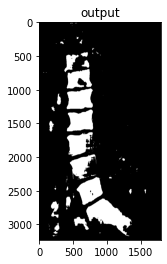

In [ ]:
example = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test')

# print(example.lst_input)
# for name in example.lst_input:
#     print(name[:-3])
#     break
# print(example.lst_input.pop(0)[:-3])
# for i in range(20):
#   data = example.__getitem__(i)
#   input = data['input']
#   print(input.shape)

a =np.load('/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/leaderboard/155.npy')
print(a.shape[0]*a.shape[1])
print(a[:,:,6].sum())
print(type(a[0,0,0]))
plt.subplot(111)
plt.imshow(a[:,:,6], cmap='gray')
plt.title('output')

# 이 셀 실행

In [ ]:
test_net = UNET()
test_net.cuda()

optim = torch.optim.Adagrad(test_net.parameters(), lr = 0.01)
test_net, optim, start_epoch = load(ckpt_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/record2', net = test_net, optim = optim) # 저장된 네트워크 불러오기

test_trainer_Spine_segment = trainer(test_net, train_loader,"Adagrad", epoch_size=20, learning_rate=0.0001)

test_trainer_Spine_segment.test(test_loader)

1
2
3
4
5
['121.dcm', '122.dcm', '123.dcm', '124.dcm', '125.dcm', '126.dcm', '127.dcm', '128.dcm', '129.dcm', '130.dcm', '131.dcm', '132.dcm', '133.dcm', '134.dcm', '135.dcm', '136.dcm', '137.dcm', '138.dcm', '139.dcm', '140.dcm', '141.dcm', '142.dcm', '143.dcm', '144.dcm', '145.dcm', '146.dcm', '147.dcm', '148.dcm', '149.dcm', '150.dcm', '161.dcm', '162.dcm', '163.dcm', '164.dcm', '165.dcm', '166.dcm', '167.dcm', '168.dcm', '169.dcm', '170.dcm', '171.dcm', '172.dcm', '173.dcm', '174.dcm', '175.dcm', '176.dcm', '177.dcm', '178.dcm', '179.dcm', '180.dcm', '191.dcm', '192.dcm', '193.dcm', '194.dcm', '195.dcm', '196.dcm', '197.dcm', '198.dcm', '199.dcm']
(1, 3240, 2144)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
1.0
(3240, 2144, 7)
2
3
4
5
['122.dcm', '123.dcm', '124.dcm', '125.dcm', '126.dcm', '127.dcm', '128.dcm', '129.dcm', '130.dcm', '131.dcm', '132.dcm', '133.dcm', '134.dcm', '135.dcm', '136.dcm', '137.dcm', '138.dcm', '139.dcm', '140.dcm', '141.dcm', '142.dcm', '143.

# After Train & Test : (Input & label & output) image file save and visualization

(6, 1024, 1024)
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 0. ... 0. 1. 1.]
  [1. 1. 0. ... 0. 0. 1.]
  ...
  [0. 1. 0. ... 1. 1. 1.]
  [1. 1. 0. ... 1. 1. 1.]
  [0. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 0. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [1. 1. 0. ... 0. 0. 1.]
  ...
  [1. 0. 0. ... 1. 1. 1.]
  [1. 0. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 0.]
  [0. 0. 0. ... 1. 1. 0.]
  [1. 0. 0. ... 1. 1. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [1. 1. 0. ... 1. 1. 0.]
  [1. 1. 0. ... 1. 1. 1.]]]


Text(0.5, 1.0, 'output')

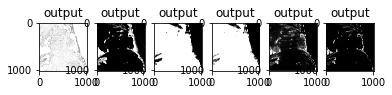

In [ ]:
output = np.load('/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result/numpy/output_0011.npy')

# aaaaa = output[4]
# print(aaaaa)
# classifier = lambda x :  1.0 * (x > 0.5)
# print(np.amin(aaaaa))
# print(np.amax(aaaaa))

# dn = lambda x, min : x - min
# positive = dn(aaaaa, min=np.amin(aaaaa))
# dnn =dn(output[3], max=np.amax(output[3]), min=np.amin(output[3]))


# preds = (output-np.mean(aaaaa))/np.std(aaaaa)
# preds = torch.sigmoid(preds)
# preds = classifier(preds)


print(output.shape)

print(output)


plt.subplot(161)
plt.imshow(output[0], cmap='gray')
plt.title('output')

plt.subplot(162)
plt.imshow(output[1], cmap='gray')
plt.title('output')

plt.subplot(163)
plt.imshow(output[2], cmap='gray')
plt.title('output')

plt.subplot(164)
plt.imshow(output[3], cmap='gray')
plt.title('output')

plt.subplot(165)
plt.imshow(output[4], cmap='gray')
plt.title('output')

plt.subplot(166)
plt.imshow(output[5], cmap='gray')
plt.title('output')





Text(0.5, 1.0, 'output')

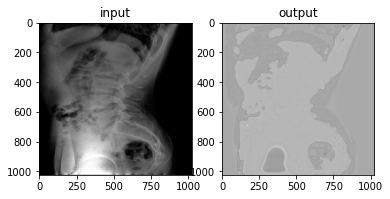

In [ ]:
input = np.load('/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result/numpy/input_0010.npy')
output = np.load('/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result/numpy/output_0010.npy')


plt.subplot(121)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(122)
plt.imshow(output[0],cmap='gray')
plt.title('output')


In [ ]:
result_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result'

lst_data = os.listdir(result_dir)

lst_input = [f for f in lst_data if f.startswith('input')]
lst_label = [f for f in lst_data if f.startswith('label')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_input.sort()
lst_label.sort()
lst_output.sort()

id=0

input = np.load(os.path.join(result_dir, lst_input[id]))
label = np.load(os.path.join(result_dir, lst_label[id]))
output = np.load(os.path.join(result_dir, lst_output[id]))

plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label,cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(result,cmap='gray')
plt.title('result')

IndexError: ignored